In [ ]:
import os
import shutil

In [ ]:
shutil.rmtree("/content/drive/MyDrive/phase6/wavData")

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/covid19-cough-audio-classification


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 99% 1.23G/1.24G [00:10<00:00, 142MB/s]
100% 1.24G/1.24G [00:10<00:00, 131MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/covid19-cough-audio-classification.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import os
import librosa
import librosa.display
import cv2
import numpy as np
import soundfile as sf
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
#Convert files from .webm and .ogg to .wav
def convert(name,source_folder_path):
  source_file = source_folder_path +'/' + name
  destination_file = source_folder_path + '/' + name
  if os.path.isfile(source_file + '.webm'):
    subprocess.call(["ffmpeg", "-i", source_file + ".webm", destination_file +".wav"])
  elif os.path.isfile(source_file + '.ogg'):
    subprocess.call(["ffmpeg", "-i", source_file + ".ogg", destination_file + ".wav"])
  else:
    print("Error: No file name {0}".format(name))
  print("done")
  

In [9]:

#function for segment file audio to corresponding cough segmant
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.2, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""

    # array to descripe position of segmant value            
    cough_mask = np.array([False]*len(x))
    
    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask




In [10]:
def un_silence(sound,fs):
  cough_list,mask =segment_cough(sound,fs)
  # iterate for each segmant in audio file
  x = np.ndarray((1,))
  for segmant in cough_list:
    x = np.concatenate((x,segmant),axis = None) 
  return x,fs

Text(0.5, 1.0, 'original wave')

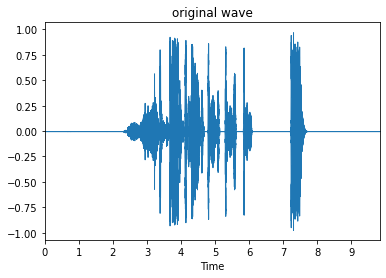

In [18]:
y, sr = librosa.load("/content/0b03673a-28db-4e1c-aeb0-4fec88d977a1.wav", duration=10)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('original wave')

Text(0.5, 1.0, 'pitch shift wave')

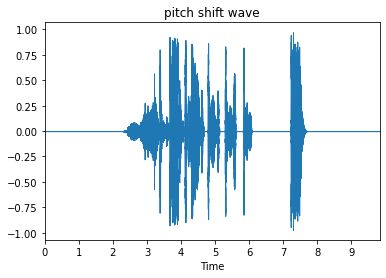

In [19]:
pitch_shifting = librosa.effects.pitch_shift(y,sr,n_steps=-4)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('pitch shift wave')


Text(0.5, 1.0, 'unsilence wave')

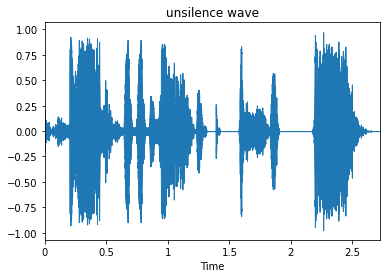

In [16]:
y, sr = librosa.load("/content/0b03673a-28db-4e1c-aeb0-4fec88d977a1.wav", duration=10)
y , sr = un_silence(y,sr)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('unsilence wave')

Text(0.5, 1.0, 'wave with padding')

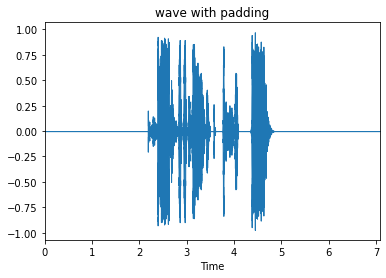

In [17]:
meanSignalLength = 156027
s_len =   len(y)
## Add zero padding to the signal if less than 156027 (~4.07 seconds) / Remove from begining and the end if signal length is greater than 156027 (~4.07 seconds)
if s_len < meanSignalLength:
        pad_len = meanSignalLength - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(y, (pad_len, pad_len + pad_rem), 'constant', constant_values=0)
else:
        pad_len = s_len - meanSignalLength
        pad_len //= 2
        signal = y[pad_len:pad_len + meanSignalLength]
plt.figure()
librosa.display.waveplot(signal, sr=sr)
plt.title('wave with padding')


In [6]:
subprocess.call(["ffmpeg", "-i", "/content/zienb.ogg", "/content/sample_data/healthy" + ".wav"])

0

In [ ]:

metaDataPath = "/content/sample_data/metadata_compiled.csv"
audioDataPath = "/content/" 
augmentedSignals_healthy = "/content/drive/MyDrive/phase6/augmanted_audio/healthy/"
augmentedSignals_covid = "/content/drive/MyDrive/phase6/augmanted_audio/covid/"
metaData = pd.read_csv(metaDataPath)
counter = 0
for index,row in metaData.iterrows():
    fname = row["uuid"]
    print(fname, " ", str(index+1),"/",str(metaData.shape[0]))
    convert(fname,audioDataPath)
    signal , sr = librosa.load(audioDataPath+fname  +".wav")
    ## Cough detection refinment: greater than 0.7
    if row["cough_detected"] >= 0.7:
        ## Multi-class to binary classification:
        if row["status"]=="COVID-19" or row["status"] == "symptomatic":
            signal,sr = un_silence(signal,sr)
            if(len(signal)):
              sf.write(augmentedSignals_covid+"sample{0}_{1}.wav".format(counter,1), signal, sr,'PCM_24')
              counter+=1
              pitch_shifting = librosa.effects.pitch_shift(signal,sr,n_steps=-4)
              sf.write(augmentedSignals_covid+"sample{0}_{1}.wav".format(counter,1),pitch_shifting, sr,'PCM_24')
              counter+=1
        else:
            if(len(signal)):
              sf.write(augmentedSignals_healthy+"sample{0}_{1}.wav".format(counter,0), signal, sr,'PCM_24')
              counter+=1

001d8e33-a4af-4edb-98ba-b03f891d9a6c   1 / 23231
done
00357712-dd5a-4c0a-90a4-39f1f4b9d5fd   2 / 23231
done
00e0a33c-6561-406e-b543-4c9f07b860f7   3 / 23231
done
01424527-9c3b-4b6e-96f1-9eea3150819b   4 / 23231
done
015576c8-2b03-4dcb-b251-78a984fe86fe   5 / 23231
done
015ec831-e765-44ee-aefc-10dfd95dec78   6 / 23231
done
01672ac0-dfd5-4aaf-b57b-d6dfa411b43d   7 / 23231
done
0177b817-0ba3-498a-bc05-48bc66cc91b8   8 / 23231
done
01820f7c-b953-4faf-aa13-978cfda6b08e   9 / 23231
done
01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7   10 / 23231
done
022a0675-b459-479b-85ed-c88529ad9a29   11 / 23231
done
0238baa4-fba3-4d4e-a049-b97d2ec223ac   12 / 23231
done
0258c88d-f133-4d76-8c7b-8268a0048565   13 / 23231
done
02aa80ef-a83b-477f-b01d-575651364b22   14 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


031fd54a-87b5-4223-9af6-60985127fb7a   15 / 23231
done
033da4e3-7365-4adc-9252-7347816e4e77   16 / 23231
done
0379c586-c500-483c-83a6-95b63afe6931   17 / 23231
done
03c1afa7-eee5-4c18-bd40-c4d91e6d320e   18 / 23231
done
03d30b8b-03f8-4089-bda8-0e14deec7d82   19 / 23231
done
04dc09f2-896e-438b-9509-7a0f30989bc8   20 / 23231
done
04f247f1-6167-4bdf-a3ba-0428a5ed07d4   21 / 23231
done
054ba6b6-35c9-4b73-9016-0a132bb6d166   22 / 23231
done
059eb180-bd06-4f60-aa98-8f24a2a79a0a   23 / 23231
done
05f2d808-7044-4c4b-8fbd-baff611383da   24 / 23231
done
0640716b-e287-4181-a653-5b798e8308c8   25 / 23231
done
068f9715-623a-45be-a17a-055a9028b4c6   26 / 23231
done
06b568b5-b9f8-4334-816c-c16009bb5de7   27 / 23231
done
06b58ff7-42e9-49d8-8b56-dd82e7b18ace   28 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


0762cd0a-5ce6-4b1b-9374-5d4396c218ed   29 / 23231
done
080b6119-f1ab-4337-93dd-aaccf73b4ee1   30 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


082991fb-ee66-4970-91dd-50890f4cc9b1   31 / 23231
done
0837bd59-09c5-4098-afe3-4bcbfb0fb0e2   32 / 23231
done
085c22f5-f9aa-4b42-9c20-59c67baf52a5   33 / 23231
done
089100f6-5afb-4992-b85f-6ab7b89f64f0   34 / 23231
done
08d5d346-6219-4e6d-ac06-ef489f2d186c   35 / 23231
done
09115490-33a9-461c-9437-d7f71be057b0   36 / 23231
done
09126c08-5214-4723-94f1-7b654464eac0   37 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


0924c308-2cca-4ab2-8ef3-a204c349701b   38 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


09560dc6-bffd-4dd0-b132-b86ddbd3051c   39 / 23231
done
09856cc5-98d6-4c34-98ac-5fa30a9f05ad   40 / 23231
done
099f9c59-3206-438d-8fd5-be59c5337afa   41 / 23231
done
09ce4faa-211a-4607-bc9b-7a8ded5d7d9a   42 / 23231
done
0aa64689-c48a-421d-b353-c3496bad51ed   43 / 23231
done
0aec66e3-47a5-4f3f-bec6-ad38d090b219   44 / 23231
done
0b03673a-28db-4e1c-aeb0-4fec88d977a1   45 / 23231
done
0b0d7e10-8353-4124-a16b-bf96e405f63c   46 / 23231
done
0b1a540a-b6e7-4a2f-8796-28bd04554a36   47 / 23231
done
0b4552b2-8dbe-4dd3-9825-5d453e4b5b3a   48 / 23231
done
0b6c6e9b-7c10-4977-a281-f809b939c2e7   49 / 23231
done
0b734898-c320-4121-9dd4-b5ca89a227b6   50 / 23231
done
0bcea474-8e87-40e5-a071-a270d58997db   51 / 23231
done
0be75221-126f-4971-bf65-d8c3189bfeff   52 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


0c181c0d-ea12-4b3c-9356-9e41f9d62a8e   53 / 23231
done
0c35e382-31cd-42cb-bc87-8a84b9c52a41   54 / 23231
done
0c4da14c-7035-41b7-ade2-38aa1481c046   55 / 23231
done
0c68c302-724f-49e0-a00c-9cbe64cd9f1d   56 / 23231
done
0d1cb244-e3cb-404d-97f5-99592b92da44   57 / 23231
done
0d92ab37-f93e-46c6-a89d-e3b7617621c5   58 / 23231
done
0dbd034b-71d1-4927-8f33-c0645f42c47a   59 / 23231
done
0e2f8fe3-12aa-464f-a4cc-312efa425b98   60 / 23231
done
0eba0c0a-5609-4777-903d-b15292798250   61 / 23231
done
0ebb8b25-3a7e-4018-81c6-c93c832fa769   62 / 23231
done
0ed846f2-5ce3-4f7f-9f60-b0258ab2047e   63 / 23231
done
0ef3c0bc-56c3-44da-bea0-dc31a158414a   64 / 23231
done
0f8d80f9-700e-4069-924d-e15f29d7c19a   65 / 23231
done
0fbbcd89-d79a-49ec-b207-c0f2f32d8d50   66 / 23231
done
0ff8a246-cc95-42fe-8e5a-4243c274793e   67 / 23231
done
10344906-5f7c-4d1d-93a8-56585cc33b2f   68 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


105d18a9-f281-4e4c-bb7d-1ad9885696c9   69 / 23231
done
10a2bc11-50e8-461d-9de0-ef609d14f7d8   70 / 23231
done
10aed3ae-9ec1-4041-bac6-90b1d4634aee   71 / 23231
done
10b0f1cf-9c94-4ece-92fa-207f102e34dd   72 / 23231
done
11119259-2361-4f55-8051-dace70fd7ccf   73 / 23231
done
111ccb19-92b9-43e2-b44a-38cde5bf0ca5   74 / 23231
done
11237f1a-3eb2-4cf7-80f7-116df4b1699a   75 / 23231
done
11371e2c-f0df-4805-baf5-0753ade8261c   76 / 23231
done
1138a13c-52ef-49f2-82a6-19599c50a50a   77 / 23231
done
116a0485-7052-44f4-9c7f-b367ef7dba89   78 / 23231
done
11a0ef13-989a-4262-8329-e47b254ad8e7   79 / 23231
done
120e6cbb-dff8-48c1-ae81-6d94106a7997   80 / 23231
done
12121877-e33a-4cba-b63b-00b2e8433e5a   81 / 23231
done
12360bc1-26b2-4044-a11d-fb3bf8808ce2   82 / 23231
done
1266d596-9264-45fb-8cff-296c0d404a35   83 / 23231
done
126b940c-b6c6-4d3d-adc2-92aafab911b4   84 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


128aac08-4a43-4a36-ac34-5f294d90ca2e   85 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


135645f7-0fd0-4bc1-b84a-0da57a94f4fb   86 / 23231
done
1357788c-fd94-45ff-b31d-da0cda859731   87 / 23231
done
139d0f69-4c1c-416c-933e-ab45ea42ff93   88 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


13a65aef-e26d-4748-be3f-df3cdb226068   89 / 23231
done
13b55d58-ad6d-4cb4-933e-80622a4ff240   90 / 23231
done
13bbc1cd-358b-4e90-9a35-31428809eb2a   91 / 23231
done
141ad4b1-d9b2-407d-9e48-913915c02b74   92 / 23231
done
148a8b39-dc61-4a96-a3c1-819bf29852d9   93 / 23231
done
14c7b709-ac4d-4aee-bdbc-ac51c11a497e   94 / 23231
done
14fb399a-c792-43e2-b852-0e776f8a34a5   95 / 23231
done
1510dd92-a632-48ad-b5e7-1853a9e8e61d   96 / 23231
done
154161ff-1243-49c0-a377-72992b6954e3   97 / 23231
done
15a0a034-354e-4637-b74c-9653763e0862   98 / 23231
done
15f12b8d-7ba5-444e-975f-f1b26c6e75ae   99 / 23231
done
1614e597-81d6-4db4-9bed-43eff6c8effc   100 / 23231
done
166cf5f4-8366-41a8-8957-c38f816b33cf   101 / 23231
done
16f9b161-86c6-4af1-99cb-0ab327f10fed   102 / 23231
done
170b6b61-2b3a-422a-ba0c-835a4fded987   103 / 23231
done
1746a713-6fb7-4a01-a242-cf4c5f87ab52   104 / 23231
done
178f39e2-a261-4ec6-a8fb-3f89c3c795bb   105 / 23231
done
17aa763f-badc-46f6-a5bd-db9cbdd385ab   106 / 23231
done
17b

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1a324acb-12f7-4eef-8e8c-0c71a47280e2   120 / 23231
done
1a8062b2-bdf5-45b0-96d1-c0051c983c19   121 / 23231
done
1adc614f-9f34-451c-ac33-47a411f0a06d   122 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1b1f2c9b-7cfa-4eb5-837d-36ae3d647c92   123 / 23231
done
1b6f0f82-1aa5-423d-b4b0-e4244bb8960c   124 / 23231
done
1b7a8173-80be-4905-bdaa-b471b228b1ed   125 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1b9fe355-7a78-429a-9e75-a1c547506b2d   126 / 23231
done
1c21cb68-6ea8-4aa1-af22-2e64007554d7   127 / 23231
done
1c7b9152-fd61-4742-8da9-233dd0b93008   128 / 23231
done
1c829cee-09e7-4c71-8148-34250eb07ecb   129 / 23231
done
1c8853d4-5a0b-425e-b211-d20b2d16e35d   130 / 23231
done
1ca2ce6a-3153-45b7-9a20-fab29c44e6f7   131 / 23231
done
1cdc0a4b-9521-4b2d-a8b7-ee708232f594   132 / 23231
done
1cef13ee-037d-49cb-bbd3-bbb44328cd91   133 / 23231
done
1d3f954c-8d15-4279-832b-e2487b96750f   134 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1d471862-8805-411b-bd10-2b8e9ffdf718   135 / 23231
done
1d6f3f96-fb43-49e6-8c38-70586a9dc52f   136 / 23231
done
1d9490a3-155d-4eb5-a34d-acef154740ed   137 / 23231
done
1dd3b212-e969-4ede-a9d9-f24b711e2028   138 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1e2585ae-2c85-4cbe-a18b-a155e1acca64   139 / 23231
done
1e3c046d-82f7-445e-b6c3-06441f3da506   140 / 23231
done
1e4a8472-c9f7-4677-a92a-0e1ff412ab5b   141 / 23231
done
1e5944a9-49aa-46aa-8066-dd6cc82c9e28   142 / 23231
done
1e8669cd-1a0a-4059-a618-6faef2fb534c   143 / 23231
done
1f6a497a-7d48-4db2-be34-c7760e427427   144 / 23231
done
1fcd577a-af2b-4352-a735-a1d1a7e7d0b1   145 / 23231
done
1fd4bd15-88c4-47ae-bbe3-2434af431df5   146 / 23231
done
2018bfea-0071-4aca-8d45-18dac4d65199   147 / 23231
done
2035c7cc-128a-4ffa-9c96-e8bd59815210   148 / 23231
done
20602da6-a92f-40ad-81d2-1688f5f1fcde   149 / 23231
done
20638b85-0ab9-45cc-b257-9ce9986946de   150 / 23231
done
2089c2bd-d408-429e-9f15-138343a5cc9c   151 / 23231
done
210860ed-f80a-4ae2-ae9c-2a67ff637388   152 / 23231
done
212e4a83-34b9-4973-b0c4-c05567acdd8c   153 / 23231
done
215cf805-8e9a-44ee-8721-20db30e34e3d   154 / 23231
done
21ad6bc4-ecc4-4a22-b940-618bdd7ad20b   155 / 23231
done
21aee478-6d13-45ea-be4d-4f29fd244798   156 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


263a8d6a-9774-4293-90bd-d68c108f1e3e   181 / 23231
done
269039d8-86f6-41b1-bec0-fb78cb375a6f   182 / 23231
done
26b8be9e-74dd-4e89-ac6c-62b9994239fd   183 / 23231
done
26c85178-d112-4398-b77c-e2be741ca1d1   184 / 23231
done
26ce1218-1d55-4f45-a0f5-643c0f92c2c2   185 / 23231
done
26d7e2c7-6614-4dfc-af30-acefde8a21a9   186 / 23231
done
274fee77-6d89-4b0f-962e-28969658b430   187 / 23231
done
27c8a255-32ce-4162-9794-b9952945800d   188 / 23231
done
28027420-7148-4f4f-a4d1-0884389bc6df   189 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2818c2d1-e833-4f62-ba16-8f564a525398   190 / 23231
done
282c149a-f54c-43da-86a3-57a07dfd748e   191 / 23231
done
285e7f6f-503a-41f0-ac3b-173433a8cf40   192 / 23231
done
28755bd9-5000-4787-9d3f-332fe059fce2   193 / 23231
done
28757e31-b8f6-408c-982e-a016170ab3ef   194 / 23231
done
28c76cca-15d8-490a-a785-9bbb5c21fd26   195 / 23231
done
28d4e487-0d9d-4911-951d-5de7fcb5c986   196 / 23231
done
29426ec2-55bf-4ce0-a591-bd7ea2dd9a6c   197 / 23231
done
29633954-458e-4af1-b4a7-b775ef9ce11e   198 / 23231
done
2974b8ef-49f1-4390-a974-758104bd9f02   199 / 23231
done
2a52dd14-574a-4fdb-b328-bdeeef579d59   200 / 23231
done
2a9b4fb5-9073-4695-a812-20bce3bb40e1   201 / 23231
done
2aa8f538-07ca-41f3-b20a-8d9e5ef24cfe   202 / 23231
done
2ad48b3c-c962-4e0c-9f95-7c5511ac5838   203 / 23231
done
2b4d4a2a-15d0-4eb5-be88-3ace68983962   204 / 23231
done
2bee49f1-efda-4c6d-adc4-1e54d16fa96c   205 / 23231
done
2c148a1a-099b-48dd-97c2-437ecb15d430   206 / 23231
done
2c2734a6-e37a-4716-bb0c-9236410b4220   207 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2d79341b-2ce5-4c6b-82d0-599626f629d6   214 / 23231
done
2da2b65c-a06b-48c8-848f-fd905acb9b0a   215 / 23231
done
2dc9ffdf-3dda-4e42-90c1-edc537dff27f   216 / 23231
done
2de3fb8f-20a6-4fa5-8428-11cad3338d37   217 / 23231
done
2de5a53d-4efc-4eab-90b9-d8579cdfa0aa   218 / 23231
done
2df9d90f-7616-482f-ae5a-e0c8d3ee4289   219 / 23231
done
2e29caa5-a805-4d45-984e-39aa0ed633b8   220 / 23231
done
2e41a2bd-6462-407d-8078-9f7b86a54f52   221 / 23231
done
2e4ca5b9-2e1f-4e81-b830-c75ae040dfb4   222 / 23231
done
2e4d87d7-b9de-43c0-ae02-8bc985788b59   223 / 23231
done
2e99e2b0-fe3e-40ac-8f09-06d31261d5da   224 / 23231
done
2e9f905a-697c-48db-883e-7e905873172f   225 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2efb0a76-18e3-40a5-b660-af8c19c9df10   226 / 23231
done
2f3aea6f-4321-4afc-a00a-bb728fbc9f1c   227 / 23231
done
2f63ad4e-0441-454b-a5b1-20c88f864433   228 / 23231
done
2f97671c-5e6f-4a90-80c4-a54e8254ec6d   229 / 23231
done
2fc8bdd5-5565-4ad3-93d9-8a238b7b8be3   230 / 23231
done
3050a1e2-d70b-4f86-9e57-f33220b8f990   231 / 23231
done
306ec0c0-fb62-4471-a2d7-d05b752a7268   232 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


309f7a85-57c3-4b1f-baa9-d1290d1d1b23   233 / 23231
done
30f761c8-b6fd-4e2a-bf25-0e5cde6102be   234 / 23231
done
314e4ee9-ee77-4abc-a5fb-4e52142c57a5   235 / 23231
done
31b8dc8d-3fbd-4e0c-bbae-def12bc16ea2   236 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


31e5a9cf-6a3e-43a3-8e0f-65c99f5748e9   237 / 23231
done
323a4ba5-65c8-4494-b444-f6f6d65ea095   238 / 23231
done
32a150f7-8a0a-4c5e-b156-23552e4d58de   239 / 23231
done
32ba514c-b6e5-45a5-a62d-a4555084e3ed   240 / 23231
done
332ab58f-9728-4cea-9960-c49151120510   241 / 23231
done
3330de48-799b-45f9-b13d-0bfe97622003   242 / 23231
done
336b15df-b282-4956-bb68-548ec950bb2f   243 / 23231
done
33b688eb-cae8-40cb-9d71-694f5d2f417f   244 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3481b694-34fe-4b03-a529-88ef085815fd   245 / 23231
done
34c2c68f-3728-4b17-91a0-2700c1b4fac5   246 / 23231
done
35618eb7-d045-42b0-8207-e6b80b58e920   247 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


356ca0b2-925f-42b4-90ea-0174c8da8945   248 / 23231
done
35ee826c-b4e1-40ae-9873-7df156071b7b   249 / 23231
done
36090427-bc31-487b-ae27-1b7105ce39ca   250 / 23231
done
36535622-407d-4226-adad-48b010e8ee83   251 / 23231
done
36e4f76f-ebb6-45e4-b246-64c8fbb9e7db   252 / 23231
done
3722d824-c4bc-489d-8a8f-6bb171129e19   253 / 23231
done
37347587-048a-4a1c-a100-7cf820711428   254 / 23231
done
37973b58-b7bf-48f3-8c3c-8e023331ce88   255 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


37b27ce5-a134-431d-ae71-8c3c6fe273af   256 / 23231
done
37dac510-2e8a-47a5-b864-d229a46d72bf   257 / 23231
done
37fdf4e5-d6f0-431d-a198-28dae66a4e84   258 / 23231
done
380bc7f0-d950-450c-9f5e-43c7c3f4c132   259 / 23231
done
38c23848-68c1-41a6-b8c8-5d0685dc0246   260 / 23231
done
38cd2f39-edad-4c95-a338-c127c6ae3517   261 / 23231
done
39a84539-2cfc-4d2f-b7b8-05ba9a8286d8   262 / 23231
done
39a9cac4-e55d-400c-8322-5791683e66a8   263 / 23231
done
39dde9fb-3225-40e4-b8dd-9173f435930d   264 / 23231
done
39e4cc19-0db4-492a-b580-9fc4e4ab62ea   265 / 23231
done
39fd76e4-f504-4079-9bf3-36d3e26887ca   266 / 23231
done
3a2ca593-e0c1-4edc-800e-41d009bf5650   267 / 23231
done
3ac4c15d-fadd-430f-8866-399b9bd19adc   268 / 23231
done
3af1ee7b-2411-4cb0-afb1-e49d2c9a9cad   269 / 23231
done
3b018a2b-59a9-484b-a71e-437fb96698ab   270 / 23231
done
3b917045-a264-4e3c-9a70-491e49448c36   271 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3b977c82-0883-476c-aee6-0e7d6368c4b4   272 / 23231
done
3bc2b14b-0b81-40bc-b6db-6f8864ede96a   273 / 23231
done
3be23405-2584-49fd-8f74-a22fbeeea044   274 / 23231
done
3be5af36-9e52-465a-81a6-da1c60d350f5   275 / 23231
done
3c1efb88-ebba-4dd6-8fb7-ac1fb6e78abb   276 / 23231
done
3c55e193-dc1a-46f0-95a7-f92e6f2982c7   277 / 23231
done
3c6cfda1-3fe9-403d-b5d1-7797420debe2   278 / 23231
done
3cb4dbb6-d191-4331-bcdb-eec0f100484a   279 / 23231
done
3cbd8630-11c0-4df0-a8c5-5200bec45213   280 / 23231
done
3ced6917-43cc-4227-8236-8e0d194008ea   281 / 23231
done
3d74c62a-40cb-4f3f-8851-d3aae9e44b48   282 / 23231
done
3d89ee73-6ff9-44bf-9e0c-7c51bdfd7ce6   283 / 23231
done
3db14b07-2720-4fa9-870a-725fda24a0bd   284 / 23231
done
3dcb6589-5216-4795-ae68-7faa87b6873f   285 / 23231
done
3deed1f8-085b-4531-92f1-c03ec500802a   286 / 23231
done
3e051a0d-5f5e-4ec6-b0e9-6a97c809cc92   287 / 23231
done
3e0fc549-5b05-4405-bfd4-051e7fba7d17   288 / 23231
done
3e4f0ebc-7100-48a8-b164-4d90b8dee8db   289 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


413931d3-6563-4512-a89c-b749d635b517   299 / 23231
done
41a9aa47-9814-4a0f-a0a3-f3d919bb893d   300 / 23231
done
41bb08e9-6d43-41bc-bca2-a465f7dcf2f3   301 / 23231
done
41d44897-1d84-4ac9-8320-863179e900c6   302 / 23231
done
424f1c61-5421-4da9-b3de-70e2d706867e   303 / 23231
done
42dcff9d-b2e1-4b9e-bd93-81a0a100d232   304 / 23231
done
4376cf7a-db13-4730-b2bd-890bd5e5cb8b   305 / 23231
done
43a2dde5-4809-40c8-9034-868d77800094   306 / 23231
done
43cfe07c-cf76-4d97-914a-b1a1ec2c9759   307 / 23231
done
43d84d62-8837-479b-bcb6-30effd9ecbc3   308 / 23231
done
446f549d-d178-4c5b-af5f-8b32cc67517f   309 / 23231
done
44d6d275-b422-4338-bda2-2d0cc203f72b   310 / 23231
done
450ae1f5-1fbb-41f7-9a93-8c755cfaf46c   311 / 23231
done
450dbdc0-e479-43a2-b3d2-8e51b8253649   312 / 23231
done
45bb4c42-6caa-429f-ac2a-e8e80f4d372e   313 / 23231
done
45cfa32a-1902-4668-9fe9-29148afe007a   314 / 23231
done
460d4016-9901-44d2-9466-c86ecc3278d2   315 / 23231
done
4613beb0-6e70-4cab-8eb8-470cd2d36bea   316 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


472f8336-5e96-4a9b-971f-21bca0979ee9   323 / 23231
done
4730e1f6-1156-4864-ba28-2a241ecfec76   324 / 23231
done
4735aed3-46f9-44c5-91f0-ca772c541fff   325 / 23231
done
47b47be2-59eb-4ae8-b0ca-e4180f04896c   326 / 23231
done
47ceafde-45d9-4bb6-881a-5ef866fa908d   327 / 23231
done
47e05445-7276-4064-99d3-ca3e96689e10   328 / 23231
done
47edb277-7f3c-426d-8e14-a0385f3c1b77   329 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


47f986ff-4f1b-4518-b777-91ab450097a3   330 / 23231
done
485818bf-1f57-4e01-8d9a-fe67251d14e8   331 / 23231
done
48834369-72f5-4bbb-847c-5636af5a6882   332 / 23231
done
4897bd07-6c6d-408f-8f5c-6390e81d1147   333 / 23231
done
48aacddd-c0ea-43b3-9e80-5f38c43a348c   334 / 23231
done
48f84033-8615-4805-b2a5-d84050d3951b   335 / 23231
done
48ff5e27-832e-4450-9ea5-288a0e6967db   336 / 23231
done
491018d6-fe1e-4b24-9c42-70971ec93615   337 / 23231
done
492bb841-6ec8-4a72-b091-06897096e79b   338 / 23231
done
4934dd77-80e0-42b9-bfc4-995b03b76450   339 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


49360aab-6070-4492-a204-34ee2abe6a40   340 / 23231
done
493632f2-537a-4a36-a932-268a8aa59486   341 / 23231
done
49944a66-4aa3-4986-b3de-10efa29e13d4   342 / 23231
done
49bc7b95-fbe5-4933-886e-8752b8acf842   343 / 23231
done
49c952bf-0654-4baa-a67f-363745f146de   344 / 23231
done
49cb0077-b389-4563-81c5-56cef6fa019e   345 / 23231
done
49fa8526-596b-4b5a-a495-f394765ae2e1   346 / 23231
done
4a198459-ae65-4e81-a489-1eec01708ede   347 / 23231
done
4a31db13-a871-43f8-88ed-f5f153e79fa2   348 / 23231
done
4a54513d-cdcf-4ea6-8139-b0f1d33d41d8   349 / 23231
done
4a5cdc39-a64d-4df0-b9d9-42bb4683c6bb   350 / 23231
done
4a6db153-038f-4fea-8d60-38a0df7a87ba   351 / 23231
done
4ad7f735-eee2-41d2-b6c4-452a38b797e4   352 / 23231
done
4afa3822-6de3-4877-b5ee-2e4e7ffb9081   353 / 23231
done
4afec958-179d-4022-b89e-0889adf112c0   354 / 23231
done
4b1ddf81-8a08-4acc-a160-cb6a88485217   355 / 23231
done
4b89c5e2-1902-4497-af7a-1eda2630656b   356 / 23231
done
4b910657-348b-4a87-bf93-257fd2081cfa   357 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


4d230bec-1056-49ca-b274-c0825b924824   366 / 23231
done
4e2812be-e8e1-4ef5-9c62-c5af106828bb   367 / 23231
done
4e47612c-6c09-4580-a9b6-2eb6bf2ab40c   368 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


4eab6d7e-32c1-4a7f-be8c-b1cbcffe2420   369 / 23231
done
4eb2a3c7-7ca4-48ff-bbeb-aca25c5f1cde   370 / 23231
done
4ec974db-442e-48da-8b65-4e3ba9b90ed1   371 / 23231
done
4eec3002-43f3-477b-bd24-bc2ba1fd920e   372 / 23231
done
4efe63d6-2447-4bab-a6df-8f95ffaf4a7f   373 / 23231
done
4f51059b-0e34-4ae8-8ea8-66630d9b147b   374 / 23231
done
4f5a4b71-46a6-42d8-aecd-7e0cc23d7d70   375 / 23231
done
4f6c6fa4-e708-4c9a-ac8a-7137a4a60093   376 / 23231
done
4f821c6a-6ef6-4284-abb2-8f43f570a657   377 / 23231
done
4fa3ac8d-f252-40d6-bccd-24aa5e35556c   378 / 23231
done
4fa482c1-e2c7-402f-b383-343c18be4ccd   379 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


4fa54167-06c6-485a-a7b5-4b3696aa1393   380 / 23231
done
4fc9a8e3-909a-4e92-9621-d5e578817f21   381 / 23231
done
4ff82172-fda0-453c-80f2-1cf5aaffa8f1   382 / 23231
done
506b5606-cecb-4fba-8723-c4a2bfb8b038   383 / 23231
done
507d85c8-ee5b-43af-be00-354159f46eaf   384 / 23231
done
508530cf-f788-49f9-9a31-943ea7fcf7b7   385 / 23231
done
509ff028-b1b2-41dd-ae5c-ccfbfe7b9838   386 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


50e4574d-0fa7-4fa0-977d-394644797b1b   387 / 23231
done
51a2865a-4a0c-4592-9e39-1256f1cbe401   388 / 23231
done
51e2e40b-f1cd-45ba-ad05-8219c595235c   389 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


522a43ec-3d80-43e4-97c9-c21ceb8b7a63   390 / 23231
done
525391df-50d3-4dec-a271-27f0922ad107   391 / 23231
done
525bb580-d7bc-4f91-b206-5f4890cfec0d   392 / 23231
done
5287e036-c41e-4527-93de-c6cdbf1a8461   393 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


52de6b02-84b4-4e74-9061-983488b4e300   394 / 23231
done
53325adb-0ff2-480a-8af0-fd9da2a10322   395 / 23231
done
533553f6-ddb3-4d32-b1b1-97ac826b9e0c   396 / 23231
done
5344e65e-e79c-4780-90bc-2c133d77942b   397 / 23231
done
5418a808-f17d-4985-a1eb-5d1ee3647cb0   398 / 23231
done
5607860e-70fd-4fab-8e93-158ecedabdaa   399 / 23231
done
563a6cd6-55b0-4895-af02-87de034ae948   400 / 23231
done
563ae851-f40b-490c-99c9-1acf9c269a3c   401 / 23231
done
5648bc0c-24f9-430c-bdbe-8f81522b8fc3   402 / 23231
done
568c58f5-3a30-4166-bc06-b65f06bfcc51   403 / 23231
done
56994aa1-4626-4782-9f27-f125adfd120a   404 / 23231
done
56c781a6-214d-4968-969f-3797e3567139   405 / 23231
done
56ecb826-b12c-43d9-b54b-8dedede30b0f   406 / 23231
done
56ff4794-4d52-4b89-8e9c-68ab3d8d1a48   407 / 23231
done
583240d0-4e6f-4456-8894-be5a74010add   408 / 23231
done
583b78b9-ac37-4921-9865-fd6f683ad3e9   409 / 23231
done
58970bd3-2993-4762-8b21-0c5a2937c16b   410 / 23231
done
58a3d924-98cd-426f-9b58-cb6240b7d044   411 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


5aa4dae0-fe23-4eb2-9d62-e6016a1c9f8a   419 / 23231
done
5ad7b5d3-e9b3-457a-8946-39bd3e1fe3df   420 / 23231
done
5b0be374-28d0-4a16-b010-0c18a460a7d4   421 / 23231
done
5b5e2616-1445-4c2c-a1b3-db946cbd145a   422 / 23231
done
5b5fb2f4-900a-4023-b4fd-c55b66dc065b   423 / 23231
done
5b8a46e1-945b-4c87-847a-9bbf90a965a9   424 / 23231
done
5bbd361a-f7ab-4397-9eec-e76a4758489d   425 / 23231
done
5c25d8f9-0c68-46b2-95be-71c84536978d   426 / 23231
done
5c4d833f-64ac-4ec0-82d9-3327020c870f   427 / 23231
done
5c53c446-4d42-4dcf-9a2a-3c8c4a7682e1   428 / 23231
done
5c6e7852-0002-40f8-a92f-9580f79a3c32   429 / 23231
done
5d1fff93-65cd-49dd-b9d4-3303e350b546   430 / 23231
done
5d61957f-6865-4e0a-b666-03a928f39e92   431 / 23231
done
5d7dd9db-a984-4669-ae06-c4145d4067a7   432 / 23231
done
5d80da79-cf2d-4a6e-9adb-1846cc3b502c   433 / 23231
done
5d9c941a-089f-4c65-b692-5a1bf0d091a4   434 / 23231
done
5deabe3b-8761-4ef0-8cfa-a1a21ddabc17   435 / 23231
done
5e117d03-3fcb-41a8-bc6c-2855e9a695fe   436 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


63f4e572-e693-4265-8b77-07f552fc63e9   468 / 23231
done
644884a7-bae1-437d-ba03-6aa0c520d908   469 / 23231
done
6462d540-48bc-410b-b08e-cdf0b45ee118   470 / 23231
done
64da4ad6-4280-49a1-bd37-e35efd7837c6   471 / 23231
done
658daf16-7fc3-4640-911e-81dac60a2df9   472 / 23231
done
65be7822-e7c7-4fdc-9549-bf3fac30f919   473 / 23231
done
65e99746-4a0c-4496-8cb0-e234ed1fa93b   474 / 23231
done
65f8a73e-9cf4-480f-8f4f-c31e67753ea7   475 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6604cf63-454a-4b13-9fc9-95eb74566e8e   476 / 23231
done
660afa71-ac8d-4824-b751-3d23f4dc0013   477 / 23231
done
660f52df-42dc-49e9-ac87-473c6db99d17   478 / 23231
done
661ddc1b-35d3-4e55-9136-2d13e012ab57   479 / 23231
done
668c6e03-edc6-45aa-98d1-429fe5bd92fa   480 / 23231
done
67b68c39-caf5-46b1-b8da-7f2fd9068a5a   481 / 23231
done
684c1be1-e790-4f4f-a84a-ab7834310c5b   482 / 23231
done
6864ecfc-c540-4e0d-a9cb-933dd9b77e05   483 / 23231
done
6868da77-a36a-4fb4-afa5-aba26bd2bbd5   484 / 23231
done
68be5313-193c-42ca-acdc-f6f93c9c1126   485 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


68ce6385-d861-42f4-bb68-8f4ba99c10f6   486 / 23231
done
6954d463-42a7-4d2a-a1c1-c20376224604   487 / 23231
done
695c085f-a11f-4180-9c9d-7cec980fced9   488 / 23231
done
6975f8d3-62e1-409f-ba3a-10f4cbbbc1ed   489 / 23231
done
69917144-a7de-4389-923c-443396f54721   490 / 23231
done
69e7b5c5-0469-42dd-b68f-9a7f7637425b   491 / 23231
done
6a04b4c4-3998-496e-b4a1-209d16e27adb   492 / 23231
done
6a2505b9-61a4-4fd3-81ee-c63140ab2b5e   493 / 23231
done
6a2ffeef-99c5-4765-8dac-92aec8459d79   494 / 23231
done
6a641bd4-4cfe-4327-9413-4dd7524c9cf2   495 / 23231
done
6a788632-db94-4ee4-a213-3fab71cddf8c   496 / 23231
done
6aa04a12-6e9a-4b9c-80da-a9fa01fc1757   497 / 23231
done
6ac1cde9-7727-49d2-848c-983e2e541845   498 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6b234a9d-2305-4452-826d-1a514b3cb6b2   499 / 23231
done
6b265018-98b7-4e61-934a-74b2b0bebce9   500 / 23231
done
6ba62302-b54e-47dc-8a22-eab0bb0411c2   501 / 23231
done
6c076190-d355-49cb-a87e-88a4c0766853   502 / 23231
done
6c7893ac-4ca9-47af-8a91-fd0926dd7f39   503 / 23231
done
6cc200db-e499-4074-906e-8c335c298fcd   504 / 23231
done
6d17c68c-4b55-4cb1-9846-f9ee4db423a9   505 / 23231
done
6d194cdc-ba5a-40ba-8232-5bf150026c67   506 / 23231
done
6d52febd-ec46-4c06-a47a-467611ddefdc   507 / 23231
done
6d941efe-43f9-4a64-8172-58cbb20400ab   508 / 23231
done
6d9b271c-d703-4002-89f2-10d6a10595c2   509 / 23231
done
6dc3c03a-aeaa-4130-8295-c09e80895c76   510 / 23231
done
6ea6af0c-0f77-46d6-a65b-8df3a925d231   511 / 23231
done
6eaee903-0df8-4a22-b0c6-792d838369fa   512 / 23231
done
6ecde34e-2767-47b0-aef3-2828d4b181c7   513 / 23231
done
6efeffcd-e1bb-4b58-a5d3-39f6afcfdb03   514 / 23231
done
6f0a2344-8d8b-4db5-b4c3-cf569ca4f7b9   515 / 23231
done
6f2e1f59-6d57-499a-8c26-978d80255271   516 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


70f0d27f-23df-4e77-b491-b6e016fb6ada   526 / 23231
done
7117304a-e59b-42c9-bea9-3c6f17b0d30e   527 / 23231
done
71d15d20-ef56-49dc-bf1f-8fc3699d3bab   528 / 23231
done
72863bef-2073-4e5a-b289-0954a977d25e   529 / 23231
done
7288ad05-549c-4cba-b2c2-1c3ee850e750   530 / 23231
done
729d23d1-9abd-44df-8b05-22217b1ffbdf   531 / 23231
done
72ab770e-a11d-4f98-8e94-7027f3f7a0ab   532 / 23231
done
72bd6d64-d1f4-4608-87ba-7ca309dadedf   533 / 23231
done
72eb0edc-42e6-40b5-b788-39d8dae7f353   534 / 23231
done
72f67002-96a6-47f7-8c1d-2a4093887929   535 / 23231
done
731cbe07-5754-46cf-bb5c-873a670cd5d7   536 / 23231
done
7336b77f-6873-4e2c-837d-2ef925a3d33e   537 / 23231
done
733b0db4-aec3-4afa-a7fc-7e29e0c9403c   538 / 23231
done
7382a3e9-33ad-4c9f-9810-480238262b65   539 / 23231
done
73b29e0f-daed-4b90-9ab8-5f33065f23a4   540 / 23231
done
7465377a-8963-4a0e-bd1b-92a8924b1ccb   541 / 23231
done
74908b90-bfee-4589-9625-bc930ee8c42e   542 / 23231
done
74d33247-658a-45ea-a641-5b736ee5498f   543 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


751c4649-2d74-46f1-a873-b0d40946e145   544 / 23231
done
756d7aa4-e12a-4eb3-b119-2b8a7db0abb6   545 / 23231
done
7602f4fa-cdda-4f3b-a46c-20144e44d1a4   546 / 23231
done
7604e8fc-7643-4491-a57e-8711144f004d   547 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


760cb050-4175-4498-817d-a9976e359c52   548 / 23231
done
764d2729-f572-490a-8f22-1397e2e19906   549 / 23231
done
76779311-1f9c-40b5-845d-bde19b0d9c0e   550 / 23231
done
76a03d41-09de-4d00-b1e6-0cedf0b3dbda   551 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


774bafb8-5d1c-42c5-a0a8-91ba0a85a04b   552 / 23231
done
777470d7-add6-492a-abed-a2282e7bc061   553 / 23231
done
778c38b9-431e-467c-85b0-468e79deacd8   554 / 23231
done
77fac9cb-3cbb-4509-9312-0438fab11acb   555 / 23231
done
78500f29-e9c1-4abf-ad29-fb279bf359f7   556 / 23231
done
78a212f6-63db-4884-921a-1b307b2ae9a7   557 / 23231
done
79083b4c-387a-42dc-a3b1-7e32e155ebe0   558 / 23231
done
792aa06d-432c-4137-8cfd-042fe703d1b7   559 / 23231
done
7985c4a1-0ca1-4d36-8454-768db1b75be1   560 / 23231
done
799ef10e-7b4e-482b-8ae2-87970f4aa3f7   561 / 23231
done
79b593db-1bf2-4be4-99f0-3a7725a0d712   562 / 23231
done
7a20fe3e-5701-451c-b5c9-b8daf5b328e3   563 / 23231
done
7a222f35-cc21-4085-8202-059ef3ee15d3   564 / 23231
done
7a710fd5-e0af-4a11-a761-7e38d3fa5fc6   565 / 23231
done
7a985f89-ed5d-41e2-9f5d-8d8982508665   566 / 23231
done
7ae1ffe1-2259-411f-8ead-6c107e01e824   567 / 23231
done
7b423206-e57c-463b-a43b-c82cdb055f26   568 / 23231
done
7b52c788-7972-4c4d-8f25-3bba95ea0cd8   569 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8489239f-f70b-4b0b-a220-7700604d322f   603 / 23231
done
84f4ba06-bcc4-4a68-bb08-725c486524d7   604 / 23231
done
84f7f9eb-ce07-4ace-8c02-d83360a25db4   605 / 23231
done
85e287c6-9f6f-4bf7-8a39-fe36f8ce06b2   606 / 23231
done
863527af-d101-4596-8825-428394f0d6c2   607 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


864b3b33-c30b-4215-a6ad-66be69c07197   608 / 23231
done
86b4b29b-2c0f-40e3-9d37-644b492ea570   609 / 23231
done
86e08bf0-623f-43ad-b26a-d2b4c7c1f350   610 / 23231
done
86e5871f-d0ca-4ecc-8833-2771f36af22c   611 / 23231
done
874f9743-b74a-41bc-aa26-609089ca3afd   612 / 23231
done
87836a21-bfd9-43f0-8282-0649bc7d93f0   613 / 23231
done
87cb9c68-017e-4791-bca3-648a13ee3372   614 / 23231
done
87dcbffa-7685-46d7-a67a-d16e09b33cc0   615 / 23231
done
87f52d87-03d1-469b-b8fb-247da4504f90   616 / 23231
done
88024607-e701-4a54-adeb-c4c1ecc282f4   617 / 23231
done
8812a094-a8c5-42b6-88c1-ab78e1bef223   618 / 23231
done
88184a46-aac5-404c-9477-bcf62d5d9097   619 / 23231
done
881d892d-f3a9-4409-82d3-1f43c7ce5047   620 / 23231
done
88571a5b-7d25-4373-86f8-f784dbceabec   621 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


88625752-a39a-4df2-bc30-317340830cf9   622 / 23231
done
888f0bc9-1781-494d-9076-a977bc8ae3e1   623 / 23231
done
88bad32c-a9b8-427d-abb9-a9b14202805a   624 / 23231
done
88bec0f2-8dbd-44d5-a6c2-de1cf0646737   625 / 23231
done
88d0a6c9-f926-43a4-ac87-be4d22bbfc6e   626 / 23231
done
88e12b5e-5946-4d70-b2e2-20fc2d8d7d0f   627 / 23231
done
88eed7b2-404d-4a3e-b18d-4eae00669b78   628 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


89155980-3cfb-4c38-9e40-f1e4095918f6   629 / 23231
done
892ba9c4-bc94-49b2-97ce-01fa057a5386   630 / 23231
done
893804c7-991c-43b4-af56-bd2284eaeeca   631 / 23231
done
89385120-2b52-4c61-9e36-05e5b032a8ce   632 / 23231
done
8942915b-8c43-42e1-9c7d-eae05f725814   633 / 23231
done
899e1600-d6dd-4afc-bb36-df672dc75c6f   634 / 23231
done
89f9cc8d-ff6a-4f65-86a1-a27cfffaeae9   635 / 23231
done
8a21e96c-f9a1-4d2b-97da-1f862b2fa47d   636 / 23231
done
8ac2ef46-05fb-4f68-bb2d-ca5b1e51ed7f   637 / 23231
done
8adab84f-c5d1-4adb-bda4-b29b12a4cd12   638 / 23231
done
8b29c31b-c685-4ea5-95c1-3881db68c0c8   639 / 23231
done
8b50115d-5e51-4fa0-9521-f6ecc0b6527d   640 / 23231
done
8b59b5d8-78bc-4654-b0ed-895480d38449   641 / 23231
done
8b733837-961a-4f17-a18c-13b89b54ef69   642 / 23231
done
8b74a7fe-3bcc-499d-8d4d-79450a050ceb   643 / 23231
done
8b8c5abd-23e2-414c-8ffc-2246bc508f19   644 / 23231
done
8b96fd41-6fed-4862-a308-f8dc676ad101   645 / 23231
done
8bb8315c-9afe-4205-911f-222c912f980e   646 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8fc1ec0d-4d46-4a76-a833-68763de21df1   662 / 23231
done
9031d3b2-4019-403f-9c71-f387e6b60a82   663 / 23231
done
906c93d3-6615-478b-a7a1-803a5a15d360   664 / 23231
done
90b32b03-1f59-4583-b290-0c91814b18a5   665 / 23231
done
910d69de-4402-4922-862e-d2309e2714c8   666 / 23231
done
913c4ae7-9245-458d-9ea2-6a2fea6042f8   667 / 23231
done
91678983-1d96-4390-8f09-55df6a75bb36   668 / 23231
done
920ae37e-af2e-4e43-a80e-2150a66db6b1   669 / 23231
done
92307087-a106-4fd5-919a-a92b57ffd316   670 / 23231
done
9254bd84-4c4e-40cf-94d0-47a0bdf550ce   671 / 23231
done
92b65489-6ae0-4075-a1d6-60cc11118cf5   672 / 23231
done
936268f0-41a3-421d-bd18-8e69e597e84c   673 / 23231
done
937c5f4d-2d0e-41c5-af52-9dfbdb4014f2   674 / 23231
done
93833a6e-c67c-4c5f-9570-6f36ac22b9e6   675 / 23231
done
939a9bf3-e49b-415e-a24f-ca554d5decdc   676 / 23231
done
93e41aeb-7147-4335-874a-45fcbbe54858   677 / 23231
done
941da9ef-a286-4770-9d00-1fd4ddd8e2c7   678 / 23231
done
94a33ac9-c166-4795-9665-f7dd4f0caace   679 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


95c41fec-38ea-4144-a071-22baf4981bdb   682 / 23231
done
95e40d65-5398-4dd8-bda8-5da98d06ed80   683 / 23231
done
96532d0b-e033-4bdc-be04-a1c0eb3e3b24   684 / 23231
done
96678e97-6a39-4932-9c5d-13981167bbd8   685 / 23231
done
968f0647-db89-45d9-beca-64a7d4b15109   686 / 23231
done
969bdb13-71e1-43c9-991a-b5d938c1b7f6   687 / 23231
done
96eb332f-284f-4f85-a9eb-726fc3665eec   688 / 23231
done
9736398b-2034-43a8-88e1-affa632772c9   689 / 23231
done
981441a4-89d8-43c5-8e43-3768968fa614   690 / 23231
done
9831d8fd-411e-4d5c-ae69-efc1c46dbb3c   691 / 23231
done
983a0312-f88b-4a37-b632-d9dd5cd29407   692 / 23231
done
98cf4fc3-ac20-4007-a227-3b89dc43a52c   693 / 23231
done
992b0d6a-7893-47a0-b655-5bf9e476db52   694 / 23231
done
99b2dc16-7b5f-4d45-99b2-c3768262be3a   695 / 23231
done
9a08c3a5-be05-4977-97bc-5571ed005933   696 / 23231
done
9a334454-1786-48ab-84eb-b15b3ae62c6e   697 / 23231
done
9a52dd52-13e2-4547-8287-22c3a89a0ac5   698 / 23231
done
9a927cb5-465b-48a3-a36d-6411f5878790   699 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9be1e899-f29b-4c88-871a-b71fd2b8f34a   707 / 23231
done
9c36ce7d-dc4f-4046-85a9-5b9cf5e2e80b   708 / 23231
done
9c9d5f33-e8e4-4483-a9ba-992fe633e486   709 / 23231
done
9ced5c4c-9dc3-44f0-96e7-d6b34f8716fd   710 / 23231
done
9cefcba6-bea1-4131-a905-3d28e567344b   711 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9cf8103f-e52d-4020-a08c-0ebd93e4b557   712 / 23231
done
9d03d2b0-dde8-4a31-b4a8-7bb87e98750f   713 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9d36ff56-6dbe-46ca-9d0d-c407e26436b7   714 / 23231
done
9d691598-b7e2-4d3b-a90a-afd4ab47abad   715 / 23231
done
9d87c1bf-866e-48a5-ab67-4829613f50f9   716 / 23231
done
9dc463e5-8b7c-4cec-92fc-e03eb5f196f8   717 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9dc66677-d2a0-4c56-8a4d-74177f49ba1e   718 / 23231
done
9e0490ff-2444-488a-8c01-400b958c9875   719 / 23231
done
9e4f4e7b-541e-4e88-80c8-458f62c12825   720 / 23231
done
9e673f87-061f-477f-92be-22ee9bd0d2ab   721 / 23231
done
9e7dca84-3540-447a-9446-9743d887c9aa   722 / 23231
done
9ec19e2d-53fd-46f6-94bb-465827ea98c5   723 / 23231
done
9ee376a0-375e-4cb2-9337-71f9f5a4f5a5   724 / 23231
done
9feaa48c-8ea7-40c9-a472-e759f1003711   725 / 23231
done
a03baece-440f-4026-9705-4fcb2bc9e065   726 / 23231
done
a051a29f-4cf2-49b4-b057-f61b6b34b4fe   727 / 23231
done
a08d28dc-9b8d-43ae-a864-9f25be0e1718   728 / 23231
done
a0b2c39c-8a24-4984-aa0f-009f13a700c5   729 / 23231
done
a0bd7465-ae76-40cd-903b-3591ed9595db   730 / 23231
done
a0f11dec-e546-4869-a284-cffeeb231c6e   731 / 23231
done
a12a101c-c947-42ff-b6b6-57852720e82e   732 / 23231
done
a13b9da9-a901-4622-9898-71f76097b98c   733 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a160b509-744a-4f7b-80ea-7cbce291d8d9   734 / 23231
done
a1f69db9-81f4-4a07-9808-dd1c99053125   735 / 23231
done
a21a03e8-6ef5-4886-b5e6-e799307b0f5b   736 / 23231
done
a2b25d8a-94ad-4f70-adc5-20d99cb6dd93   737 / 23231
done
a3031f29-25ac-4e9c-844c-71c1b118d144   738 / 23231
done
a3650065-1677-4e41-b496-984268960079   739 / 23231
done
a38390a1-3293-4ec3-a17e-cf2776ae2358   740 / 23231
done
a3b3cdab-bfc2-4ed2-b76a-f0f0dd4723c0   741 / 23231
done
a40dc9a5-b433-451e-9adc-ca98a84cc1ef   742 / 23231
done
a41a84b6-f192-4b79-bb08-e47285cf8a4e   743 / 23231
done
a49d942a-331a-49b5-b755-8659a12fac07   744 / 23231
done
a4cc4680-8bb6-4646-b9cf-d77a4e8ada21   745 / 23231
done
a4e8f9b8-2d40-46c7-92a2-25c5f9d9fb28   746 / 23231
done
a5025365-abca-4ff4-a335-a692389b7553   747 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a51c6404-cba7-4389-bd37-9a9b01ad4976   748 / 23231
done
a523b86d-a88a-450b-a778-bb131e1e0865   749 / 23231
done
a580b098-2fe2-40a9-98bf-ae623ec1cd9c   750 / 23231
done
a58896fb-dd00-46e0-a2a6-c2d25a9f13e9   751 / 23231
done
a5aeaa95-ed25-452b-b112-62c042c21b33   752 / 23231
done
a5db38cf-708c-4982-b43e-0cdf604d770b   753 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a6417792-0dfe-46da-b820-3c047f15ad9a   754 / 23231
done
a664172f-6df4-44db-bfd4-c735f1edc3e6   755 / 23231
done
a6645b1d-dadc-4258-b03b-c5b3f05d519d   756 / 23231
done
a74b902b-c5da-49d6-bc10-e90e509eff7d   757 / 23231
done
a75adc66-7f70-4f0f-91f7-7a2a2eac61e9   758 / 23231
done
a7758e1f-e7b5-42cc-a66d-99966ea8a44e   759 / 23231
done
a781fcbe-5f83-4a2d-89de-fbbbfa9c5e27   760 / 23231
done
a7a5c702-df32-41e5-a129-a43ec576a480   761 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a7ddfa23-7296-40b5-8ab0-c44be913f5dd   762 / 23231
done
a80b96cf-92e0-4eda-b912-d6a5b315a679   763 / 23231
done
a8ca7736-9a4f-4718-954b-eae6047128a3   764 / 23231
done
a9065bbb-d564-489d-81e9-34920ba44eab   765 / 23231
done
a90e4cd2-08f3-4fe0-8cdb-eb9d3cbba048   766 / 23231
done
a953b5a9-6a16-4be7-88a8-1d94d5d2c686   767 / 23231
done
a9d5d5bb-9532-4880-a01b-4944a06e3989   768 / 23231
done
aa059172-1850-4afe-8809-2fe79603286a   769 / 23231
done
aa0d68d2-690e-4341-9a83-c041c6abfcea   770 / 23231
done
aa345328-b50f-4bf8-9a8d-cf0063b04e6b   771 / 23231
done
aa4877b2-4820-422b-affe-c3d31c1fc70a   772 / 23231
done
aa6fd1f1-ef61-4aba-9db6-18e625736b9f   773 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


aa7474bf-3135-4618-bd76-ecc02530731e   774 / 23231
done
aa78817e-f5e3-470b-b516-6006c59fb1fa   775 / 23231
done
ab194f82-5325-432e-bc02-e8a4bc440d7f   776 / 23231
done
ab228702-1c84-4514-8ea9-7a207b1919c9   777 / 23231
done
ab4518fc-e26b-4f40-8546-cc0c1f045cc4   778 / 23231
done
ab46097a-7d5b-47f3-aab8-222bf0043beb   779 / 23231
done
ab5bf43c-a256-448d-bc8d-b603f60a564d   780 / 23231
done
ab5f091d-dfc6-4477-b584-ad2a8c1e804e   781 / 23231
done
ab8ecc44-d33a-4e85-8e31-28cfe827fd17   782 / 23231
done
abbff660-5d13-4c31-b842-bbf2189ff14e   783 / 23231
done
abe342aa-1acc-40d4-8b39-b2a81ed69512   784 / 23231
done
ac3929fc-e9e9-40ad-8776-28449a228857   785 / 23231
done
ac4ea2db-4fff-4a7f-a5fe-3a9ade2f1020   786 / 23231
done
acc6edaf-8443-4c6e-bef3-0b63fe73543e   787 / 23231
done
acd3adc4-4f5c-4144-8dd6-3ea2063845db   788 / 23231
done
acf267c9-3e4b-4044-8f2f-8cb477a6e1d2   789 / 23231
done
ad19a44f-e512-46ec-980a-2eead07d68c1   790 / 23231
done
ad445255-d374-41e7-8455-4ee1f07aec05   791 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


ae5dcf74-bf11-47a3-b0d6-c668a0794d8a   796 / 23231
done
aeb567c4-529c-43c7-9075-21537e836d4d   797 / 23231
done
af7a5e59-dfe1-4cab-b2d4-e8763535f6aa   798 / 23231
done
af89b4c6-a942-4dbd-9efb-cc0ae79a9acf   799 / 23231
done
afadbd6d-433c-4ffc-81da-1f0217bac43e   800 / 23231
done
afd37003-52a9-44ba-bcf4-7fc7d637ad37   801 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b05935c3-68d7-4a28-aea9-f92fbe295c6c   802 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b0965b9a-b850-4a1b-81eb-a23ee06f9a63   803 / 23231
done
b0ead9f4-6fe2-49fc-b4d7-6b98ec4809dd   804 / 23231
done
b0f187db-9026-4791-90dd-f845cdb3f90e   805 / 23231
done
b138e68b-b8a7-4144-af49-57cb00f9eb6d   806 / 23231
done
b15e97de-b733-4398-885a-5c77f8fe9f5e   807 / 23231
done
b1821263-6041-423f-93d6-a174d97bc4d7   808 / 23231
done
b1945513-b993-4398-95b8-15c742513e12   809 / 23231
done
b2120660-071a-4bbb-ba7f-851dea0077cd   810 / 23231
done
b2d806e7-37d8-4e92-8780-c7b8ed7d7b26   811 / 23231
done
b2ef84c1-d9ab-49b7-844d-9b63fb816ee0   812 / 23231
done
b318cffb-62ad-4178-b00f-4fface027263   813 / 23231
done
b35a6d4e-6398-44d2-b68d-07a5d0585115   814 / 23231
done
b35c9f6c-4e1d-4c3f-a733-5905c3ee387d   815 / 23231
done
b35fbddf-cff7-498f-97d1-30b73d7c724b   816 / 23231
done
b392ae80-f91a-4a78-bad3-2e8a8c8130d2   817 / 23231
done
b3add103-8854-4aba-8448-18361df4dac2   818 / 23231
done
b3da744c-5595-4876-9b8c-c09a9a288bfb   819 / 23231
done
b3f1d84f-c783-453d-900b-f9bec047cb30   820 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b7f28b1a-640e-4d12-9586-18b5e563ec8c   838 / 23231
done
b87bc9b0-61d3-49af-8765-9caaefea55c1   839 / 23231
done
b89ab627-7c66-40eb-8047-c6c6b29a1d7c   840 / 23231
done
b8ce7598-276c-4bc1-8385-f45ea43eb9bb   841 / 23231
done
b95b4d94-e665-41d0-bd0e-4fb9d4684e65   842 / 23231
done
b97f011c-062b-4fdd-a65d-4f1d8ab1bd09   843 / 23231
done
b997dae1-4c89-47d1-827d-39f358a2fbfa   844 / 23231
done
b9d3a42e-caae-49a0-87c0-9e766112ee5d   845 / 23231
done
b9e06a23-d76b-4164-b39a-64cd753a3c56   846 / 23231
done
bac8326b-2652-443d-8b58-af96cdf5284d   847 / 23231
done
bae0c88f-852c-4f3f-8141-d037c777459e   848 / 23231
done
bb17ca61-9aa8-45d2-9b3e-52c53965641f   849 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bb21f0d4-57fc-4c76-9ecc-265443492efe   850 / 23231
done
bb4f22b6-cbd1-4e7a-9293-54766b50468e   851 / 23231
done
bbe5b8d6-21cf-4718-b263-0fb779d13784   852 / 23231
done
bc27b4fb-a820-4296-a776-0f0943ba1455   853 / 23231
done
bc4e7e90-4dd2-45f6-a2a4-2c5df914000d   854 / 23231
done
bcaf041b-32c6-4c56-b9a3-1d76d1afc99f   855 / 23231
done
bcb56997-8193-4fbb-9b15-8fcaa5fba53b   856 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bcb90b43-185a-4420-a4ca-dafe8f914682   857 / 23231
done
bd14922a-f88e-4b99-a338-360789a40b69   858 / 23231
done
bd153ce6-0622-4039-a745-93cd08dab579   859 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bd2778b5-c82c-436f-a0f5-4e3209c6eed7   860 / 23231
done
bd49cde6-52cc-48cb-8e59-3ff65a5bbb3d   861 / 23231
done
bd54dde8-6783-46a9-85fd-30f598257412   862 / 23231
done
bd6112e4-72e9-491d-859c-5bb9c7f04f88   863 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bdd15ab3-7347-4a29-b5f2-6a63f70bfe6a   864 / 23231
done
be265d6b-9bc3-4499-a099-940ad4479dde   865 / 23231
done
be48c56b-4a96-43f7-b45c-46d9c0dfd909   866 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


be98a4ee-a260-453e-bc44-e63b5bcccfc1   867 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


beaef8a3-79bd-4a9b-a6b9-120d90b574a7   868 / 23231
done
beb10920-1bf0-42af-ada7-b73e73919bfa   869 / 23231
done
bed17bfe-d49d-44a1-a3d1-40ae3249ec52   870 / 23231
done
bed70f24-2c60-43d7-bb35-5e1bbfbfcda3   871 / 23231
done
bf7f0dd3-eaef-4912-8edc-c919fd98df62   872 / 23231
done
bf876d4d-6278-4daf-ade7-0b26e4596bfe   873 / 23231
done
bfa6b379-56e3-4144-ac7c-17d7269e9865   874 / 23231
done
bfb9c86e-eead-44ac-8969-ea42e869a3a3   875 / 23231
done
c01b9572-1fbf-463a-9d03-e3857ab5d55a   876 / 23231
done
c0643c65-15f1-4f25-9f4e-d42541cca1b8   877 / 23231
done
c0e44dab-99ec-40a9-867c-a77cc129ecfe   878 / 23231
done
c1d86c76-5622-4dbb-9da1-65aebf6a0f0b   879 / 23231
done
c2311c02-9841-47a0-954a-ff8bbfbd84ba   880 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c261cdbc-fb1e-4444-8b68-33c920047d8c   881 / 23231
done
c2e2039a-7bef-4430-907c-276de3fa44bb   882 / 23231
done
c2e62b33-aba9-4296-b6b9-80957bb97f7f   883 / 23231
done
c2fc880a-7b05-4c36-affe-5ffe03dbc2b4   884 / 23231
done
c30815f6-6822-4301-94e7-e0a486141137   885 / 23231
done
c31b14d1-9cb1-4269-9de5-23408a4d0c42   886 / 23231
done
c34d6285-a7d7-4357-9036-cb4a5caec6f6   887 / 23231
done
c471eefe-b1ed-496d-ba26-d9722ff9f36e   888 / 23231
done
c52cae2c-3250-45e4-9c3a-4cfb08ef9c98   889 / 23231
done
c52f9edf-409b-46dc-8d99-b0b6e0e3a336   890 / 23231
done
c54e2543-7e25-4a57-83fe-6b227220d00c   891 / 23231
done
c55c80cd-16cd-46ba-9da5-36165ba36c81   892 / 23231
done
c55e4ac5-03f1-4432-ada6-be2c30e76bcb   893 / 23231
done
c591c5cf-5300-43f8-a74f-ed63ed37c1a0   894 / 23231
done
c5a4c854-9d78-4615-9fdd-519e547e972f   895 / 23231
done
c5cb817e-04a2-42c4-a239-6380339ca5a8   896 / 23231
done
c5f4b9fe-04cd-441b-801f-ae24db6b2fc7   897 / 23231
done
c64162e1-c768-42c9-a19f-bfbb2624933c   898 / 232

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c66c4702-1df1-420d-9040-49d55add222e   900 / 23231
done
c67bffd4-1620-4f80-9b40-5661d595a5a0   901 / 23231
done
c6d2eece-2c2b-4192-939e-0096ad9e3332   902 / 23231
done
c6ebf199-3968-48b2-9bed-637850498a8c   903 / 23231
done
c6fb2de6-86a6-4704-b267-11c0031431f2   904 / 23231
done
c8285a6e-c9c6-445c-bee3-b5ff47295c9f   905 / 23231
done
c85daa1b-6f5b-4bc7-803b-117cb57953e5   906 / 23231
done
c8eb7e60-39c2-4d2e-ad21-855a6b3eee94   907 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c8f8d9aa-0775-44c8-9a0b-3f4cc6c65639   908 / 23231
done
c91409af-d36d-4ec3-a26d-ba640c97c90c   909 / 23231
done
c9175625-2740-4f50-8ef0-c1a37b9688b1   910 / 23231
done
c91f755a-e37e-4106-a90a-bb0672fdfd24   911 / 23231
done
c941e62c-e260-4ee9-959e-af91663ac58c   912 / 23231
done
c981bef7-8d7b-4f52-a6ef-f0368edb031e   913 / 23231
done
c98b76a0-089e-4552-8649-2804e2d95403   914 / 23231
done
c9c17bea-4fb9-40de-8d10-a45f61420be0   915 / 23231
done
c9c4445b-fbd3-4f4d-9ca2-282a669d79c4   916 / 23231
done
c9cd6959-0d31-4c22-a0d4-46efef8547d8   917 / 23231
done
c9d68f80-c9ee-4cb3-885b-f4f46fa1c8bd   918 / 23231
done
ca19d2c6-2f15-48c7-b05c-d02914e39cfa   919 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


ca4579a8-d65b-42aa-8fdf-1108e3b0323e   920 / 23231
done
cae2bc52-d8fc-457a-9ddf-5d6c2a31c411   921 / 23231
done
cb3817bb-f344-4376-b3b2-4c9be6356ca8   922 / 23231
done
cb5c6410-8b55-4c33-932d-fc72e5cac22c   923 / 23231
done
cbbbe2c4-51c4-48e3-807d-5ad37ad220e4   924 / 23231
done
cbc44a45-447f-4143-b0eb-1bb44185b99a   925 / 23231
done
cc47f830-9785-4651-9756-cde2f39fb494   926 / 23231
done
cc5b8aa6-355a-4f4c-bc88-4f1d5bafc5ad   927 / 23231
done
cc999a21-8602-4f04-abf9-a86fb36e3d82   928 / 23231
done
ccadaa01-d1a4-4c3b-9548-37211c38694e   929 / 23231
done
ccd3279c-e351-4e6b-a142-fd3f48c3b052   930 / 23231
done
ccdb32af-58f4-4718-9f6e-eec7e0020382   931 / 23231
done
cce0c69d-c4c6-42fe-921f-47bde52a1d7f   932 / 23231
done
cd04b9e5-8cd1-4356-a961-15f8f91dcf4d   933 / 23231
done
cd05d1d9-ed06-4fa7-b0d7-3e43c89eb45b   934 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


cd2ee4d5-cd25-420f-939b-d1732400861c   935 / 23231
done
cd65f53b-5d48-4b6d-8f13-5ac619d81108   936 / 23231
done
cd889e2b-7012-42d2-b737-7fa6add5817b   937 / 23231
done
cd9de27d-87fa-43e6-a452-8cdaba3eae4c   938 / 23231
done
ce2634a4-1ad5-4e79-bb90-905c03e52afb   939 / 23231
done
ce40512b-6a1f-4a2f-9b74-4bcf246d0edb   940 / 23231
done
ce8ccb5f-c7a3-48e1-839a-a9c4cd71ab3a   941 / 23231
done
ce914437-433f-4dfa-a38b-cecc37f7acd2   942 / 23231
done
ce946dfd-6e95-4b5a-be31-480c61e670f5   943 / 23231
done
cf38eea8-2307-4f24-88ad-1abbedb59b25   944 / 23231
done
cf5cd8ca-484a-4ddd-ac5c-fed10d6ef23a   945 / 23231
done
cf97b7f8-de05-47f8-8a3c-d3ec1672d25f   946 / 23231
done
cf999173-6a04-487d-b463-ae4b750a9fc5   947 / 23231
done
cfbda12e-fdc6-4749-a7ec-3a81c3106317   948 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


cfecb0d8-defc-4875-afad-427f964ce2f3   949 / 23231
done
d00123d0-397f-43b1-b5d6-bf4584451214   950 / 23231
done
d00aa7b7-5f75-4941-abdd-f6bda0db6997   951 / 23231
done
d01e80ff-c38e-4eea-8965-892086212f85   952 / 23231
done
d071fcb6-719f-43c5-8cd1-ec835a4a94cd   953 / 23231
done
d083e174-8f63-4f8a-9d37-68d64d972592   954 / 23231
done
d0900d06-18dd-4fa9-94a7-7dc1e4d0f125   955 / 23231
done
d0a4cbf7-263d-49f1-978d-8cf767546e3c   956 / 23231
done
d0d4e84a-3692-46e2-a168-463896fb9d31   957 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d17521ce-1b0c-4472-8317-12a4bf6e2567   958 / 23231
done
d1fd16e4-258e-4b20-9978-d0f6106b1d22   959 / 23231
done
d26f6631-4e6b-4961-bb81-f6bd80fe3eff   960 / 23231
done
d2728113-e256-436c-a7be-b3e846ada715   961 / 23231
done
d299cadd-d426-4d7c-ac8d-037e25fa2c9a   962 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d2a55629-24e2-4460-8a0a-b7065927ee07   963 / 23231
done
d2c91dbb-f9d3-4d93-ac4d-1b0245631c82   964 / 23231
done
d3184d07-13a8-467e-a828-083082e276b8   965 / 23231
done
d3669a39-488f-41fa-8c31-3cd7d1908708   966 / 23231
done
d37dd5f7-dd2d-4a0e-980d-11c841a8fdd7   967 / 23231
done
d3994a00-b7c8-4c14-a7f6-9324d367cef4   968 / 23231
done
d45a1afc-57f5-4e35-935c-c7f2d4a5c914   969 / 23231
done
d4e4b900-939e-48e9-ad9f-bf9eee425303   970 / 23231
done
d5286bf2-cff2-40a4-8075-e198c28c8e5a   971 / 23231
done
d57d4c31-4f34-41cd-9fdf-84e4df3f2dcc   972 / 23231
done
d57e15cf-e837-4e9e-a777-c3ee24fcb72b   973 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d57f155d-09c7-4c77-a482-809eaa23122f   974 / 23231
done
d5908fa3-9410-4f60-ba27-a57cace776ae   975 / 23231
done
d5a1411d-d312-44b1-a37d-a387ec13df1a   976 / 23231
done
d5ae4279-5716-4658-ba24-8cb5cf87f40d   977 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d5b05c83-3dab-4fc9-8db7-9f46bcb06cac   978 / 23231
done
d5b51e1a-2502-4f4a-93d6-4a62a7f29aac   979 / 23231
done
d5c506d9-9b17-4886-b5b3-999f8ee8060a   980 / 23231
done
d5e56f55-97a1-417d-a724-04d6ef10830e   981 / 23231
done
d5e9a1af-2571-40f7-99c7-77cfe71657c5   982 / 23231
done
d636f361-7528-43a9-ba25-e0db9b8ff97c   983 / 23231
done
d6a6c83f-7e5d-48fd-823e-34794b28629a   984 / 23231
done
d70f7518-e3e8-46f3-a4fe-fa43363f16ca   985 / 23231
done
d746e971-96bb-4de2-be1f-a8a37dfa8c75   986 / 23231
done
d7d929b4-8ae6-43b9-9328-2e4067de9b17   987 / 23231
done
d85d1969-896c-47ba-9f9b-540e97f922c6   988 / 23231
done
d8660e7e-fc21-4583-9c37-4e9ca911ad17   989 / 23231
done
d89c7657-6010-4137-9ec1-c152c46790c9   990 / 23231
done
d8dd429e-db29-4389-96a3-e68e6d8a6b77   991 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d8fc622d-69af-4433-9f5d-e885f50966f9   992 / 23231
done
d90f21db-93fc-4e29-b023-8c2fd6a02931   993 / 23231
done
d954acf1-9620-448c-a856-f617f1eca77a   994 / 23231
done
d994f7f6-43cc-445b-8634-ff3c038ffd53   995 / 23231
done
daaef351-31b8-49c3-9cbb-868adafd6fa9   996 / 23231
done
dac0608a-4e84-4a7c-a35d-6ce79180e513   997 / 23231
done
daf72e17-3529-4037-8fee-3852396f059b   998 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


dafb1d87-3051-40d9-9caa-02e056ad0837   999 / 23231
done
db052b95-1d01-4995-a6b7-7c5be060d474   1000 / 23231
done
db214c02-4dab-4756-bf08-cca015ed8eff   1001 / 23231
done
db234c88-9a58-4947-a852-d7f2584128ef   1002 / 23231
done
dba6a1e3-ce39-438e-af77-9b1ce00332de   1003 / 23231
done
dbb52561-93ca-444e-9ff9-e61fd6c6996f   1004 / 23231
done
dbc6f669-469e-4306-acdc-f46039006148   1005 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


dbc83f8b-7906-4534-83d5-f4827287749b   1006 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


dbf3ee1f-33c6-4ba9-849d-698f65693dfd   1007 / 23231
done
dc17e768-40f6-462e-99ad-80292586ac3a   1008 / 23231
done
dc245a1e-cce1-47f4-914f-e4fa8dbd9917   1009 / 23231
done
dc994f21-ea5e-4236-bc48-2fd980feb2f8   1010 / 23231
done
dd235b59-b0df-4eb7-9024-3b11e1515888   1011 / 23231
done
dd489c88-affc-4142-ac56-752c3a433991   1012 / 23231
done
dd87bf69-1802-47aa-9586-b840d685797a   1013 / 23231
done
de5cf80a-81ad-4aed-9878-5764ff9983a1   1014 / 23231
done
dea52ae5-cb28-4926-a15e-9d1f0eb73115   1015 / 23231
done
df1f1e45-0cd3-48dc-a5fa-eb7b201ece9d   1016 / 23231
done
e048aa97-7313-48f8-99f7-0f2795bf4a48   1017 / 23231
done
e0bff316-8b9e-4e4e-898c-eff0923037f8   1018 / 23231
done
e1259ecf-0b60-4106-9852-61c945065ab1   1019 / 23231
done
e136f725-f618-40e9-82e9-d4712a5479dd   1020 / 23231
done
e160b3c9-c859-4856-9c2a-23707b65fff9   1021 / 23231
done
e16268c9-dc19-43d9-b55b-b01258603ae5   1022 / 23231
done
e18b869f-b152-4fbc-b160-ae7b4bdd6957   1023 / 23231
done
e18efb30-aea1-4cf9-aadb-0afe4c5

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e4bbd7fa-3767-48e3-97cf-c5e14881314f   1038 / 23231
done
e4ec845a-b80b-409b-afa0-81abc3ae3dc7   1039 / 23231
done
e56b40e6-935c-41c6-a04f-cfa133d69cec   1040 / 23231
done
e56ea219-e97c-45c4-8222-5ecf168445b5   1041 / 23231
done
e586aff4-968f-4299-b092-3e9a59472689   1042 / 23231
done
e58d45f3-7d6e-48e6-801b-eafc15f1ec85   1043 / 23231
done
e5a8a140-d910-47da-b3d6-96941e084028   1044 / 23231
done
e5daecbd-22de-4aac-98aa-2c42b9663efe   1045 / 23231
done
e5e9bc03-88b3-432f-b8d1-ca8891b72912   1046 / 23231
done
e5fd8c39-5108-4aaf-b4d5-dba3f4beaa25   1047 / 23231
done
e60eac7b-a53f-4f66-ab6b-3a57b8dabf8a   1048 / 23231
done
e640f815-ac66-4cb6-bcfc-944959d6834f   1049 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e67cd4b2-b2c1-4654-b5cb-bbff69a5cf86   1050 / 23231
done
e6dfe942-2d7a-4fb5-8273-6e1a3a82cc37   1051 / 23231
done
e73d5a4e-b7cc-416b-8103-8aabacf3b8fe   1052 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e7bb4543-bee0-49da-b7e6-3179d85a0b76   1053 / 23231
done
e7e6514f-c919-4b6d-bd8d-e8d5dd401bd0   1054 / 23231
done
e804a68f-0030-4b55-b452-a2fa4f6211ed   1055 / 23231
done
e84f513a-6a97-4bdf-8a2e-a152ea325bc8   1056 / 23231
done
e8537e2a-98b1-4ddd-8237-3835215218b4   1057 / 23231
done
e8a4c9ee-66e8-473c-9f1b-40918a92a928   1058 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e8c530a4-c49d-41ab-84f1-84a143c0b9a7   1059 / 23231
done
e8f4b378-f21c-40a6-add1-2831323f544e   1060 / 23231
done
e912a108-0d63-4731-abbc-dd4402b8db68   1061 / 23231
done
e915a529-529f-4be2-b6c0-89eb23b246ca   1062 / 23231
done
e92ed6f0-70a8-425f-8dee-1b0443381224   1063 / 23231
done
e95d303f-be23-421c-a60c-85f8254f3c96   1064 / 23231
done
ea15c9f5-e77d-4b3f-803d-443a69d63eed   1065 / 23231
done
ea550a6f-3b55-4beb-9aa3-1325feed86ab   1066 / 23231
done
ea8024e7-cefa-4b85-81a9-7109ccb0b99e   1067 / 23231
done
ea975f7b-e57a-4e47-9133-ec421fb193c5   1068 / 23231
done
eaa29e9c-8822-4425-ae74-273470eda1cd   1069 / 23231
done
eade4e05-0fe3-4736-8a9c-35467d078113   1070 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


eb220fd0-2604-48b8-965f-1f7609930331   1071 / 23231
done
eb74838f-26b9-457e-a4f6-3fff63ebc270   1072 / 23231
done
ec1c43c9-5043-4735-9f66-905e47e22b48   1073 / 23231
done
ec497704-7e20-443a-a27f-9ce1926cc50a   1074 / 23231
done
ecbf28e8-bb61-4a27-bd9a-1f5fd8c332d1   1075 / 23231
done
ecc957af-3001-4a29-935a-32db98540746   1076 / 23231
done
ed19d797-397f-4218-8412-14d7f5c25780   1077 / 23231
done
ed3c3ea6-58a4-46d1-8b7c-1c575fb29893   1078 / 23231
done
ed432a19-0e50-4864-8cfd-8db00d940249   1079 / 23231
done
ed4ba184-bc38-4372-84c0-62485a79ec1b   1080 / 23231
done
ed988dfa-0bc8-409d-adea-4b44350ad946   1081 / 23231
done
edcadaac-51d0-44d1-99c6-efbbc41dd4bd   1082 / 23231
done
edd0f863-340f-4e5b-b4ce-a0ef86db8d9a   1083 / 23231
done
ede17a1c-4ec7-48f3-b4be-fa4f28866a98   1084 / 23231
done
ee42cab8-6560-49b4-bb5e-bdeaa8f99751   1085 / 23231
done
ee675fea-3d85-4c06-acec-3c69d26986e7   1086 / 23231
done
ee899936-5701-4a8f-a3ab-f3292554a148   1087 / 23231
done
eeae6f7f-bebd-4d8f-9748-d7a59f7

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f18061ed-dc5a-4d84-b5d6-293b374792d0   1097 / 23231
done
f18097f1-d7d5-4566-a7f1-dce0f2e8da87   1098 / 23231
done
f1fe5de0-4b36-4567-a2e8-6cec7584a303   1099 / 23231
done
f22ddcf7-6fc8-4f44-b618-65f8b5a5c74c   1100 / 23231
done
f2346cf6-a972-4314-8b59-19076fad9e70   1101 / 23231
done
f25876a9-e307-41a9-bd78-7ab345f9925e   1102 / 23231
done
f30009b9-aeca-4e75-ba3e-66e7a83f4ffb   1103 / 23231
done
f361bb71-e176-4305-bae1-3d224b9de67c   1104 / 23231
done
f3ef1b40-18e4-493e-8204-c8907c1a425d   1105 / 23231
done
f4024315-2f10-4142-bd86-8580cf43ac63   1106 / 23231
done
f42f1d8b-0ed8-4ed3-bb32-637f8c52ce5d   1107 / 23231
done
f4659577-76e9-4ec2-b298-ac2f9d52ee43   1108 / 23231
done
f4e4e818-c210-4c9e-bdca-c1cf1af1e144   1109 / 23231
done
f4e51208-6dcd-46c2-b2f3-f4fa6e6f8760   1110 / 23231
done
f4ecd395-069d-40bb-a906-342e53c74a5b   1111 / 23231
done
f515534f-1850-4a2a-9400-6269e7baae16   1112 / 23231
done
f5231767-4f81-4b7a-bace-c6eae80fe56c   1113 / 23231
done
f5a661dc-8161-4842-b1c3-cd72658

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f64f33a5-b6e1-4d5c-ab1b-8d48dd826440   1117 / 23231
done
f67d8450-f76e-4c47-bbbe-85418e320acb   1118 / 23231
done
f69b1d41-57f6-4268-a8c3-dfbb214fbbeb   1119 / 23231
done
f6b69caf-5df4-40cf-9450-2c477c8090ff   1120 / 23231
done
f6dc7637-6214-4f47-9063-3cbfb8b3b519   1121 / 23231
done
f6fd67d0-eb9d-47b4-9fc7-1e4af068d05b   1122 / 23231
done
f6fe17fd-c1b9-481e-8586-b40af4b3691b   1123 / 23231
done
f6ffd0b9-8708-4a79-ba7c-1557df8ac814   1124 / 23231
done
f7a10fb3-b805-4ed0-8a93-9b0851efe78e   1125 / 23231
done
f7c0a229-049b-49cb-a6f3-ad2b0e7bb90d   1126 / 23231
done
f7c229bd-ed49-40d5-a1bc-837ea7b66bd0   1127 / 23231
done
f7d1f28a-e3a8-4dd9-b7ec-93e04ee023a0   1128 / 23231
done
f7f2f111-2861-4eda-a25e-ec6c90b87c2a   1129 / 23231
done
f8053fc3-bc4e-403b-b9d4-14133cfe83a6   1130 / 23231
done
f855506a-6676-49c9-a166-2b6617fdbcb4   1131 / 23231
done
f86a7ab1-95d7-491a-953a-558877691ecf   1132 / 23231
done
f87d25cd-c9b0-409c-be18-39a7f80f2ff0   1133 / 23231
done
f89ce6e7-5b0d-491f-8a69-c1c8c98

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f8d8b216-d17d-40ce-8de6-6a889adcf016   1135 / 23231
done
f8ec1064-b783-4d47-addb-675b17f7da50   1136 / 23231
done
f9328b47-1943-4dea-a54a-18cc3c5d06e4   1137 / 23231
done
f99a8315-236c-483b-8222-449dea88604a   1138 / 23231
done
f9bbf4dd-6255-444b-bf5c-c33c11e7c350   1139 / 23231
done
fa99038c-451c-4f8f-8455-accdb07d69b7   1140 / 23231
done
fb0971e2-8ebf-459c-972d-b09d28ae0ca6   1141 / 23231
done
fb837635-9c86-4fde-99be-71397a5b5f48   1142 / 23231
done
fba274ec-480f-4899-85f8-21ef995dfc44   1143 / 23231
done
fc09bf22-b83e-4f75-9db0-0d1180019ac2   1144 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


Streaming output truncated to the last 5000 lines.
cd72b265-a919-4317-8228-4659c21aa2cf   11146 / 23231
done
cd777894-a8f2-4987-8702-06cb70b56bd1   11147 / 23231
done
cd77ee72-a1a7-45b9-9538-1cc93e4d0560   11148 / 23231
done
cd78987a-4e5f-444b-95a9-1f897b52ecb8   11149 / 23231
done
cd7aeb8d-7fae-4c93-bc19-340496e94b53   11150 / 23231
done
cd818fd5-1f66-4615-b013-53c5198eb938   11151 / 23231
done
cd827b3b-a2ff-4491-a940-6609a30f2875   11152 / 23231
done
cd87e7d8-de24-4fe9-8d75-456db740b9fc   11153 / 23231
done
cd8ba72f-70da-4dcb-bd2d-f968d162d024   11154 / 23231
done
cd8dc0ae-ea2f-4727-b30e-9f04cca4f975   11155 / 23231
done
cd9348ef-0ae5-434f-9520-2fd14cd37dd2   11156 / 23231
done
cd9ad0d4-09b1-4e1d-9169-c682167eec0d   11157 / 23231
done
cda102a1-2642-4348-9493-ddeabe14b19d   11158 / 23231
done
cda1f580-6b60-40d7-9552-2490574c0a4c   11159 / 23231
done
cdd182cb-b403-4e23-b5f1-10aa77a125a6   11160 / 23231
done
cdd18865-400a-448e-902b-c8b53644a1c8   11161 / 23231
done
cdd6a86d-7eb7-44ee-9f

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


01c9a962-098e-4c00-b249-518f95cf62c7   13646 / 23231
done
01ea827e-3e22-41a1-9c66-8d083a6398dc   13647 / 23231
done
01eab758-8729-44f1-966d-6a34c600d88c   13648 / 23231
done
01f97898-9ec4-480b-9fcc-a9daa737106d   13649 / 23231
done
01ff40e8-63e6-4570-a463-9778ea30cad7   13650 / 23231
done
020531e8-2b10-44d1-a28b-09bbba092f8a   13651 / 23231
done
02211bc7-9df8-4eab-94b2-b87b08fcba22   13652 / 23231
done
027b905a-4f0f-40fb-a4d2-779be42815d8   13653 / 23231
done
02805b36-5361-41f5-b41e-583ec496eff6   13654 / 23231
done
029a668c-e4f8-43a9-9166-8259a9894d8f   13655 / 23231
done
02ae3132-0b4c-43f6-ab50-197a6d23faef   13656 / 23231
done
02e771ca-0ca9-4aa2-b664-74d44b1ef025   13657 / 23231
done
02f06fe2-d3e6-4ec0-8156-cc2c308e37d0   13658 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


02fc9a71-0d51-4ebf-9566-e8e13630f23e   13659 / 23231
done
0311d036-51c4-4c2e-9402-b58919e411b5   13660 / 23231
done
0336e68b-83ed-46fd-81be-1c31210af857   13661 / 23231
done
033f3882-da09-4c6b-9c3b-a33473ac78a6   13662 / 23231
done
03430d6b-4554-4ffe-8c82-507832dc1d52   13663 / 23231
done
034832ff-2598-40ac-acb0-a892812cec1b   13664 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


036d875c-d39b-45f1-a17f-7f7badf0aa42   13665 / 23231
done
03a90760-828d-4a2c-b10d-ddc8e86eeee8   13666 / 23231
done
03b402a3-5318-4289-b746-7bfa40546709   13667 / 23231
done
03c33278-ad87-4a37-bf8f-3b1fdf69ecfd   13668 / 23231
done
03c8796e-547e-4158-ae5f-7c613aaeb02f   13669 / 23231
done
03d43c6d-7f8e-40a5-91c2-3ac2b9e5210b   13670 / 23231
done
03fca101-9ce7-4eb9-aeae-a6f8d4ee5599   13671 / 23231
done
04072756-d782-4880-ae30-3c1057484993   13672 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


040921e2-b76e-49ec-8122-203064b38510   13673 / 23231
done
043e6bf3-8924-4d51-9109-0074d5afa9e1   13674 / 23231
done
044625b1-6173-4e9c-b1e4-d75602628f7c   13675 / 23231
done
0487b5cb-fa6b-4234-9c50-88cb4e2693a2   13676 / 23231
done
04a1be29-f565-4a29-97e6-0497ec7f19ae   13677 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


04c60cde-024d-4829-838e-a469363c8ca3   13678 / 23231
done
0501b264-3cd7-49f2-aa71-9cdcc6a3a6aa   13679 / 23231
done
05458ac9-b4d3-4558-b6b2-b2bf7036f16c   13680 / 23231
done
0549abe7-9d99-4c3d-9075-029e88d0e93f   13681 / 23231
done
0569d979-384b-4a30-b0ca-2b19e8c8650b   13682 / 23231
done
058afaf0-570d-4a9b-8f1a-f49bb3289e5c   13683 / 23231
done
0593e9bf-e162-46c2-b1d5-3bc34ef1fc6f   13684 / 23231
done
059d7b66-b597-4662-90e5-3dcafad0efb0   13685 / 23231
done
05acbd66-7ec8-49d3-ba60-f21ba1e32d17   13686 / 23231
done
05ba535f-3c8b-4438-b976-99cb2fb014f1   13687 / 23231
done
062b77b9-9326-4d91-9b2a-9b10b41d1cd8   13688 / 23231
done
062c3a7f-a783-4b43-806e-6db83aa0da15   13689 / 23231
done
064a270a-b0cf-46b9-bd90-b0fddb73e723   13690 / 23231
done
067d6e15-ac46-4810-b139-38b974b5efaa   13691 / 23231
done
06993140-c36d-4d03-befe-713c646e3408   13692 / 23231
done
06b49798-22b7-4570-85b9-1390947ff34d   13693 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


06c4f102-237b-4ae6-8f79-8f2f2bfe4856   13694 / 23231
done
06e9197b-9b40-4bde-bde8-9e78242a60ac   13695 / 23231
done
06fbfb8f-164c-4c97-a626-0b7d56543751   13696 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


07106861-91e6-44f1-a1c1-a31213170942   13697 / 23231
done
0741cb7a-e069-469b-b13e-ea2dc6580c1c   13698 / 23231
done
0762a05c-1356-4058-af32-ed09fc495f84   13699 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


07809b76-1f10-424e-853b-cbf4756a8ba2   13700 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


07b6b60a-8d1b-468c-ae0c-c87f3d3b2bf5   13701 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


07bbae9a-d98a-45dc-85ae-97c41e0f14bf   13702 / 23231
done
07e9842a-3e2a-4005-a7a6-24bb2c0d6763   13703 / 23231
done
07f69d0a-e82f-4d98-aad1-61badf33acf6   13704 / 23231
done
07f95718-2edc-4baa-9e18-3c6e04eb6e39   13705 / 23231
done
07fda61f-b265-4b00-b01b-43e4a8912e06   13706 / 23231
done
08024f8a-88fb-4298-9656-04da97112ae6   13707 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


084f6ab1-5c65-4524-a8e0-1d68395f0f2e   13708 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


085593a4-654c-4b5e-9a42-8cfd841dc012   13709 / 23231
done
086bd8e7-10da-44cd-aac6-fba42c67babb   13710 / 23231
done
087dc493-776a-4b99-9b7e-777fb43ec009   13711 / 23231
done
087fe1dc-3936-421e-ab52-bfcb37847933   13712 / 23231
done
087fffc2-f686-4ec2-8970-22b55097e01f   13713 / 23231
done
08818420-ae8d-4683-a8a5-519f60128028   13714 / 23231
done
088f20a0-6a2a-4ab0-ac62-76096d550767   13715 / 23231
done
089f764a-6620-4554-8519-ac64f833a5d5   13716 / 23231
done
08a40302-ef19-421e-b425-d035e70fe215   13717 / 23231
done
08a861f4-ed94-4890-85ef-9cb37e90a494   13718 / 23231
done
08be7cfe-da7b-4126-8290-aafe8a608b56   13719 / 23231
done
08ed630d-a41d-40b3-8bb5-0988aaee6aaf   13720 / 23231
done
08ee2d47-c2df-4f26-9c99-20f90fe2db4c   13721 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


08f577fc-f695-43f5-8e21-1faded22f348   13722 / 23231
done
0910f7d1-5b45-42b5-9a92-727d41def322   13723 / 23231
done
092d10af-b848-473c-8dfd-19376b7c587a   13724 / 23231
done
0933baf0-16b4-458e-b4a4-118e60cdb55c   13725 / 23231
done
0941c9a0-7d1d-4c69-9626-e9abcfcc3460   13726 / 23231
done
094c7a88-4db2-4f08-ad96-7f973538cc62   13727 / 23231
done
0969d0c4-34ce-4e9a-8cf1-1b18403587e8   13728 / 23231
done
09910e37-f253-4ca6-a2ba-be1fc460db66   13729 / 23231
done
09976800-a17a-4ab5-b9a2-547a8091e6b6   13730 / 23231
done
09abf339-9f02-4cff-9b73-d96384e4e79f   13731 / 23231
done
09af186a-ae6a-45d3-a1be-bf0c97feeab4   13732 / 23231
done
09b554fb-5e0f-4f68-a641-8a8f28a8b994   13733 / 23231
done
09de6967-b295-4516-8a4d-4d95c9a7b02c   13734 / 23231
done
09e64861-61b1-4f66-a7c0-17ac1a0c60f0   13735 / 23231
done
0a03da19-eb19-4f51-9860-78ad95fa8cb5   13736 / 23231
done
0a73ebfd-ff81-4f48-9cdc-472db1fde25f   13737 / 23231
done
0ab89d50-500a-4bf6-aaf0-0c925565bc8e   13738 / 23231
done
0acfa353-f96c-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


0b467189-37bc-488a-bf88-43611762fea8   13742 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


0b478f7b-923c-4544-be24-620317609707   13743 / 23231
done
0b60a771-1dde-49b8-a46d-d049b1791ca4   13744 / 23231
done
0b6ea0b5-e036-43ca-8462-d128f6232bdf   13745 / 23231
done
0b6f8543-c5e3-414c-a4f3-020e56e8ec60   13746 / 23231
done
0b7ccbbc-8a83-4ead-9f68-d6811c4c415a   13747 / 23231
done
0ba5e230-9660-4037-972d-41d247fecfdd   13748 / 23231
done
0bb1d266-a2d4-4bf2-90ae-391e3bd90a64   13749 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


0bb3cd92-a4c2-45b8-bb15-5c2f21867c8a   13750 / 23231
done
0bbac203-c99f-4895-ad6a-85202f1d93a2   13751 / 23231
done
0bd8feb8-2ed1-4fab-b240-c9699cadb67b   13752 / 23231
done
0c01c4ac-cfbf-45b9-80db-492f334aaf30   13753 / 23231
done
0c0afdbc-a766-4240-b95e-6f9e4810fb66   13754 / 23231
done
0c38f5c0-ed59-40c8-ab2b-a40ea18e0567   13755 / 23231
done
0c4a3aee-886e-4313-b97f-16fea6515118   13756 / 23231
done
0c63f8f4-ebd6-494c-88e0-e790a6f43353   13757 / 23231
done
0c9f2427-ce97-4c4d-9f24-ee83e949ada6   13758 / 23231
done
0ccb89b4-61e5-4049-925f-6131cd398091   13759 / 23231
done
0ccdbd88-cc81-4178-8c97-3ccfa2752fcb   13760 / 23231
done
0ce2c5e0-cbe8-4940-ba84-32b49f9831ac   13761 / 23231
done
0d2a9277-2beb-4b3a-b4e3-8823fd7e34ae   13762 / 23231
done
0d44e73c-52f3-4f05-8f5c-ec01ae56ec90   13763 / 23231
done
0d6054d1-f83e-415b-85dc-8ccc318d1100   13764 / 23231
done
0d649d29-f774-4859-96dd-e9ab4db91718   13765 / 23231
done
0d6fbb20-1c67-4b47-916f-615dfb105cfa   13766 / 23231
done
0db5439f-2c14-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


126c8949-06ca-4636-a8c7-c8f98eeb81fc   13806 / 23231
done
1273d304-c974-473a-b9eb-f8c42e3a8389   13807 / 23231
done
12a1f8a8-d986-477c-a186-501247d38869   13808 / 23231
done
12ebc507-b62b-4818-bf57-bea4e8a514d5   13809 / 23231
done
12f643f0-862b-4193-ab5a-dcac45c0a5e8   13810 / 23231
done
12fa0fa6-789a-401b-ac9c-4a275044a0d9   13811 / 23231
done
12fbe38c-5459-4efb-8314-7262fcdc9a8e   13812 / 23231
done
1323fdd9-1058-4204-94ac-6f1d6b7b1e87   13813 / 23231
done
1328c6cc-ad6e-43cf-9b12-60fd1ab9c87c   13814 / 23231
done
13355608-b728-4ec4-a616-c4169823798d   13815 / 23231
done
134e5ac2-706b-4098-969e-18c24f0f0002   13816 / 23231
done
13532fa0-d5e3-4e2b-9771-a216022ba01c   13817 / 23231
done
13595893-0160-4113-b201-a5c2b8cb78d1   13818 / 23231
done
135c2b94-dd53-4db3-8b0e-7eb55c0b302e   13819 / 23231
done
13687fab-9931-4ba3-97da-6b526fa70dbf   13820 / 23231
done
136d62c4-8b6f-4227-809f-1cdfcf7a767b   13821 / 23231
done
138352c3-881f-4b9e-b6d4-23d967301ab6   13822 / 23231
done
13851b4d-1ed9-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


143649de-eec9-4efc-9763-f8e52a38b9fa   13827 / 23231
done
1455b3af-0901-43f5-aa16-64fb01113eac   13828 / 23231
done
14736cbc-9df4-4b3a-bc97-183a08600790   13829 / 23231
done
148ba046-b3a9-40d7-91a3-a8490a1d7d22   13830 / 23231
done
14b74cd8-f433-4d8c-88ee-c77717c52a1b   13831 / 23231
done
14d0bd60-f0ef-421d-94c4-bca505ac0736   13832 / 23231
done
14e01a93-3e20-4f13-afab-09cd766cc59c   13833 / 23231
done
150de1d1-3e1c-4319-8575-cc8b89f775f3   13834 / 23231
done
153412f6-2c61-492c-a60b-22f2a52cde1f   13835 / 23231
done
15704523-4a4e-43f0-9b25-47d6a674f9ff   13836 / 23231
done
158dbe27-c9f0-4e9a-845e-0a26e1ce2ea4   13837 / 23231
done
159f001d-4e18-4c0a-8344-1daf2fe93e6d   13838 / 23231
done
15a88a65-a01f-4d31-9cb3-a8b46bb8b780   13839 / 23231
done
15b6fefb-b0f5-4ea4-bf8c-7d84874449df   13840 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


15da6024-2ae2-4a12-8539-f768bdbefb86   13841 / 23231
done
15ec2e54-9de4-460a-900f-c3a50de5b124   13842 / 23231
done
161d1ac7-7dc1-440e-96e1-fa091f76d828   13843 / 23231
done
1630bf19-cb0f-4d09-9887-fadfa0629761   13844 / 23231
done
164ff16d-2af8-4724-9a57-3b3bd7e17839   13845 / 23231
done
167b1c65-40e6-4330-8dc7-d51d735ccdab   13846 / 23231
done
16a0e4d0-f2aa-4737-99af-70b21b31d0a5   13847 / 23231
done
16b1365c-880c-4b3a-8f04-fbbd3d4bd5e7   13848 / 23231
done
16b16ff5-e875-4f0f-ad76-bd7ba27faca6   13849 / 23231
done
16bd3f5f-fb37-43f4-964f-26be474f8536   13850 / 23231
done
16bf4b70-ff9c-4ca3-a4ea-8aad88c652c7   13851 / 23231
done
16f707ce-e4dd-4cea-8a95-9d363027f300   13852 / 23231
done
16f8c0d8-0a68-46c0-8875-84027b061d64   13853 / 23231
done
176fd03e-3700-4093-a91a-ea31c2fcff1c   13854 / 23231
done
1796e9dd-2cd1-4cce-b17f-f3ca743e54c5   13855 / 23231
done
179ba1a9-c17f-4711-948c-40a9484c884b   13856 / 23231
done
17a7f66f-6ed0-44ee-b14c-8fb482a67779   13857 / 23231
done
17ab2173-bf30-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1858860a-30cd-47f1-830d-bfd74615c135   13864 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


18677277-8528-430b-9e6d-2dad600a804b   13865 / 23231
done
1897c72e-e92a-42ed-9d09-f848c9c7616c   13866 / 23231
done
189d21ea-4eef-4da8-a3f4-d16db18edc25   13867 / 23231
done
189ed688-3210-4e3c-9013-9b0fd98aef4b   13868 / 23231
done
18bf593e-ee9b-481c-ab7d-4fb44291c53a   13869 / 23231
done
18caf96f-b426-4bd2-8f4d-98f35421465f   13870 / 23231
done
18d24e17-9087-4f8b-a739-0c4e46f1f1f0   13871 / 23231
done
18de0231-7be8-4071-ad6f-1941e675fc34   13872 / 23231
done
18fd01cb-1074-4865-b207-1b036a354302   13873 / 23231
done
1912595d-01e9-49e0-9f0e-ed113cd00d96   13874 / 23231
done
192f8a69-1fc9-4368-9221-07ce00f12b28   13875 / 23231
done
194b0ac1-c805-43a1-a5ea-0ab1c0d96e26   13876 / 23231
done
19654d11-2cef-46ec-8007-4a4c7bea60af   13877 / 23231
done
198028e8-6562-4327-a359-e5ec2687dfcb   13878 / 23231
done
198c88cb-8f41-4a79-9c4b-be606361e80b   13879 / 23231
done
198de955-e5ad-4519-aaa5-f76c360c4d37   13880 / 23231
done
198f3500-da31-4e16-aa93-05e56a62eea2   13881 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


19b21275-826c-4513-a26d-5dacb0dad30f   13882 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


19b43ac5-2667-427a-8b3e-9582a7810402   13883 / 23231
done
19dfee2e-5153-495f-bd38-94377309fa5b   13884 / 23231
done
1a09983b-7cce-4a17-9430-2b0a10ce4885   13885 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1a107960-b890-4613-8cfa-26f43ea11227   13886 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1a152c74-87fe-4da9-be97-0e80b501a68f   13887 / 23231
done
1a860da7-07af-4fd4-89bf-3b5f600efab0   13888 / 23231
done
1a864156-eafa-475c-a942-31a8ee888b95   13889 / 23231
done
1a9b5175-9d39-4b44-b95f-b26904d6d850   13890 / 23231
done
1aa9ea48-cedb-4efd-8280-9e023ca2ad4d   13891 / 23231
done
1ab020f0-a6f9-43e0-9215-2e9ccf72067d   13892 / 23231
done
1ab18574-2d14-47c4-9e89-646969528612   13893 / 23231
done
1abb6397-5dca-4dc0-ac71-4885b3b7a2e3   13894 / 23231
done
1abf432a-3a7f-4dc5-844b-c57e8b59c416   13895 / 23231
done
1ac3805d-46df-47fe-87d9-3d99d46154ff   13896 / 23231
done
1adbbc78-5322-4410-aa61-4048e5578325   13897 / 23231
done
1adeaa1f-55d1-405b-8ee9-64d07f3ea192   13898 / 23231
done
1ae6e5f5-8506-4282-935f-41248f800700   13899 / 23231
done
1af7b784-13d3-41b4-8f21-89c417b96256   13900 / 23231
done
1afb7567-3601-4b61-ae72-bab438df6f63   13901 / 23231
done
1b1caac9-c0b1-4ab4-a873-a87fec40355a   13902 / 23231
done
1b202aa0-1bf2-4117-ade4-a0f77450191e   13903 / 23231
done
1b242487-86a5-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1c5bbc80-5166-427b-8204-298b5ef8a0f9   13911 / 23231
done
1c8fa366-3f56-460c-a9ca-1a9c9ee144bb   13912 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1ca49e1b-7b7a-4442-8603-a41083fc49e3   13913 / 23231
done
1cc2ba3a-b795-4902-8b64-cf1d8469c843   13914 / 23231
done
1cd13fe6-9d35-4a86-82ff-a9af6b90d70b   13915 / 23231
done
1cd191f3-876f-4412-a667-7e406b294af9   13916 / 23231
done
1cde91e4-f258-4fa8-ae46-417d4e36278b   13917 / 23231
done
1ceb5164-10f1-46b9-933c-bda2119580cf   13918 / 23231
done
1d02fa24-1c1f-4cdf-b6a2-5fd34ce86af4   13919 / 23231
done
1d0ca166-293d-4e2c-84a5-45ca2f94eef3   13920 / 23231
done
1d120109-bee0-4597-8fc6-c8eaf97cab5c   13921 / 23231
done
1d146112-7784-4213-ad55-4a276c37fcb6   13922 / 23231
done
1d19775f-175d-4fdd-8dfe-c080a0c8de45   13923 / 23231
done
1d1dd53c-0b98-4ebd-a34b-e168bff6b7da   13924 / 23231
done
1d32992f-b017-4afb-9a54-7973186e1170   13925 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1d349deb-4bc0-4c15-996a-af678394e8f2   13926 / 23231
done
1d4e43bd-bbc0-4947-ab34-de8a6822349a   13927 / 23231
done
1d53487c-eb9d-430a-a3ee-74cfc1622faf   13928 / 23231
done
1d62efdf-3d65-4a59-ae62-bdb6aa3557cf   13929 / 23231
done
1d6cb7bf-b926-433a-bf6e-0d8ce43d02c9   13930 / 23231
done
1d8101a3-75b0-4ba8-840d-965eb76ab547   13931 / 23231
done
1d83d3c3-6d6b-424a-a8f2-cfd9325d017c   13932 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1da3fe9f-2803-4d66-a43e-6c64bd2aef40   13933 / 23231
done
1daa39b2-4ac2-4239-8275-c8d97067734c   13934 / 23231
done
1db59495-2f24-43e8-8cfa-4fdb76caf814   13935 / 23231
done
1dc10331-3a46-4dae-ad0d-0f598f66513b   13936 / 23231
done
1dd4179e-a24a-47e3-b2bf-ce3259da6b88   13937 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


1dd6d0ea-5faa-4335-b654-8a8cba802174   13938 / 23231
done
1dda927e-bd3b-4653-95e3-bd60970624ec   13939 / 23231
done
1e3025cb-d921-485b-a08c-c2966fc4f730   13940 / 23231
done
1e402aa8-7991-41f8-9841-f7358a594624   13941 / 23231
done
1e743bc7-40b5-49a8-8fa5-63428117fe6e   13942 / 23231
done
1e7cca25-88d5-4923-b36f-16cd70ca6641   13943 / 23231
done
1ed0d5f2-e1b8-41d9-a975-5f5494f961fb   13944 / 23231
done
1f2aa12d-d2de-4ae6-ad42-e96d00ed8456   13945 / 23231
done
1f389ede-1d27-4834-bd5b-ababf72039ce   13946 / 23231
done
1fc8ada6-93fc-4d84-8d99-9f07856ccc0b   13947 / 23231
done
1fe5ed27-20fa-44aa-8c08-5c59387fdd21   13948 / 23231
done
1fe79a36-5e5d-4649-9d19-be660fbfb3b4   13949 / 23231
done
1fe94a8c-5ac8-4d95-951e-5a0bdcc1ddc7   13950 / 23231
done
1ffd4095-ad4e-43f6-b8f2-4c1fe060b7eb   13951 / 23231
done
200c3b62-5bd6-4fd2-a558-4a677256f106   13952 / 23231
done
20289a26-c619-4c93-9d26-7c9238810766   13953 / 23231
done
2042e720-6963-4030-b0aa-2ac9796228e6   13954 / 23231
done
20533dd3-00b9-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


21b2bb88-3b7f-4120-9a2a-ccee47298761   13973 / 23231
done
21ca6739-176f-4e5e-a6c7-44ef4185094b   13974 / 23231
done
21cffd04-bad1-4b15-8e09-56406780f640   13975 / 23231
done
21d38edd-6df9-4315-a2b3-1c376d2669c9   13976 / 23231
done
21d92bbf-221d-49c0-a030-85b87ee00e72   13977 / 23231
done
22002ad7-3fb5-47d7-8987-e3cdc0931439   13978 / 23231
done
22023690-b1ba-4737-b026-9da38680fc1e   13979 / 23231
done
2219ffe7-dede-466d-9b87-9adca95b8b0a   13980 / 23231
done
224cb42c-3ea9-4aa2-a1ea-37422a7c40bb   13981 / 23231
done
2255ece0-8e28-4f0a-a18c-dd401070e76a   13982 / 23231
done
225cf920-b008-43d4-92e3-6640aaddd431   13983 / 23231
done
2299600a-b47b-4df7-8dbb-41a557b42b67   13984 / 23231
done
22aa69af-e8d0-4f05-9403-6b3e40d464f9   13985 / 23231
done
22ac37ec-1bae-4eab-87bc-e290cd014e8b   13986 / 23231
done
22ac9dc4-858e-4db5-886e-792d7553e67f   13987 / 23231
done
22ca51d6-bb26-43c5-a6e2-8b9cb67e0a21   13988 / 23231
done
22ca815b-3174-40b3-adb9-310cdba33149   13989 / 23231
done
22ca9adb-72d3-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


23de62c6-dc05-4833-aee8-cb08466d9420   13997 / 23231
done
243896b6-2f02-4b97-bcff-218376abf1c9   13998 / 23231
done
244d35b5-565c-4a3b-a1bd-baa8f899f9d2   13999 / 23231
done
24526b28-3377-4f1e-942f-8e3f6d38e44b   14000 / 23231
done
2455598e-8a2c-457a-846c-1af4993e582f   14001 / 23231
done
2457c496-0a45-4c4c-942f-5598c39c9b89   14002 / 23231
done
245949e9-7171-41fe-a28d-a964f9952310   14003 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


24a89d47-6e3b-4963-94ec-47d210ce2495   14004 / 23231
done
24ada146-477f-42c8-8827-b5293d57463b   14005 / 23231
done
24aebb30-767f-4042-838b-2ded8495660f   14006 / 23231
done
24fb6f3d-8340-4ee3-a2a4-e245a9310192   14007 / 23231
done
2562f9d4-66cd-4c73-9c82-9c37f5b97cb9   14008 / 23231
done
256e942d-15a4-48d3-807c-9a8b386984b5   14009 / 23231
done
257c54fd-45a5-430c-8c8a-63c7d8d5d74a   14010 / 23231
done
2597c97c-e24c-49a8-b8b4-9508bb75b78f   14011 / 23231
done
259808e7-b007-4c8a-ad11-e5e70c48e54a   14012 / 23231
done
25af1bd3-b8af-425d-a3ea-da1583cf767d   14013 / 23231
done
25d5e8bc-0203-4909-aebb-00df700417b9   14014 / 23231
done
25e59482-9d33-4a0c-bfbf-5438b9c0c9ea   14015 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


25fc1883-74be-4aae-bd27-300e29007c8c   14016 / 23231
done
2605f045-2012-4937-96c2-138428af8e64   14017 / 23231
done
261c5b7c-842e-4f91-8ba0-f4d565f6e625   14018 / 23231
done
26227ed3-6d9e-4dea-b232-ee3346dd89f7   14019 / 23231
done
26901b0e-5e0f-4447-9521-73bd85c32510   14020 / 23231
done
26988a3f-618d-4161-aa5a-9bcd9a665168   14021 / 23231
done
269d0ef3-5fe1-454d-91d1-df2adde3eb4c   14022 / 23231
done
26a082b5-a371-4659-9954-0b847298ed8f   14023 / 23231
done
26abd7b6-569b-41ed-955e-0481ed0368dd   14024 / 23231
done
26c66d5c-7678-48d5-a999-1d123a480f0d   14025 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


26ca3ddb-6901-4fa8-9bb3-0b57204b6ce3   14026 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


26f9e573-3e23-424c-a75a-d2b1a91a575c   14027 / 23231
done
2733c377-538a-450c-9093-fcf424582c74   14028 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2748930a-4455-44de-8848-112d455554f7   14029 / 23231
done
274d8066-46d3-43f9-b388-86db67c02e15   14030 / 23231
done
27581ae0-75a1-42a3-8303-79650e40140d   14031 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


276c672f-bf98-4b42-8d9f-604be159cc13   14032 / 23231
done
27a23047-925b-4b76-879b-eaeab82e0857   14033 / 23231
done
27affacb-c223-47c1-a643-f8ebe229e582   14034 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


27bd5f79-a122-4cc0-ba17-7113489cd16b   14035 / 23231
done
27c2cc15-dd1e-455a-8bca-59794d2fe98f   14036 / 23231
done
27d18006-12e1-4531-be95-2a8fb8731816   14037 / 23231
done
281c6a0e-d4b7-422f-84d0-e1afa02c1bf2   14038 / 23231
done
2843f022-a83e-4c22-82fb-bb78e6003c39   14039 / 23231
done
28c08126-f32e-4337-b4b1-cba26602f185   14040 / 23231
done
28c7ca02-e254-4564-9575-eb0a15396ce0   14041 / 23231
done
28cb1fbb-ff5a-4ab6-b676-0d3d0e8c9235   14042 / 23231
done
28ccfa17-8a60-43b1-b0b0-2db7042c088e   14043 / 23231
done
28de464d-b466-45cc-849d-a1c138c96767   14044 / 23231
done
28f45db7-8899-4d87-a8a2-d75dbaced3d6   14045 / 23231
done
29085818-2a84-492f-ac57-c2a2f0ea606a   14046 / 23231
done
29121026-d6b2-4203-8491-227353a60348   14047 / 23231
done
296446a3-d81c-4aaa-897f-d80c849b95b0   14048 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2989f5c7-1b1c-42aa-9f44-05e8d6fea729   14049 / 23231
done
29b2a4b6-5fae-4351-afdc-bcb552f7c5c8   14050 / 23231
done
29b6542b-6a40-474c-9eb1-787ebfbab90d   14051 / 23231
done
29c56cde-7a9f-44dd-a1d6-f6e4878e33de   14052 / 23231
done
29cb007d-fb89-4ea8-bf39-2f2726715005   14053 / 23231
done
2a171b52-397d-4102-9bc9-f4bfa84a45f1   14054 / 23231
done
2a176dac-2822-4317-ab8d-8507a2ad43a1   14055 / 23231
done
2a1cf069-7f78-4c41-96a0-3a786767ee7b   14056 / 23231
done
2a49d183-60b0-4ccf-8147-876cc291670f   14057 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2a5a9b19-9dfe-4ae1-b41e-c0aa177e620f   14058 / 23231
done
2a7328f9-4c7b-461e-8975-0809d0c49de9   14059 / 23231
done
2aa1d5be-0191-4540-9159-77ec1faa4094   14060 / 23231
done
2aac35af-757e-4a7d-9c33-c6d7dc2a9e5c   14061 / 23231
done
2af1682a-5c69-465b-a9c8-b2bb3db580fe   14062 / 23231
done
2af43477-6ef6-42f3-ba7b-ccf62e24f020   14063 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2b064acd-0043-4ca9-997e-bd2e7ef15927   14064 / 23231
done
2b13e65a-fa43-490d-b831-3c9e6a745f13   14065 / 23231
done
2b1bb7d6-5ebd-4511-878d-002dd69f0d1a   14066 / 23231
done
2b486360-b5cb-46d0-b1b0-d18892703746   14067 / 23231
done
2ba1edda-3fc6-43f6-91b6-4e5c766425a3   14068 / 23231
done
2bcc1031-937f-46b2-af1d-fd593a0b5d39   14069 / 23231
done
2bd5dc2a-589a-4e73-9a12-6cbcbd404e9a   14070 / 23231
done
2bd83c2d-0c8e-4676-8cdb-249469dcc1f1   14071 / 23231
done
2bf8823d-9212-4cd9-9eb6-564cd5f1ddf4   14072 / 23231
done
2bfb23b6-47f0-467d-a3c0-3f7830e338f1   14073 / 23231
done
2c16ec6e-321d-4d18-82f4-9e5f59e32449   14074 / 23231
done
2c2afa09-cefb-410b-b6b8-ce54887ea23d   14075 / 23231
done
2c2e3dea-3a4d-47f3-9c14-3058cc44db47   14076 / 23231
done
2c333872-8c6f-4818-a011-7a5efb063509   14077 / 23231
done
2c46d151-1a51-4c42-9bfe-a057e590974a   14078 / 23231
done
2c5345d4-8471-4030-aea5-6cefb6276993   14079 / 23231
done
2c54c5a9-b590-4b18-b5f1-a86d3a6cb789   14080 / 23231
done
2c7a6aeb-a191-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2e0e732f-3cf5-4fb6-9762-aae4ab603d4d   14101 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2e333c71-320d-4889-a8f8-72e951b8f9aa   14102 / 23231
done
2e349a58-b119-4b15-8b3f-5a5c6416bca4   14103 / 23231
done
2e384479-62b3-4be4-bca2-1593d78a3322   14104 / 23231
done
2e687a52-6e9b-4343-9688-b96132f52f87   14105 / 23231
done
2e6aef10-f3e8-4c7a-a4b4-5d071e2e9878   14106 / 23231
done
2e710eae-ce92-465c-a728-9cbac2fcb9ed   14107 / 23231
done
2e80e707-3bbc-4dda-aeb0-c6afa96dab97   14108 / 23231
done
2eb28cb2-0d5a-42f5-a0ee-b224a6f709e0   14109 / 23231
done
2ebc9be8-7c36-4c60-928c-cbd357eed15c   14110 / 23231
done
2ecf94fa-5b7e-4abb-bec0-e12ab198ef8d   14111 / 23231
done
2edb9151-d76e-4b72-ab6c-7b84e9c2e4c1   14112 / 23231
done
2ee095c2-4dee-4696-9f85-5452bf9fc28f   14113 / 23231
done
2ee4b7ab-b9cf-4461-97c5-5474e114b880   14114 / 23231
done
2f42aee7-23eb-4e5a-885a-9e120f287c59   14115 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


2f831c5c-9cf9-4458-a593-afd05875113c   14116 / 23231
done
2f9750bf-c157-4326-b12f-b0fd5b6ec229   14117 / 23231
done
2ff27b75-a3ff-4ac8-a7be-26aa5fcd1458   14118 / 23231
done
2ff6d701-6466-4252-ac52-08acce8ed443   14119 / 23231
done
2ffd35d5-9cba-49f6-9fb8-fe671af08355   14120 / 23231
done
30d18fc5-cc7e-4410-93d3-ffa576b0c5b1   14121 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


30d6b101-9736-4522-a2d9-4f010d3e72b0   14122 / 23231
done
30e257dc-a727-49c0-a2aa-f0e773ce6f46   14123 / 23231
done
30f275f4-7248-4909-9753-f9d7b294d3bd   14124 / 23231
done
3102ce6e-8912-4dbd-be73-a8bc5b2ec5aa   14125 / 23231
done
312a5860-85c2-4af7-850f-29bbe9547263   14126 / 23231
done
31482fc7-e7e9-46af-b945-a378598752f8   14127 / 23231
done
314cd5c3-0030-4ea1-83b3-d6845897b903   14128 / 23231
done
315fa446-7894-4a91-a74e-661feec055f4   14129 / 23231
done
3163d6ed-c979-4a83-b1ba-c989046e1970   14130 / 23231
done
318f8b12-94ec-43f9-be0d-73aac1e6cca2   14131 / 23231
done
31a557c8-eaf3-4ab7-b374-5b8b659222c8   14132 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


31ba5ade-186b-40f2-90e9-9cc90a6631ff   14133 / 23231
done
31ce5585-7b14-44da-a351-6015898def8c   14134 / 23231
done
31f74e48-2e55-4167-980d-d328138a71a9   14135 / 23231
done
32070fe8-09e2-4268-8732-f556a0add2cc   14136 / 23231
done
323476bf-8561-4862-82b8-d414ff20eab2   14137 / 23231
done
323754b1-4b44-4bcb-b191-bbf40fe666f4   14138 / 23231
done
3245eebf-f4d3-4a72-ba74-26a5af5da2d1   14139 / 23231
done
3259a18f-c4d3-489b-8ed1-2d2b9fbaebbd   14140 / 23231
done
32eea255-502c-4bb2-9160-12aa16912ea9   14141 / 23231
done
32fe44d3-a395-4e60-bc17-689541f8ff9f   14142 / 23231
done
330ae4b4-fcc7-4494-b8e5-0b71453d04ec   14143 / 23231
done
333762a9-5c75-4af9-a278-6d29beebb94e   14144 / 23231
done
333ca4a1-557a-4be5-b2e3-9e572b3132ff   14145 / 23231
done
334b6703-dfdd-40b9-b79e-c2c78d518aa6   14146 / 23231
done
335a56cc-66bf-4dd0-a60b-f7a596e43c08   14147 / 23231
done
337ed6ff-28d1-4689-8510-52e4ff1829d8   14148 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


338f9eb0-d1eb-4448-b183-15d75afece8c   14149 / 23231
done
33945805-3fba-4a67-a4ad-05491e54ecc9   14150 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


33d67255-2abf-4ed0-8779-7c2f9251462d   14151 / 23231
done
33e1e2f7-aef7-4bdb-bbb6-7e37b2df0559   14152 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


33f3131c-eda6-4b0a-86ad-91d0f9aa4554   14153 / 23231
done
34074d12-df98-4f2d-844f-1fd089f76f63   14154 / 23231
done
34155b50-f41b-4fe4-83ef-320c41b8f9ae   14155 / 23231
done
342a3b23-ad5e-4817-bc4c-1b74dbaaa84b   14156 / 23231
done
343ac3e1-976f-471d-b6ea-bc714971e3ed   14157 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3467fa29-186f-4ee6-94f0-e506cb0cecf7   14158 / 23231
done
346cf61e-ac4c-4136-9ed3-4a3391cd2f2a   14159 / 23231
done
346daa76-ea6c-4b09-b50e-ef607728d0cd   14160 / 23231
done
34747e4f-a116-452d-b611-eefecc0c585e   14161 / 23231
done
3483aaf8-14e4-44ac-8b20-6f1a05cfa822   14162 / 23231
done
34b61b66-006f-4503-af84-c7d674aba0d0   14163 / 23231
done
34b77763-a4a4-4beb-aeaa-02ef8298ef31   14164 / 23231
done
34d7e297-e62a-4044-a854-f237cbe50828   14165 / 23231
done
34eca216-90b7-4548-bffe-f7fc85602958   14166 / 23231
done
34ed92ba-3dbd-4f66-9ded-3f6e6261b14b   14167 / 23231
done
350e0064-6b42-4f74-b416-e9542fa4ed45   14168 / 23231
done
350e8396-e67e-491a-89dd-666702548d63   14169 / 23231
done
35150705-3dfd-4cd0-80f6-8f9b04870c3f   14170 / 23231
done
3538af71-d7d4-48bd-a895-cd63379aeb2e   14171 / 23231
done
355ad6ec-33b2-45ec-a4b1-fa2e7f3cfc6e   14172 / 23231
done
35647ec0-1566-4df0-ae5d-27b0357ece7c   14173 / 23231
done
35811251-f9e5-49e9-8ee9-d4ca1afa08f8   14174 / 23231
done
35a40835-dc69-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


35c3157c-6428-410d-84a2-9776e7deb923   14176 / 23231
done
35c4a398-371e-44ca-948f-b06b12a17035   14177 / 23231
done
35cc329c-22e9-4505-bf91-8d6ef3262db4   14178 / 23231
done
35e9d0da-b594-4797-af9a-38ecfe521131   14179 / 23231
done
35ec6e33-eeeb-4734-9a52-c37a949e5443   14180 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


363c7dc7-2ff9-4c61-a8ed-336c46b61d2f   14181 / 23231
done
368302f8-9e88-47bc-a503-e44f93b68a3c   14182 / 23231
done
3683fc1e-25c4-4ff4-a080-c10d5e6d65f7   14183 / 23231
done
3684f9ec-1c6e-4d5e-9f95-1bb152ff7eb8   14184 / 23231
done
36903534-e417-4dc2-b2e0-ed132e907abd   14185 / 23231
done
36a556ff-6813-48c7-b500-c3787c2d23c3   14186 / 23231
done
36b865ce-8544-4a20-ad0b-3d7481f2a8a2   14187 / 23231
done
36c3a6aa-f316-41d6-996a-be2d0a9a050b   14188 / 23231
done
36d021d5-44f9-41ad-b69a-817172076292   14189 / 23231
done
36d1c7ee-0e4f-4d25-8e0c-e38bd76143eb   14190 / 23231
done
36d88dd9-8175-4b82-8c3a-6415b771e277   14191 / 23231
done
36f1fea4-b425-4e8b-8014-1470df594083   14192 / 23231
done
3735a357-7018-42b5-a87e-fa4456cb709f   14193 / 23231
done
37417e68-ae2e-43e0-864b-6a7f79617234   14194 / 23231
done
3760e689-95b9-45a0-8aa0-553aa3e34275   14195 / 23231
done
3766793b-5440-4f7e-b1c8-7e5ff9bcd9ad   14196 / 23231
done
37755725-23ce-4e96-8fbd-2b7b4dfc767f   14197 / 23231
done
37892348-b187-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


380e3cbd-961d-42ff-9553-e902926e6740   14202 / 23231
done
3825d108-4c39-4bac-9a3e-493369cf03a1   14203 / 23231
done
38631635-680c-41f4-b3af-328ff762558c   14204 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


38780f7b-f92d-4349-8954-1e5d44459cb5   14205 / 23231
done
387d3e69-845a-4b7b-9591-378f43bef38e   14206 / 23231
done
38b6365d-b414-4a01-a067-5900f5ccfb3d   14207 / 23231
done
38cb1422-32a8-4697-b8e0-8c29974e0b7a   14208 / 23231
done
38d66654-7084-451d-b9f4-04172c3dc5fd   14209 / 23231
done
38e7eda7-5692-4fd5-9c0b-d28c199d2816   14210 / 23231
done
38e7f072-6f3b-47b2-8b63-1e3fc2d7cb1a   14211 / 23231
done
38fcb5f2-96ba-4d11-9a46-989ab3572eaf   14212 / 23231
done
391cfcc4-4815-45f7-98b0-c62bbac619f9   14213 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3951f2b6-88a3-4419-a191-774fb50b918f   14214 / 23231
done
3954e0f1-771c-4f14-a736-b5f2c409c524   14215 / 23231
done
3960bb7b-56e2-4cad-aa5f-8849b99b5bf5   14216 / 23231
done
39769e8e-a3a2-409e-88fa-2023b7704381   14217 / 23231
done
398447df-fe65-41b9-b4f9-96f546c371f9   14218 / 23231
done
39921b73-5ec5-48a9-9fbc-bf721af98293   14219 / 23231
done
39ab1e31-5954-4fb8-b613-7af2b569e298   14220 / 23231
done
39b73ec8-7f5c-48de-bc5c-ea4f15e26436   14221 / 23231
done
39f0a5f6-e72f-45aa-80d5-50c1f4cd371a   14222 / 23231
done
39fc7508-62ba-41f5-ba87-fbb328b61101   14223 / 23231
done
39fdca62-1ce2-4e54-9a6b-d4ef5aa80bc5   14224 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3a239089-f6db-4d42-b887-3e5e78c09098   14225 / 23231
done
3a36b31d-a87c-48af-8492-d019103b62c2   14226 / 23231
done
3a3b515b-fde5-4208-bb1c-c24de372c9e7   14227 / 23231
done
3a3e7613-0749-40ca-bec3-fbe8070a9719   14228 / 23231
done
3a464b3e-62c1-439b-b0a2-9999afa8a13a   14229 / 23231
done
3a4e5947-ce0e-41e3-9437-22361c302807   14230 / 23231
done
3a72dfc2-e135-4aaf-8e8a-dc2a7f826094   14231 / 23231
done
3a85240c-0310-48c8-aef7-2337fbbbf168   14232 / 23231
done
3ad08dbf-1d9e-4055-83fa-9a0e0bb45d34   14233 / 23231
done
3ae7453e-7297-466f-80ad-296aaa8bef55   14234 / 23231
done
3af5cfc2-b920-46dc-81bd-5881aa12b986   14235 / 23231
done
3b1cd361-b8b0-47ae-a02a-d2b0f2d40807   14236 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3b7bfea2-50f9-4a6e-a4c3-5a798d790136   14237 / 23231
done
3b8f677b-5193-47d6-8546-f70e235be7e4   14238 / 23231
done
3bc38d44-8e27-4b5e-9726-c619e78fa39d   14239 / 23231
done
3bc84988-42b1-4b8a-8af1-41cf273f189f   14240 / 23231
done
3bc9124e-7bcf-421e-abbb-574f097b0fac   14241 / 23231
done
3bcc41ad-42a3-445e-8754-ec43364ce26d   14242 / 23231
done
3bd63a44-a443-4a3f-a1ec-ffc2540f7ed0   14243 / 23231
done
3be075dd-f2d3-40b3-abc6-195e704954dd   14244 / 23231
done
3be4e700-de5e-4574-a3f9-3c3cbe708568   14245 / 23231
done
3c0efb34-6a14-4b8f-b759-b6e8f2a3c479   14246 / 23231
done
3c18c1aa-d1dd-4946-ba9a-6c207f9094e7   14247 / 23231
done
3c28873d-8269-4947-849e-d82b283f369d   14248 / 23231
done
3c3e2950-ff3d-4db5-b079-6db5182f3f92   14249 / 23231
done
3c505c61-757a-45c3-916f-543cba88aae0   14250 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


3c7299ff-4fec-43a9-9785-1b2d04165970   14251 / 23231
done
3c837c91-597c-4b40-930b-2b326de2cbaf   14252 / 23231
done
3c903e81-9634-4d62-90f0-f09b95f382f7   14253 / 23231
done
3c904df6-f716-46dd-ada4-6bef980ccc66   14254 / 23231
done
3cca054f-0f92-4af0-b7b9-e8adfe5ba720   14255 / 23231
done
3d080e1b-cfa2-43aa-b017-9621cdea5c7a   14256 / 23231
done
3d15509c-de9f-4a8f-a643-74edf864af42   14257 / 23231
done
3d1a50bb-5d38-459e-91a0-e57c3ac04e45   14258 / 23231
done
3d8974bb-a5e9-4591-aa0e-b79a99dd06a9   14259 / 23231
done
3da31fc4-adc8-417a-874b-4d0621d74772   14260 / 23231
done
3ddb3d94-6f96-433a-89f7-6cdc278f62a9   14261 / 23231
done
3df1981c-e380-40bd-ab27-4465eee42d27   14262 / 23231
done
3dfff5eb-21ba-4045-ae51-ea6e23056f34   14263 / 23231
done
3e08c9ff-08e5-4a87-9d65-1da983f8ea41   14264 / 23231
done
3e1cde4a-11ed-4356-84a9-7e09d66fbb94   14265 / 23231
done
3e41a46c-fe65-4403-a335-ba41ebf5fc46   14266 / 23231
done
3e6c4fe1-b681-48d7-a576-5c4ddee41c70   14267 / 23231
done
3e989c3a-802a-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


419470c0-ac14-47b6-b501-779151edf891   14293 / 23231
done
41b99768-ae1b-4038-b831-d7c7d225f369   14294 / 23231
done
41c95439-7a27-4f01-8aba-4a0640b4683e   14295 / 23231
done
41d6a526-f308-40b1-a31e-5f211f0f484d   14296 / 23231
done
41ee9f1e-361b-4917-896d-3a8088eec9fd   14297 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


41ef8038-b679-44e0-85f2-da3e81e21091   14298 / 23231
done
41fc7925-0b48-4555-b55e-49ce9290addf   14299 / 23231
done
4202f977-9485-467e-ab78-4d648edc35c4   14300 / 23231
done
422a71b9-7343-4d2f-9170-8976d2dc532b   14301 / 23231
done
42369cfb-6c12-4fb3-b753-b6147c3fcdd1   14302 / 23231
done
42445cbb-fe51-473e-8f47-69bb501447a2   14303 / 23231
done
424784ac-85a8-4b14-8447-fce82be45f62   14304 / 23231
done
42752827-ff60-47f3-8faf-c71aaffbb2af   14305 / 23231
done
427bce4d-5116-4b81-a1c3-4cc811769fb0   14306 / 23231
done
42a1dde7-bbb0-4b3b-81eb-d01338f6a337   14307 / 23231
done
42cdffa7-d284-45bd-8e3b-401f85b34194   14308 / 23231
done
42e6746e-1485-4272-a84e-876d56a7d2f0   14309 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


42ee475c-2a4b-48f0-b33e-9a5f57000770   14310 / 23231
done
42f19bb0-1840-49a8-a201-11fc18839850   14311 / 23231
done
42fa1eee-80db-4bf2-97b8-aa8142c864e2   14312 / 23231
done
431c4a7e-06d9-4fed-9aca-2de718d66f29   14313 / 23231
done
43298143-1004-44ef-889f-10ba9dc9d51f   14314 / 23231
done
433a37a6-02c8-4ff3-b71b-67d4c9968919   14315 / 23231
done
433ffd18-edab-43f6-8cc0-3745d3019cda   14316 / 23231
done
434e8737-4273-4de2-8439-d85547cd96e7   14317 / 23231
done
43517c5a-e8ee-49a1-9b28-c2d224300996   14318 / 23231
done
4397f0ea-b10d-4ce7-ace9-a5d703500cb5   14319 / 23231
done
43a03324-1389-4e23-9d44-2ee831b7e3d2   14320 / 23231
done
43a9c0ec-3a61-453e-8d6d-2168a16fbe12   14321 / 23231
done
43df4f16-fb75-43bb-a866-5231a9243e21   14322 / 23231
done
43ea6c6f-062b-4b75-845d-81c87eb6d3ec   14323 / 23231
done
43ec41c8-e667-42e8-8018-167b6a2c9b98   14324 / 23231
done
43f48b68-3ddf-41c9-af65-3206536a1078   14325 / 23231
done
43f94931-4fe5-4735-b35f-19338783fad0   14326 / 23231
done
43fcba5f-e0e6-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


44d4f33a-4d7e-4b37-9944-102df06d4474   14337 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


44e1a347-c077-4669-bafa-bb331e2f8dea   14338 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


44ee7100-9dfc-4699-9fa5-4b906789aed7   14339 / 23231
done
4521df3d-13ff-4f47-ba6c-273850b5a86c   14340 / 23231
done
4529606d-15a8-40cb-9b68-7b064addd25c   14341 / 23231
done
453a2e23-38b2-4b65-a2d8-0e89ec37c872   14342 / 23231
done
45468c10-083b-4fea-9883-29a552edd30d   14343 / 23231
done
45582cb7-2ec8-453a-9f5d-57d0a7710fb8   14344 / 23231
done
4559cbfe-2da8-4817-a4fc-0c6324d84bd4   14345 / 23231
done
456005c3-f550-4770-a091-befce2a7d630   14346 / 23231
done
45639865-5c5a-433c-8362-64f0102ca3a1   14347 / 23231
done
4564ccce-b037-4509-ac0b-a7c59a2a262a   14348 / 23231
done
456ab56d-dd79-44f6-8d10-6c4b2b656c5b   14349 / 23231
done
45bec66d-2557-42db-97af-d87f857fb607   14350 / 23231
done
45f8c1e4-a168-4e78-af02-8ed6f7be86e7   14351 / 23231
done
462361ea-a13c-4a31-a87c-9962ee84a11c   14352 / 23231
done
463ce01e-aaa6-4a11-b1a2-1055ced0063e   14353 / 23231
done
46670246-b846-453c-bed6-6885c0731202   14354 / 23231
done
46689d59-38cc-49d8-9305-4b5e2bfb4681   14355 / 23231
done
466c55f5-5cfe-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


483d4e8c-1312-4644-b4ab-7cbf9103d65b   14373 / 23231
done
484f767d-de6f-4b94-881b-943fd50e6f8f   14374 / 23231
done
48612d1a-75c7-434d-b01b-fd945a144dc8   14375 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


486dd43d-63a6-4ad6-8a00-2787b31c245e   14376 / 23231
done
48b846f5-2cbd-4bd6-a404-d3925ecba73c   14377 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


48bcd9fe-f974-46cc-910a-1b0307eaa336   14378 / 23231
done
48c58e7f-6412-4982-a9fa-c139a5485023   14379 / 23231
done
48d078a6-6e5c-4e34-a562-3bd57d7688d6   14380 / 23231
done
48e7de9e-e99a-41c6-b314-6a5bab6f94fc   14381 / 23231
done
48e9722c-1323-4f41-bed4-02c93ab0fb33   14382 / 23231
done
48fbbe76-191f-4297-8e87-aa86fc3b6097   14383 / 23231
done
49018de8-b4b4-4b90-bce1-b174b4ea51e6   14384 / 23231
done
49064a01-6e0f-45bd-8b1d-853438414e93   14385 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


49281918-b0c1-43c8-8cd7-6f1e440b8c6c   14386 / 23231
done
4945009c-6d6a-41df-8164-c1c7a3389faa   14387 / 23231
done
494f9956-42e9-4cbf-803a-796e3bff2844   14388 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


494fdf0a-fc66-4292-acc4-7a69df02405f   14389 / 23231
done
4982b195-822b-4d81-8b0d-d032b6762fdc   14390 / 23231
done
498973be-1913-4f8d-a2f2-b64e1e16f3c8   14391 / 23231
done
498d64dc-e551-4fe1-8da3-ba533134d950   14392 / 23231
done
49c459d4-f439-4808-bd7e-9d39530f20b9   14393 / 23231
done
49cc8b94-838b-4b23-9fb1-8d9384520634   14394 / 23231
done
49d960e5-e871-4fc9-a5cb-e3c56fe3e4ba   14395 / 23231
done
4a19eff2-8302-4aa6-9164-ae5a9d2d824f   14396 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


4a28b463-2e42-4e48-a59c-7b5210d3d64c   14397 / 23231
done
4a3f368b-979f-4eb8-a04d-38246095c13f   14398 / 23231
done
4a90acae-60e8-455e-8d0c-6e77d8faa4e7   14399 / 23231
done
4aa43f9e-7d1c-442f-b774-29886be6d22d   14400 / 23231
done
4acb78d1-a624-47c7-9ade-439491379d6f   14401 / 23231
done
4b22dc75-caee-40a8-84da-d3bc8f4eca69   14402 / 23231
done
4b46da7b-b391-45f6-925a-9aa31eb5b58a   14403 / 23231
done
4b65541f-1159-47a7-8de8-6956716edd8b   14404 / 23231
done
4ba8c2b2-7b7c-4ede-a6a7-6a5ed5f11d03   14405 / 23231
done
4bad9211-2bd7-4962-80e8-0bf90cffc94f   14406 / 23231
done
4bb75652-f60d-4f88-8af5-add0a3563680   14407 / 23231
done
4bc180bb-15ad-49f4-bdb9-8fe455d856c0   14408 / 23231
done
4bd6bdb8-e239-4946-b80f-f3db9d3e86ea   14409 / 23231
done
4c106bb0-4adf-46b7-af88-22dbb39e4950   14410 / 23231
done
4c40ace0-7967-4090-9d2c-51248d38bdda   14411 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


4c5fb9da-f324-4132-9ff2-c8bd7fec27e8   14412 / 23231
done
4c76964d-4dc1-4b83-b737-d1eb039c7b1a   14413 / 23231
done
4c8bbfee-681f-4629-84b6-2896647508a5   14414 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


4c8c0834-2d71-4105-92de-1aa559dfdfb9   14415 / 23231
done
4c8dd69a-48be-4ebb-b18c-443e6fe7ec70   14416 / 23231
done
4c9ad4fe-35b4-4f45-bc0b-49a0460ff9b5   14417 / 23231
done
4c9c13a8-80d2-45ec-82d1-039247723a5d   14418 / 23231
done
4cbc4e11-ff0c-4c9a-a944-b78be8258119   14419 / 23231
done
4ce2e724-6740-4a30-a743-61c2961565d7   14420 / 23231
done
4ced00fc-ff57-4a83-bc12-fc5876503c6f   14421 / 23231
done
4d608f75-dd73-427f-95e8-3e6a2e08393f   14422 / 23231
done
4dc9dd01-672a-4668-8a95-d153d467e756   14423 / 23231
done
4e32d016-7f71-4c44-bad5-36077bd3d9a1   14424 / 23231
done
4e39ad3e-5257-4356-b854-7fb48c6cd1f0   14425 / 23231
done
4e4cf21e-e454-4cd9-8fae-a85cd3e47888   14426 / 23231
done
4e8165b1-5979-4fa7-8746-29a93b8086ab   14427 / 23231
done
4e9f4130-2954-4d29-adf5-d26768d3ead3   14428 / 23231
done
4eb4c43c-6686-4e5a-b322-e992e44a10bb   14429 / 23231
done
4eca1ae1-ad9d-40e6-a434-59b96860d84b   14430 / 23231
done
4ee73081-f0af-4e85-b4a1-b1292ae37f28   14431 / 23231
done
4ee908c8-442f-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


54214c16-f159-4b4c-a2e8-b681f08523a9   14479 / 23231
done
5424219d-8c96-4656-8685-5e59000c3ef2   14480 / 23231
done
542789ab-4ec5-4250-b13f-626da9ac0542   14481 / 23231
done
54278a21-cc81-4fd6-a94b-7951f208137f   14482 / 23231
done
542db002-c9b8-4646-85fc-1f5b76730c1f   14483 / 23231
done
5435dee3-3388-418b-b532-d1ace82e046f   14484 / 23231
done
549dd9f2-5206-463f-bf42-07371d7e6f51   14485 / 23231
done
54cf0e42-2edd-402e-ba5a-cd4eb853db9d   14486 / 23231
done
54e2a783-1f2d-4de0-b526-6f2bf5aa692c   14487 / 23231
done
551809f9-640e-4504-9494-cfeccc94c4d0   14488 / 23231
done
55270942-b2a4-4ae9-963f-1b3ba6841a46   14489 / 23231
done
5542e025-cec0-48d8-8ac2-541975793b94   14490 / 23231
done
55507e51-6d39-4644-ba30-7bf7ac44ada8   14491 / 23231
done
55658d0c-c410-4e69-8df8-def356a1a6df   14492 / 23231
done
55725d3a-6aa0-44f8-8919-bbf1be7844e2   14493 / 23231
done
55864ce0-e614-41f1-9204-ca048adaf5b3   14494 / 23231
done
55bb5900-a55b-4d82-98f5-ddc7aaf97f98   14495 / 23231
done
55c0a763-5f42-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


595ee208-970e-4822-bb73-281496e7592a   14529 / 23231
done
5969183f-bfad-4b72-b11e-5c459b752adc   14530 / 23231
done
5976dbcf-a64b-4cfa-8d0e-994a5ed053d6   14531 / 23231
done
597b7502-ea5f-43cb-98a7-a1abdc04a71a   14532 / 23231
done
59868a93-765b-4ff4-a58e-f7aa9c811206   14533 / 23231
done
59889b4d-6132-43f2-8ffb-1f94fe4b3873   14534 / 23231
done
5995e6bb-abf9-430a-8f57-0f6425eb4b14   14535 / 23231
done
59a67c21-0d9f-404d-b7ef-087c59a289b4   14536 / 23231
done
59c02f34-1999-470e-a4fc-c056143d6fb5   14537 / 23231
done
59ca5d3a-e8e8-49f4-8399-e3678d1ced15   14538 / 23231
done
59fd5d27-ce8c-4875-a351-a1c1a0b340d5   14539 / 23231
done
5a229a4b-e0ae-478c-97d5-1963cb0ac690   14540 / 23231
done
5a4c1ead-a1db-4b13-ade5-fd7ba8875c56   14541 / 23231
done
5a517de2-fe21-42dd-aa3f-25d46565cab7   14542 / 23231
done
5a62f40e-e685-46d5-bed0-9015bb8488c0   14543 / 23231
done
5a700847-25d7-4ef2-b098-626515ddee7b   14544 / 23231
done
5a836c73-d58e-4fee-b954-42d537306a38   14545 / 23231
done
5ab08ae7-0124-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


5b22bcf8-6541-4b1c-9b9f-ca5f70c9608a   14550 / 23231
done
5b2342d2-01f8-4ad7-bf13-217601cd3c13   14551 / 23231
done
5b306faa-b133-4029-a3b7-26a121ae6a0c   14552 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


5b32c2c2-fb33-47e7-93da-86968876ce02   14553 / 23231
done
5b5baa97-50c4-4c11-8a60-a2b39c34e56b   14554 / 23231
done
5b7418c3-53f2-4119-a48c-1048ad9b228a   14555 / 23231
done
5b876460-b5c3-4084-969f-6fd67f0c0f01   14556 / 23231
done
5bbd8460-a6cb-4ce1-a07a-6586bd850c42   14557 / 23231
done
5bce8aec-a3f0-470b-b3a7-fc5d7d87ac08   14558 / 23231
done
5bd5da3a-3c4f-41b7-97e3-38cd2e77f0c6   14559 / 23231
done
5be10c89-4c9a-495e-8671-f445f51a3fe0   14560 / 23231
done
5c73c4f2-4147-4970-bcd7-285180ee8cea   14561 / 23231
done
5c7dd012-e466-4862-95ab-7e3fb545a291   14562 / 23231
done
5c8604ef-6403-454a-b8ec-0151a37d6ef6   14563 / 23231
done
5ca1bc7d-df5e-4b22-b4b4-53efd14eab8b   14564 / 23231
done
5ca5f270-3914-4313-8191-1bff6f2e75b3   14565 / 23231
done
5cb0087f-2917-414a-bcfb-8888d591a2a0   14566 / 23231
done
5cbdc0f3-7c2f-4fd4-af28-57bd4d61fd78   14567 / 23231
done
5ce53bf4-9573-4e6d-9716-02f9e557575e   14568 / 23231
done
5cf114f4-acef-455a-aa0b-964fff5f449a   14569 / 23231
done
5cf1b502-8bdd-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


5dc33ac1-3794-41d3-88b1-d958ff71c6c0   14577 / 23231
done
5dcf97e8-8a88-44a7-a938-9e2f40ef2b9f   14578 / 23231
done
5df3801d-49fa-4b15-9315-e88889a4c3a0   14579 / 23231
done
5e0b6e89-d9b6-4cca-984d-cdcae3fdd4c0   14580 / 23231
done
5e24371e-cf1c-45b8-be16-dcfa624a8755   14581 / 23231
done
5e2dd52b-f9f1-4647-ac69-858dcb6f7611   14582 / 23231
done
5e5bbcfe-9901-4fd8-9be7-d51ea7251cbe   14583 / 23231
done
5e668555-d522-44ca-a261-26eee6ca3677   14584 / 23231
done
5e6d9fe2-f660-49d8-8258-96fc6518187d   14585 / 23231
done
5ecaa380-71b2-4e5a-afe9-61e6815f267a   14586 / 23231
done
5ed18c6a-0d56-4545-9440-bfc9edf88677   14587 / 23231
done
5ee6a648-fd4a-440f-abca-80b27991f444   14588 / 23231
done
5ef632d1-b022-44d2-a1a9-ad68131b48d3   14589 / 23231
done
5ef9fa57-cf7d-4964-a001-05fd72063add   14590 / 23231
done
5efa345c-a48a-4c67-920c-c77d3365c768   14591 / 23231
done
5eff5a9c-b720-474b-b722-a25167d69848   14592 / 23231
done
5f6cf762-842b-41bd-aa51-6ad8e61ae0c3   14593 / 23231
done
5f9d078d-695c-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


5fcee69f-a3e3-44ed-98c7-6bf2577237b9   14598 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


5fe101a5-aee3-4a59-bf14-1f3ada02f1f8   14599 / 23231
done
5fe2cece-1061-4f53-b4ac-64a07efc6ba1   14600 / 23231
done
600f5af7-1fc6-4e3f-9046-76dc782cfca8   14601 / 23231
done
601de076-45ea-4681-b8ec-31dc43f6198f   14602 / 23231
done
6034baa0-0bb8-4c7e-8699-f4a99b5d728f   14603 / 23231
done
606d1e4a-2cb5-4f0e-991d-51ac4415b45a   14604 / 23231
done
60a4e1ba-fa1b-4fea-bcdc-c3040e01da53   14605 / 23231
done
60b6c987-7d81-4fbd-aba4-a649583eabf6   14606 / 23231
done
60c37969-3642-4ade-8428-c509d7f6f002   14607 / 23231
done
60c8c3f3-7a5f-4fdb-be90-335b3c078f08   14608 / 23231
done
60dd1040-89d2-4c63-b737-197839c604eb   14609 / 23231
done
60ec717c-d710-40fe-9b29-419da804d4b9   14610 / 23231
done
610ae8d6-30b0-4d19-af95-28fea92c425e   14611 / 23231
done
613a31a6-2a6e-4f54-9b35-ff52ff02bfd3   14612 / 23231
done
613dc091-6316-4460-b640-8efb125a966c   14613 / 23231
done
6147e276-9553-46cf-970c-a5c43309a5fc   14614 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6157e4c8-3da4-4811-9b4e-3a88c55f6401   14615 / 23231
done
616464a2-ee80-48e0-a96b-cd4464445162   14616 / 23231
done
61889045-550e-4e0d-a9ec-89449ec2e586   14617 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


619197c9-f890-40d2-bc67-2cecc97bfb09   14618 / 23231
done
61b720cf-41aa-468f-8696-9da98c4b9b2a   14619 / 23231
done
61c880bd-9f76-4785-a4c5-ca883d39f545   14620 / 23231
done
61f98ca8-54c9-4a7f-90f3-82c1c34ca600   14621 / 23231
done
6245dcb7-7f26-4bc2-bd6b-9f771f779e3d   14622 / 23231
done
626014ed-ae7a-4981-b9e5-36ad82c2ad2d   14623 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


62714525-508e-458e-8c27-05e70a2027ef   14624 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


627f72d2-f04a-455b-8930-9f22a5caa148   14625 / 23231
done
62a60e4e-eab7-4574-9f04-c6a3cbfdc6f4   14626 / 23231
done
62b3ad2f-8e86-4522-8b17-c39337eece14   14627 / 23231
done
62c27c2d-a5be-4d2c-840f-68776579136f   14628 / 23231
done
62f896df-c2cb-4943-86a6-428297ce67be   14629 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6308a83f-58f0-4cd8-be25-5c75b8883126   14630 / 23231
done
6308bd06-1617-4524-8fc3-b388c2d52499   14631 / 23231
done
6323f459-ed97-40bf-be8b-134cc416fc11   14632 / 23231
done
6338afba-dd50-46b3-9d40-97c4f59ba372   14633 / 23231
done
636c468c-d6db-4a7d-8e0e-31c7f68baa49   14634 / 23231
done
6374e52a-cf36-4c30-a4a8-617f252d9708   14635 / 23231
done
63966209-4f8e-49a3-b634-d77b53ca9111   14636 / 23231
done
639c0947-16a5-421a-af60-96ddfa896024   14637 / 23231
done
63f2ee21-c63d-40ac-98e5-579dab495f80   14638 / 23231
done
63f57d6b-36e1-46f9-8cb3-8f102d348ca1   14639 / 23231
done
63f67eee-4a31-438a-86e8-96cb3760355c   14640 / 23231
done
640002f6-5ed7-4113-a595-ac896c6ac9c2   14641 / 23231
done
6407ea54-2e16-4698-b046-b05e44cc845f   14642 / 23231
done
640e2684-6251-4e37-9d41-5f6d9ad6c7af   14643 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6432f40f-3549-484a-808b-7056cbdad148   14644 / 23231
done
64408869-4eed-44cf-b1d2-40e866921658   14645 / 23231
done
64522664-f2f7-4141-9b74-ba0b9d181c31   14646 / 23231
done
64543497-41c9-4975-b3c5-b81632467cc4   14647 / 23231
done
64565fdb-05f4-4ee8-abe3-13b2a6bde887   14648 / 23231
done
648dd792-f890-4fd9-b097-cb491c776350   14649 / 23231
done
64a05633-8c7c-4515-90b6-b5397e0a6d27   14650 / 23231
done
64ae3d2c-76f9-41a9-820a-e08dc1fb86b1   14651 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


64cc5ee6-64c7-4d70-8878-cac808fb6d70   14652 / 23231
done
64dfc0a9-4dcf-4fd5-a9d3-bdd9d1b79f56   14653 / 23231
done
64e6a399-4aff-4758-a7a1-68f5460bd320   14654 / 23231
done
64ff0a57-3000-465e-b47c-82f326b28368   14655 / 23231
done
65023fb3-4e70-4710-8953-da50bd760ed5   14656 / 23231
done
651341cb-6be7-4981-b3e0-a454dee3af64   14657 / 23231
done
65377101-a88f-4eac-a971-03121f14bab2   14658 / 23231
done
654a2bab-b45a-4042-bc07-554a59105bbd   14659 / 23231
done
65721174-a598-4365-82dc-dd4fbddf55e7   14660 / 23231
done
6584b9e8-962c-4f60-ae16-562bc10a7b89   14661 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


65ecd7f5-e416-4f66-a023-d367ed7a015d   14662 / 23231
done
65fd1bdb-4d1a-4fee-b81c-3e1bbc635be5   14663 / 23231
done
6604c479-929a-4559-a2a7-ecb296d4c5f2   14664 / 23231
done
660d0892-f7b6-42ce-9b84-b67cc4afbb1e   14665 / 23231
done
662f6819-1c22-4b25-bd91-d579bb141d49   14666 / 23231
done
66391d68-2ea6-4de1-a030-5845cb27af6d   14667 / 23231
done
66416ef8-82bd-47fb-ab63-f2536d686c17   14668 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


664582dd-dbb1-4765-804b-79144ae16d53   14669 / 23231
done
664c1b5b-3b01-4f54-9c4c-d18a9c1858ab   14670 / 23231
done
665faa05-ae41-4f80-9532-48ae6946a474   14671 / 23231
done
666b7f78-2bbb-498e-aebc-fa1d0e27e4c9   14672 / 23231
done
669f8a24-1895-40c1-96f9-f428e9d0f49d   14673 / 23231
done
66a176ba-ee37-4025-904d-3b6f66000ad4   14674 / 23231
done
66b77e72-3f19-4d1b-8f8a-1ffb52f9aa22   14675 / 23231
done
66ce8d20-55d6-4a95-847e-d286d6549a69   14676 / 23231
done
66d2a9e1-d87a-4488-9d60-55583d6fb419   14677 / 23231
done
66dbb226-8dac-4bcd-ab72-47f7b2da08d8   14678 / 23231
done
66fcdc41-6150-4037-9842-0417375a4d14   14679 / 23231
done
67087ffc-29e7-4ced-9846-1fcc939e6fbe   14680 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


67188a48-c8ee-4ed2-9686-5b994de4b8bf   14681 / 23231
done
6721c22f-2fc4-44bc-b805-95a014d0a9f6   14682 / 23231
done
67642e42-eb6f-4161-8644-4ed4ea45f936   14683 / 23231
done
678c9cf0-f31d-41e7-874a-79b1c1b38be2   14684 / 23231
done
679aee31-372e-4f61-9273-050de81b2b4c   14685 / 23231
done
67b0eab5-c09a-406b-9d1f-17562da9a7dd   14686 / 23231
done
67c82c56-9c96-4bb6-9771-0c90d25a6a18   14687 / 23231
done
67e3d413-7075-4836-a038-d3eaa136da6c   14688 / 23231
done
6811fc15-6ffc-4623-85aa-bf477c4d0082   14689 / 23231
done
681276de-cb08-460b-b197-15992af69cf5   14690 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6824ab69-9ed9-4611-8c7d-06dbdc8bf98d   14691 / 23231
done
68675016-965d-4ecd-832f-6d941a182671   14692 / 23231
done
687330b3-330a-455b-a0ae-445b0ffa6d95   14693 / 23231
done
689debe4-6e05-4b2a-b03e-2a733588bb5b   14694 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


68c747d5-f364-4ec2-b696-176bdf6066d3   14695 / 23231
done
68c82981-e70f-40da-bd8e-a5012882fad5   14696 / 23231
done
68d486de-d526-4abe-bbd8-692ac6b97505   14697 / 23231
done
690cf84b-4f34-4101-b2e0-29fe7ee2abbf   14698 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


69317fad-cc19-43fe-8537-782fc415ee7c   14699 / 23231
done
69443da8-7868-4020-8eb6-af768b893a21   14700 / 23231
done
695d6cc7-9042-4b88-a2a4-0f0658479ad5   14701 / 23231
done
69691eed-59f1-4141-94f5-3b3364c48067   14702 / 23231
done
6978f6b4-6485-46c2-90a3-70cf5b944868   14703 / 23231
done
697d000f-b7ab-4bb8-bee7-2c9983976300   14704 / 23231
done
69ead058-d357-437f-bcbd-ca74a8cf29d8   14705 / 23231
done
69f09250-d679-40e3-94d0-da458aef6436   14706 / 23231
done
69fa7776-b70f-4618-bb41-e09d3bf57d38   14707 / 23231
done
69fbddd7-896e-4c7d-a44b-17a1268a4758   14708 / 23231
done
6a15ea48-771c-4a7f-bab6-d348dcc6aabd   14709 / 23231
done
6a25fe79-f199-426f-b1ac-0fe2979852f8   14710 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6a530462-0db4-46f5-95c9-115db1ec1cb5   14711 / 23231
done
6a577002-17a0-44a5-87bf-14ba2a225616   14712 / 23231
done
6a9c5eba-f324-4b71-a7ee-e9a00d11c746   14713 / 23231
done
6ae99e6f-623c-45e5-aa98-cf00914f1974   14714 / 23231
done
6af4d0ee-aa7c-4e5d-9b15-c9a2ac0483e0   14715 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6b3e1b5b-a3fd-441d-9621-5dbf60904d1c   14716 / 23231
done
6b4345f6-2865-4d4d-bba4-ea5a5fe9f72c   14717 / 23231
done
6b6b807b-14c9-401b-9880-480340341c5d   14718 / 23231
done
6b93d9f5-1814-4172-842a-3b141264a6b9   14719 / 23231
done
6bc81197-a7c2-4db3-903c-4092a769a252   14720 / 23231
done
6bcbb91f-60e1-4785-ac36-f30247d7408d   14721 / 23231
done
6c21b7c3-2d9a-452a-802f-09b3a2356399   14722 / 23231
done
6c4e7d97-e857-4962-aba5-6ff9db02c3e7   14723 / 23231
done
6c60a444-175f-48a2-a86e-7b965b900c80   14724 / 23231
done
6c646b4f-462d-4f88-b9fa-d23cd1fc711f   14725 / 23231
done
6c683de1-5e81-421e-946f-c71b72a185a6   14726 / 23231
done
6c78ba39-46af-4c52-889c-5ea07fa3f15b   14727 / 23231
done
6c8c7706-bc97-420e-8834-5f7eec6a51f9   14728 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6c92ea2c-e839-4cac-933a-05a5dbc282ae   14729 / 23231
done
6c9a5f33-9e90-4c08-8782-20b0d86abc46   14730 / 23231
done
6cac2d89-6080-4897-a2ed-b5fc3ee66d1e   14731 / 23231
done
6cbc0d07-c436-48c5-a13f-e1c0e9334550   14732 / 23231
done
6ce9c771-2d64-4e26-9fe1-e0950221b59d   14733 / 23231
done
6cf14ba1-d796-457a-b624-de3903b7517b   14734 / 23231
done
6d0f9ac2-7356-4621-836f-ad021eaae9e8   14735 / 23231
done
6d25354c-712b-4d24-831a-e99a95dd597b   14736 / 23231
done
6d693261-5807-4ae3-9a60-96cdb5ec1f14   14737 / 23231
done
6d73708f-f815-410f-b6a1-76cec2a7754c   14738 / 23231
done
6d8fcfb2-7aff-4143-a319-99d568035655   14739 / 23231
done
6e29a18f-97b6-4304-872a-9226eeb3340a   14740 / 23231
done
6ecf3573-31de-4dc5-93d8-cbb5f0c330d2   14741 / 23231
done
6f039b13-05e3-432a-a317-4e8a03e10af6   14742 / 23231
done
6f1cb96d-2322-4f30-a172-3e605ea1710b   14743 / 23231
done
6f24c338-b373-41ab-a1a5-e584adb9ff8e   14744 / 23231
done
6f2e82d2-a307-43d7-b3a9-b50cb1a04d9e   14745 / 23231
done
6f4e8174-1f6b-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6f8af1b2-641b-43db-95d5-7f765b36e840   14749 / 23231
done
6f927cc9-3e9b-4335-8abc-2ad69f23040b   14750 / 23231
done
6fbee7bd-2530-404b-80e2-bb2d1317d7c5   14751 / 23231
done
6fd4aa0f-8628-4953-b0d4-12184c726d43   14752 / 23231
done
6fd66065-6f20-4cd5-9b0c-b9f49e6448ff   14753 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


6fe32e9d-c238-4cec-bc0d-215300d55bef   14754 / 23231
done
702283b1-9cd9-4da7-8695-54f619a5daf4   14755 / 23231
done
702d5d5c-39d0-4737-a59c-a1526f2b1b33   14756 / 23231
done
7045f072-0549-40fc-93f4-31dad1cd73aa   14757 / 23231
done
70513c8a-0b29-496d-bc63-705916b243a9   14758 / 23231
done
705e111b-1e41-4831-97e2-7990771c9fe4   14759 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


70633180-6bc5-45df-ac75-08f0039f5655   14760 / 23231
done
706b1acc-0e61-499e-abb1-43de015eef46   14761 / 23231
done
7078c585-556f-4e63-8e4f-f82519cf70c1   14762 / 23231
done
707ada10-1193-45eb-b133-ba2e50b77040   14763 / 23231
done
708d3249-4111-4635-81d3-116240b4432a   14764 / 23231
done
70a97f3e-5417-48dd-b995-443e96bcf070   14765 / 23231
done
70bd76c5-bfc6-4a4d-9942-47588699c714   14766 / 23231
done
70ce1812-6cf4-4812-a000-32cc1b652201   14767 / 23231
done
70d15933-ad30-4999-90ce-ea2468afe426   14768 / 23231
done
70d2bcb6-c5bf-4b93-bf89-74d6577f72ce   14769 / 23231
done
70ea204c-0ac3-494c-a998-ac38df39b2ac   14770 / 23231
done
70ea9638-f7e3-4f16-bb97-7d066a0e6cdf   14771 / 23231
done
7104f578-b137-4512-87ec-25087490d590   14772 / 23231
done
7128ea6f-132c-4145-be3c-14835076c5f4   14773 / 23231
done
7158b191-a926-449f-97dd-070a74889e04   14774 / 23231
done
71925529-6e20-44dd-838d-ae0d22cfb0b9   14775 / 23231
done
71ade8e5-ac50-4979-b1b7-4730bc2d229b   14776 / 23231
done
71b26116-62cd-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7201d5f4-642b-4d7f-b7f9-abbdd3c4710f   14783 / 23231
done
7234b112-4ea3-43ab-89ad-c1fd9aa33a3b   14784 / 23231
done
72377e95-4c8f-43a7-8319-7c82a2772ab5   14785 / 23231
done
7240dc44-c2c7-4a09-bb78-e4297d1462ba   14786 / 23231
done
72418df9-2a0a-4da5-922d-7a1d5d12ab80   14787 / 23231
done
72571d3d-b6c5-44b8-b196-410c3a109fb9   14788 / 23231
done
72591dfd-8515-4f89-9253-79b40c3c746a   14789 / 23231
done
729115da-1305-4b37-8d07-4c4cb2b53c39   14790 / 23231
done
729e2ce6-c683-4509-9f15-cb1468d37f89   14791 / 23231
done
72af1dd5-618e-47f2-a11f-f3a61d9b396f   14792 / 23231
done
72dd3a5a-622a-4f94-aa17-b8142e82a944   14793 / 23231
done
73701b60-c351-4b4c-8e38-5109b80b7154   14794 / 23231
done
73786652-bf01-4a78-8e04-7c44a77d5108   14795 / 23231
done
73861269-8c31-4535-a788-0eaf87fb493e   14796 / 23231
done
7386f75d-b7ab-41d5-a5ab-4761935213ad   14797 / 23231
done
73b66308-db19-4c2f-91eb-be547d52bba9   14798 / 23231
done
73fc1cdd-e291-46f7-9353-4a7b93cd08de   14799 / 23231
done
740b07a7-8272-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


743e3025-0f64-4c6b-83ef-517ce494026c   14804 / 23231
done
74536842-b3dc-4f8f-b232-0333419d7ca2   14805 / 23231
done
745f63fc-ed86-44b9-95ce-004fc48860d9   14806 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


748142b3-0e0b-4975-b795-78267dbe4547   14807 / 23231
done
74a4a51e-a1da-4cfc-97ee-f3d3daec61f0   14808 / 23231
done
74a8e46d-6ac9-4d8d-952b-917128e7bd43   14809 / 23231
done
74acb252-1606-40dd-981d-d60fe9660aeb   14810 / 23231
done
74b086e6-b323-41cb-8942-727ceb19d408   14811 / 23231
done
74b3d679-83e0-4e9c-8988-d083a044e0d1   14812 / 23231
done
74c47154-dc42-4f14-8285-b5a507ef9463   14813 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


74e63c62-6e52-460e-8057-8552db1799c7   14814 / 23231
done
74ea774e-38be-4085-b18e-3806de36b577   14815 / 23231
done
74fa4888-9594-4a34-a17f-fe12e87f3914   14816 / 23231
done
750d8d62-ba1a-44fb-9a49-3a3a1a76fad8   14817 / 23231
done
75135933-89b0-4d43-9d75-688453353f56   14818 / 23231
done
752cd126-1698-4d9d-9649-a1177196d769   14819 / 23231
done
755da06b-cd73-40c6-a4ab-be0121b6b3af   14820 / 23231
done
757c2bb8-f350-4ce3-a890-f17de47f8a6d   14821 / 23231
done
75832990-a9c5-4d23-93d1-10126fd76581   14822 / 23231
done
758ffc6c-d849-4b7b-9de3-c6fa91f6a69d   14823 / 23231
done
75944196-10b2-4104-bf1c-501a15d3e258   14824 / 23231
done
75a92a15-cc7b-4a19-8123-887e8aa6d3f8   14825 / 23231
done
75b89972-ba02-4f81-a50d-acc80ff7cd13   14826 / 23231
done
75be8a70-37fd-42ea-8daf-9ee78d1018a1   14827 / 23231
done
75fb0011-670e-4f7c-bed5-61a19f4665b3   14828 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


76095239-daab-4439-84fe-8f869f743eff   14829 / 23231
done
7630638c-1d22-4852-be07-5a27af3c1e49   14830 / 23231
done
76312f74-2d0f-4739-96e9-f33369076b94   14831 / 23231
done
7636d7a0-ba5a-41d6-99af-a41d9a0dd946   14832 / 23231
done
763abc17-c8f2-4e61-899e-4882f2b4e00e   14833 / 23231
done
76521f70-dec6-4d64-8378-a0dbb1f5c724   14834 / 23231
done
76682a59-1c14-44e8-93b9-f9f5f774e897   14835 / 23231
done
7672fa5b-277c-40e4-98e7-bca978acfe9e   14836 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7698cd8a-4bf8-495e-909d-3a26eecabf6b   14837 / 23231
done
76e8a4af-709e-4311-ab93-135b90ffaf49   14838 / 23231
done
76f37f34-5e03-46a9-bea1-5d6c4191e07e   14839 / 23231
done
76f9d2cf-0ee1-4c38-9f49-02e59b8d6fb3   14840 / 23231
done
7717442d-d687-4821-a55f-a89b524ff17b   14841 / 23231
done
7748445d-a55c-4729-a7eb-ac872bb71dd0   14842 / 23231
done
77d1763e-ecab-4d55-9856-8294b8f6093a   14843 / 23231
done
77f44d08-0f8a-47e1-97ca-7f791704a951   14844 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7829cf00-5aeb-41c5-9f0d-6143ab9da674   14845 / 23231
done
78637ec8-6570-4b6a-b8fd-a1610022c413   14846 / 23231
done
7869b66e-5c53-42b8-8741-8e7398f78137   14847 / 23231
done
7876c549-066a-4ea1-a82e-45772114f964   14848 / 23231
done
7882970e-5132-4738-8ad1-2f3689d3fae9   14849 / 23231
done
78883b69-5465-4381-b30a-d4a4462fdf4e   14850 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7898ce79-d117-491d-af2a-63fdd33b3c17   14851 / 23231
done
78bad8e5-5c35-4c29-816a-34c44296fdd8   14852 / 23231
done
78bba857-d1c8-4a56-86d5-650911bad154   14853 / 23231
done
78bc5610-63a1-4f4e-82f9-d6bc48cf9c1c   14854 / 23231
done
78c2bdb5-0619-41b6-8318-8173a19e2f41   14855 / 23231
done
78cf1885-845a-4179-b1cd-d49ac6d0f269   14856 / 23231
done
78d422f0-470b-4207-ba01-f24bf85706c5   14857 / 23231
done
78f5f98d-3fdb-4b72-879c-607b1bbd43b3   14858 / 23231
done
79221f97-e57f-476c-a8b1-57c65ff4e01c   14859 / 23231
done
79327978-b9dc-44cf-8497-0adc7d4e3bbe   14860 / 23231
done
7986b4b7-f812-4dd3-a595-2a2ed9130dd0   14861 / 23231
done
799627e0-3cc6-4e23-b0ab-45a0fc2fb606   14862 / 23231
done
79a12ab8-7497-4a70-871f-5486c6699f45   14863 / 23231
done
79b3e791-bd46-460c-a330-47c94e9f1fa8   14864 / 23231
done
79f61d48-21fe-482f-bb69-6e263fd00905   14865 / 23231
done
7a0472e0-16cf-4242-8357-ffc2da5b044f   14866 / 23231
done
7a4d0683-9e5c-47d1-bace-62ad7bd16b45   14867 / 23231
done
7a568e63-08a1-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7b5698cb-b713-4f6d-bb5f-6142b6f509a3   14878 / 23231
done
7b7f6998-7f52-475f-8bbd-e76d80eafd91   14879 / 23231
done
7bd0e6b9-38be-4692-99bf-524b3ffb9f6c   14880 / 23231
done
7be768c8-b05c-4551-be25-4fced676d432   14881 / 23231
done
7c00f153-e23f-4d4b-af53-5f85bb1da452   14882 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7c0913dc-88cc-4b08-a982-23f575985be1   14883 / 23231
done
7c5cf29d-0f7b-4c02-8d16-b4ca9b6e77c9   14884 / 23231
done
7c73c0c1-2277-4064-a497-ed8031da25df   14885 / 23231
done
7c7b2f85-a559-4c13-8ea0-f3c19de9f101   14886 / 23231
done
7cd9a519-8bb0-4e2f-ba0e-7b4a1a3c65e8   14887 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7cffe983-2d08-4f48-a2cf-84e824196b76   14888 / 23231
done
7d0c9857-1de5-4c32-9981-5a74360863c4   14889 / 23231
done
7d1cdeb6-0e15-4acd-a53a-059efd16e7b0   14890 / 23231
done
7d6cb06d-668a-4b60-8b1d-bb5ea8f36bf5   14891 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7d9121c8-bc35-4896-9ab7-4d1d939fd717   14892 / 23231
done
7d934101-a9a2-4a04-b0db-28c733af31d5   14893 / 23231
done
7da774a3-86e2-4011-b395-9069b66bff31   14894 / 23231
done
7dc6b0de-372a-4015-b956-0eec38c4b51d   14895 / 23231
done
7ddc9d8f-ed3b-4f9d-8abf-2e4d01aa09b2   14896 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7de30485-428f-402e-8402-54747fd97420   14897 / 23231
done
7de571a5-bae3-4bd6-ac45-b2232e92744c   14898 / 23231
done
7def6b5b-5b1d-4092-84d5-654b37b975a9   14899 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7def798e-7277-4d80-9d46-8e9926aa34bb   14900 / 23231
done
7e158f64-16f9-4452-98f9-bed9ef723dab   14901 / 23231
done
7e307ff5-00ca-4f25-bd20-1c1d2d3b9b47   14902 / 23231
done
7e4cf3ef-9c9a-43ff-8e0e-527eddeff067   14903 / 23231
done
7e4d25bb-043f-4314-81ce-c0108df735a1   14904 / 23231
done
7e568ac1-53de-4de5-b6db-52eae7f7c3ec   14905 / 23231
done
7e5e71f2-c060-4f4c-9d80-1524981eadc5   14906 / 23231
done
7e634e38-ef00-47b7-89f3-cbc4827b79f1   14907 / 23231
done
7e713d1f-36bc-45cb-b458-863a28caee71   14908 / 23231
done
7e782166-6aa4-451c-9b01-afc57c43c3a1   14909 / 23231
done
7e811b41-2351-4853-971a-06b5878a42fa   14910 / 23231
done
7e8b7fda-0d79-40e1-a846-d48446c47ea0   14911 / 23231
done
7e8bfabe-ab2f-4509-abcd-d34e033eed3d   14912 / 23231
done
7ea60289-23f5-4a44-a581-cdfcee186f4f   14913 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


7eb9836f-f1cd-42f5-80cc-21350672e1ca   14914 / 23231
done
7ec311f3-c48a-4b46-81dd-de4ffca3610c   14915 / 23231
done
7ec68310-6e7e-4029-b711-78ee518acd77   14916 / 23231
done
7edbd2b6-bced-4f68-ae00-e5c2ccb59ae2   14917 / 23231
done
7f0ada89-6aff-4354-8570-795df54cc83b   14918 / 23231
done
7f1e51a5-16c3-4682-bf9c-2feb42d8bd14   14919 / 23231
done
7f1f564a-55eb-4357-b411-e0bf9818e56c   14920 / 23231
done
7f430df0-c347-403c-800f-f6c7fac7bc0c   14921 / 23231
done
7f44ccc6-9f7d-411c-a0e7-02864107e481   14922 / 23231
done
7f58cd54-3414-4b3d-a418-8438d549df31   14923 / 23231
done
7f64a4ba-035c-41e1-a7d0-34f60d160648   14924 / 23231
done
7fc93761-91f5-489b-b8be-d8d6251191da   14925 / 23231
done
7ff46c27-d502-4898-be9d-24f01982825b   14926 / 23231
done
80064664-c851-465f-b741-ed78ea1c4469   14927 / 23231
done
8036ba19-5420-4c1c-ab27-4a4a8f703da4   14928 / 23231
done
80458c00-a2cb-4071-808a-8317976e2f30   14929 / 23231
done
805ca917-8545-4be1-90b5-d53e58f81c41   14930 / 23231
done
8094f4ee-3417-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


82a14ce1-45a3-4114-9a2a-995677b739cd   14954 / 23231
done
82a7bdf0-56fb-426c-9dc6-7811ee82ece2   14955 / 23231
done
82ac25ba-3a6f-421e-84b4-7b03e8c07486   14956 / 23231
done
82efd73f-05ed-4572-a562-e416b03a81e1   14957 / 23231
done
836a340f-3e5c-4ea7-8817-1586d27a7f7a   14958 / 23231
done
8396e93f-96ff-4fa3-8ef9-41c4d0ee191e   14959 / 23231
done
83c33ea0-cdea-4f7d-9290-1ecdf2d81179   14960 / 23231
done
83c7882b-47b5-40ca-9b4e-837f4071e973   14961 / 23231
done
83ceb3c6-7198-40fb-b273-120dd5bafd4b   14962 / 23231
done
840ab5a9-afdb-4800-9f36-be6ce103de89   14963 / 23231
done
8469a131-4174-4d7b-b588-00c9c0f91a28   14964 / 23231
done
8475da17-5c32-415c-ba77-6dfad5ee5f9b   14965 / 23231
done
84b7a985-1ad1-4b7c-9774-d62371afee68   14966 / 23231
done
84c4d47e-f747-4fdd-9536-312ccc7730d3   14967 / 23231
done
84d0fbb0-66b3-43ce-b27c-8c56a3937da4   14968 / 23231
done
85121680-164c-4634-a892-f77cd428a041   14969 / 23231
done
855d3229-b6db-45d9-ac50-ed76c1cd89cf   14970 / 23231
done
856276d2-b6c1-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


85f7130c-2c56-4dff-8ff8-a99527170fec   14985 / 23231
done
8614864e-7153-4a14-a2cd-67cafaa5491e   14986 / 23231
done
861d1321-b0f9-4f7e-9dce-fe86e9f73838   14987 / 23231
done
862207f9-d492-4b40-957a-e1af0a0423b7   14988 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8671b34b-351c-4d89-8658-99548da3520b   14989 / 23231
done
8685af7a-1542-4e7c-beec-9bff016d5945   14990 / 23231
done
8688fa8e-b981-4928-a163-e0041ca11541   14991 / 23231
done
86bd5780-9af3-4e33-86ba-c0105ecd408e   14992 / 23231
done
86f8080b-32bb-47f8-8d77-1633d03aaf20   14993 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


86fc8f61-adb3-4342-b4b8-bc4655a8f586   14994 / 23231
done
8714bdc9-6e11-4fd8-a6eb-7b68a5d532eb   14995 / 23231
done
87336b2e-993f-4b15-8081-359123d72729   14996 / 23231
done
8740ab81-0aee-45ea-b241-f870f6243995   14997 / 23231
done
87687963-34df-4f12-8f48-3d2ec8ba0065   14998 / 23231
done
87abbea8-6765-4487-b95b-0eae7ef46271   14999 / 23231
done
87ac9fc5-7d09-493e-924a-bde4e9a13047   15000 / 23231
done
87b75a83-e9f6-4d33-bfb8-fa80dc6fc5b1   15001 / 23231
done
87c60871-f7f6-48cb-94b0-c22b2158d49f   15002 / 23231
done
87cd6f31-1776-4344-a010-59e39c392968   15003 / 23231
done
87d99bda-e516-4887-87ab-0e49f93fadbd   15004 / 23231
done
87f6f9bf-39d2-46ea-a955-b2ab20535e94   15005 / 23231
done
880d7516-b583-45c9-9012-949148905250   15006 / 23231
done
8815d555-76ba-4803-b536-22df34e872dc   15007 / 23231
done
88456ffa-246e-4b4f-a1c8-c8220aa960fd   15008 / 23231
done
88498dd4-82ce-4430-9f7d-ca005a7c989e   15009 / 23231
done
8852c7cf-77e7-4655-b1fe-1d5212d7aa5c   15010 / 23231
done
885b7762-bc4a-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


88e5546a-b3f1-4e47-b8fa-7e5191010b96   15018 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


88eaefa5-f608-4517-b081-d7c713e269ca   15019 / 23231
done
89027d5a-6eca-43ee-b7bd-99819efcf11d   15020 / 23231
done
8956ab9c-a0ca-4f2e-ae00-1f5d0065d50b   15021 / 23231
done
8960f83e-bc0f-48f9-b913-a905b11378d8   15022 / 23231
done
89c02625-2a7c-4518-9fd5-914c11541027   15023 / 23231
done
89fc9676-8f93-4229-84d1-92acb7220ac1   15024 / 23231
done
8a37026e-32a9-4505-85f9-3c9dabccc284   15025 / 23231
done
8a4486c3-9d2f-47cf-82ec-998b7f59e8f2   15026 / 23231
done
8a529f53-b0c3-422b-984b-c536bb64e889   15027 / 23231
done
8a66e5d4-bbbc-49bd-87f7-fd5600791ba1   15028 / 23231
done
8a68a830-e1bd-44e1-a0ce-3bcaf8d1fb41   15029 / 23231
done
8a7a47d9-7bcc-4eb2-9b93-bf2bf0eccba8   15030 / 23231
done
8a92397c-3f43-4646-a03f-ae7afdc4589d   15031 / 23231
done
8aa95c58-4f0f-4df6-89a2-4b3b5d7841bb   15032 / 23231
done
8ac965a6-21be-4e71-8dd7-f855d8bf0845   15033 / 23231
done
8ad321e2-17b0-4796-aeda-be0c86205908   15034 / 23231
done
8ada36ff-a9fb-4623-a97c-cab077d4bf99   15035 / 23231
done
8b06aecd-2b9f-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8b65a198-2b0f-452c-ac15-47d892676fc3   15039 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8b745d24-d7df-48b1-bb89-f8a2a8886455   15040 / 23231
done
8b78392d-602e-42af-9733-0814b3086789   15041 / 23231
done
8b86dfa6-a6bd-4d8b-8b18-8bd22acd4607   15042 / 23231
done
8b96d238-8053-4b15-86b6-a31f448dda73   15043 / 23231
done
8bd0f937-8f46-4e1e-813d-d57e0fe4418a   15044 / 23231
done
8bd2a5d8-c4e9-4c6a-b891-7ce838ddc3a2   15045 / 23231
done
8be589c2-c09a-442d-a0a0-50094a73f0d5   15046 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8c00ed49-a035-41d5-be6f-8a975bc905f7   15047 / 23231
done
8c05e9ba-ea45-4538-a3c5-7d41fb7f6116   15048 / 23231
done
8c29882a-21e8-4cd8-a811-fbe2ed8aef05   15049 / 23231
done
8c3a9586-10cf-4c36-9fed-b762012cdefe   15050 / 23231
done
8c48edec-8c1f-4e36-b8a4-10576bf6f301   15051 / 23231
done
8c8228e5-3ce8-4420-82e6-24d5c54d612d   15052 / 23231
done
8c9122bd-5601-48aa-865a-63db152a91df   15053 / 23231
done
8ca4463e-23a3-4a16-9d46-7b28b968e6af   15054 / 23231
done
8cb53fee-67d8-48f6-85eb-b74eab71d4bf   15055 / 23231
done
8cd6b5c0-96b9-4572-9b3d-2caf91996483   15056 / 23231
done
8d0f3488-8426-4cd9-8c63-cab8cb950532   15057 / 23231
done
8d119a40-b2ee-41ca-ac86-24c6f0a27d24   15058 / 23231
done
8d476ddb-f0f8-42ef-93a4-e762bf41f823   15059 / 23231
done
8d870fda-3cb4-4d17-8650-c52596963ff3   15060 / 23231
done
8da542e9-1d78-4ffb-9b9f-4bb710aef58e   15061 / 23231
done
8ded01a0-244a-42b8-bdc5-9a20516e3c41   15062 / 23231
done
8e16c5b3-2585-4580-b281-041ff192cec2   15063 / 23231
done
8e18f0f8-f8f7-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


8fb727a9-c3c9-4233-a9c9-dfc0a41516ee   15087 / 23231
done
900cdba1-d3be-4f12-86ef-3037b9e93d13   15088 / 23231
done
900e0342-6ad8-48f0-8cbc-e8f1950541df   15089 / 23231
done
901961a0-1c48-4a41-b247-1ff7034ed97d   15090 / 23231
done
90348929-f8be-4e74-83df-2d12291c4a50   15091 / 23231
done
903bc20d-0cc9-47bd-9d6a-35be225667f9   15092 / 23231
done
90406831-3bec-4592-a3e5-f485658c9d95   15093 / 23231
done
904bdbb3-df12-48d9-9825-714bc492740a   15094 / 23231
done
90912b99-0e92-4dad-b223-3c96a6967316   15095 / 23231
done
909f7f8b-d304-4238-83b0-de0e4114d3e2   15096 / 23231
done
90d19009-344d-4ffc-a999-56fc6dbf29a6   15097 / 23231
done
90df4728-8750-4646-a0a4-027f2c9cd544   15098 / 23231
done
90e12d1d-6caa-4046-8e77-72844d18e9a4   15099 / 23231
done
90edf5a8-a3ed-4dc9-a1d8-26726ffd950f   15100 / 23231
done
90f84f51-98b6-4a03-ac98-980663312d0f   15101 / 23231
done
91176fc0-d5c7-42ab-908a-d708a89deb3e   15102 / 23231
done
91196755-3675-433e-bf4c-f59af4562145   15103 / 23231
done
913c1096-6986-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


95677325-1a53-4792-bc6d-f2f707cfcb24   15138 / 23231
done
956a3b1f-1961-40cf-ad48-fb36090f7331   15139 / 23231
done
95a1f944-4c59-488f-acb2-efc17b816641   15140 / 23231
done
95b3b971-99df-450e-8e89-e5404e51bfab   15141 / 23231
done
95b97514-6c66-4711-874e-f4fb85793ed2   15142 / 23231
done
95f402f0-cea0-4629-aabd-0e451d4a6a71   15143 / 23231
done
95f43b80-8a4e-40ca-ae0e-5187d0604163   15144 / 23231
done
960336ac-2567-4136-8ee8-f8564d556822   15145 / 23231
done
9611e1bb-f7b6-4912-add5-c8a4e5ad92ca   15146 / 23231
done
96131812-fc99-4da5-8d44-3f38c9208d25   15147 / 23231
done
9621f148-8e9b-4697-9d2e-6b82d96295a8   15148 / 23231
done
96344274-1ceb-46ae-9ee5-8c3e8abb6aaf   15149 / 23231
done
9639193c-1ada-4bc6-a5dc-6ea78064bb72   15150 / 23231
done
96684bb9-596c-4886-80e3-ccb2238e41d2   15151 / 23231
done
9668aedd-1d7b-48e7-86d1-7c00c67211ae   15152 / 23231
done
967a1fee-a7df-4644-9693-498626b618cc   15153 / 23231
done
96898934-8f8e-4af6-b351-24039794ea57   15154 / 23231
done
96a4730a-391e-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9a8f3625-3e91-4535-8e76-3416af9460ab   15194 / 23231
done
9a903da7-a885-4300-9706-d5053387d84d   15195 / 23231
done
9aad0bb1-3d4e-430b-964f-2a8b27a20143   15196 / 23231
done
9ad9631c-6910-4f4e-ada7-319db3a165c4   15197 / 23231
done
9b10b51a-fea0-47cf-bec0-89c5855774e8   15198 / 23231
done
9b110ff2-f5c2-4e6e-8bb3-31f502375c7d   15199 / 23231
done
9b123e45-ee3b-4fa5-a913-599a2244202d   15200 / 23231
done
9b1454f3-7e95-4b04-9369-ba923145c84c   15201 / 23231
done
9b5fdafb-5dc4-48a7-9c3f-50df8eaf1981   15202 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9b942381-46c3-4a82-9ddc-1c1b542b6483   15203 / 23231
done
9ba8a620-008c-45c9-8471-b0c9ffac9dca   15204 / 23231
done
9c07f9dc-8fb3-40da-949f-adab271802e5   15205 / 23231
done
9c28ea73-f389-48e6-9ba3-2280ccce80e1   15206 / 23231
done
9c611549-73f6-4c87-b521-6a93edee08ad   15207 / 23231
done
9c7ef311-2180-42c3-b270-bf173066d315   15208 / 23231
done
9ca6bd05-7f04-4684-9208-78e70308b3b1   15209 / 23231
done
9cb306f5-47a1-441c-888a-34ad29f5983c   15210 / 23231
done
9cb376d1-0705-480f-a9a9-38a569c7b7c5   15211 / 23231
done
9cb78c5b-fc08-48f4-83e9-fdeae7ca86e5   15212 / 23231
done
9cc70d11-2062-45d5-a26d-a2835d05412f   15213 / 23231
done
9cc8c2de-8733-4e5b-a18d-5bf9a5166c85   15214 / 23231
done
9ccca61b-1096-4181-8d43-2baa5e1ef660   15215 / 23231
done
9cd7b466-aba3-400d-9e0d-1362a6007988   15216 / 23231
done
9cfb948c-34d0-447d-ac36-268cf32dd45c   15217 / 23231
done
9cfdcb14-5474-464a-9c1f-26066eb630d2   15218 / 23231
done
9d2409aa-11f8-4fe4-acb0-7ccc4db34a18   15219 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9d4a6e36-fb08-4ef4-a309-7905212f67b0   15220 / 23231
done
9d539eb5-62de-4d5d-994b-866238ecd96e   15221 / 23231
done
9d597677-9583-4060-8821-23babb4b243c   15222 / 23231
done
9d63c2f0-a22c-4ec9-b6fb-42d2b71fd47e   15223 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9d72542d-65e3-430c-910b-fd34a2527812   15224 / 23231
done
9da8a931-56cb-41d7-b48e-f8a139fdb968   15225 / 23231
done
9e1a07c9-37a4-441a-a5a3-834b2283ae01   15226 / 23231
done
9e2a1ddc-35bc-42df-8fac-3afa75a69258   15227 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


9e41c672-ffbd-4a9b-919b-3fdfd4771f63   15228 / 23231
done
9e526a82-bef8-4b4e-8848-7bca727da67a   15229 / 23231
done
9e768f7f-a496-433d-b0f2-15d325505ecd   15230 / 23231
done
9eb6506a-17f8-40b7-968d-ee511818d50b   15231 / 23231
done
9ecb18ca-483d-400f-a049-1a078a483c50   15232 / 23231
done
9ed88312-5aa5-49b6-945a-93fbaf1844c3   15233 / 23231
done
9ee6d60e-566d-453d-a459-3f4559952513   15234 / 23231
done
9f163d3f-3426-4beb-9352-c62b34adc2ed   15235 / 23231
done
9f2e5d96-7ac5-4b6b-8d67-afebd051d2e1   15236 / 23231
done
9f353c50-e249-42f7-8151-2ffd8bd5da4b   15237 / 23231
done
9fa2897f-987b-4314-b40c-576949f3cd94   15238 / 23231
done
9fc32a3e-36f3-40c9-ae7f-17320e9868d8   15239 / 23231
done
9fd63d74-d637-4ad7-a224-d580505be408   15240 / 23231
done
9fe0d71a-e946-467e-aac2-767ae85ed884   15241 / 23231
done
9ffd40c0-f534-405a-b69a-1dba8284d094   15242 / 23231
done
a009371c-d7d5-4a17-957e-90f8f6bc0538   15243 / 23231
done
a024e229-8af5-4985-83f4-dd42948cee93   15244 / 23231
done
a02e0fa5-1a29-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a1389436-c112-475e-ba35-3cf8e663267e   15255 / 23231
done
a16cf50f-7237-49b5-a848-d8233f4d2c8d   15256 / 23231
done
a1723acb-bfbd-4595-b060-fee889190f43   15257 / 23231
done
a17b96ff-759f-48db-9f45-465e8bb89556   15258 / 23231
done
a1ea9514-5208-485c-93bb-440e2ef77de9   15259 / 23231
done
a1f34ed3-6944-467e-82e7-78527bed2bdb   15260 / 23231
done
a1ffec02-864d-4739-8725-1f7487fee29c   15261 / 23231
done
a225ff47-18ec-4491-9a6c-767256164f9f   15262 / 23231
done
a22706e7-e1bb-40a9-a95a-2dd1f9fcbadb   15263 / 23231
done
a2819864-d1fd-468f-ac9c-0b6b61f2e52d   15264 / 23231
done
a28557bb-117d-4d8a-a3d2-003445158f6a   15265 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a2ae6c67-9ab7-4d42-b4c5-e04d890493b2   15266 / 23231
done
a2b331d0-432b-4fbf-8f1a-90385178c586   15267 / 23231
done
a2bd77dd-61f9-494d-b6b5-306ada124f30   15268 / 23231
done
a2d7276b-0c33-4b83-aed9-c59d5bf3d6d0   15269 / 23231
done
a2d84604-543f-49fa-a401-06bda013d0a7   15270 / 23231
done
a2f3af55-0c64-4b6a-af94-35566bbdcf74   15271 / 23231
done
a2f58bac-b10f-4221-a6ac-9326412094e4   15272 / 23231
done
a30b77bb-94e5-4345-9e0c-3dd736e3b050   15273 / 23231
done
a31d884f-23d8-4098-ba48-09daca06c116   15274 / 23231
done
a32f6e80-f659-4a64-acb4-19a338fe43d9   15275 / 23231
done
a33b4fa1-56de-42c9-be2b-103044396be1   15276 / 23231
done
a3508926-8315-4334-8810-ba3da217aabc   15277 / 23231
done
a3529398-f357-4c11-bec3-c2e30088df2e   15278 / 23231
done
a356e317-7698-4f2f-babf-1db281293f03   15279 / 23231
done
a38072c1-beeb-4bc7-b15e-9a56a268ac8a   15280 / 23231
done
a390650f-8739-4cae-a796-ed02a82000a5   15281 / 23231
done
a3ca0252-7a61-431f-99c0-d427796ad7ea   15282 / 23231
done
a3e6c27a-6632-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a40e44de-9d56-40f1-9e7e-eae955f7f844   15288 / 23231
done
a4122c06-8cee-47b7-b7f9-d2367f5eb9ac   15289 / 23231
done
a41864ca-8ce0-4b47-a5b7-c22b75e9139f   15290 / 23231
done
a426cca7-528f-41d3-aba4-b717699e45d5   15291 / 23231
done
a44a06bf-53a6-4eee-a5b8-17841e71c88d   15292 / 23231
done
a44c065d-05c4-4f53-b10d-8bc89a9ee2a8   15293 / 23231
done
a46654b3-b91b-4f95-8a69-3dcd1d428ea0   15294 / 23231
done
a46e0dfd-f746-4fdc-9736-ceba1e74ecd1   15295 / 23231
done
a4732fa4-cad8-4db8-b902-143dc8ae0930   15296 / 23231
done
a478bead-92c1-4ce1-81f7-a3e2a1be9962   15297 / 23231
done
a48d1890-42cb-4d2b-aebb-3ba7be189f5f   15298 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a4939051-2b2a-41a4-9a22-2ee6479db964   15299 / 23231
done
a4a0ea97-bf80-497d-935c-6318993d3428   15300 / 23231
done
a4ca8568-dcc2-457a-9087-9342c5bb4a62   15301 / 23231
done
a4dc3bf6-c3b2-45fd-aaba-a80dc85fbbc0   15302 / 23231
done
a4e1a27c-b284-434d-aa9c-e2a90c58388e   15303 / 23231
done
a4e3180a-b79e-402e-ad0e-4cab65cbcce3   15304 / 23231
done
a5115a55-1187-4983-b9d6-4e423d92f981   15305 / 23231
done
a51e9e47-9284-47bd-8b32-b1c866ebc400   15306 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a55596ff-f478-4f96-8a86-5ba5a50d9c8e   15307 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a57a05cf-9041-47d3-a339-41241499c51c   15308 / 23231
done
a585b3e3-6ec2-4cbe-8e51-f6f585e9d39b   15309 / 23231
done
a59356eb-9c74-4175-b1cf-dc1e2ac0b780   15310 / 23231
done
a59b651a-1ff1-48c7-80d2-e22c099ac642   15311 / 23231
done
a5a1c57a-c8ab-4366-bf4a-0b8d21729518   15312 / 23231
done
a5de3c70-49b6-4b7c-a6dc-f99b13f44815   15313 / 23231
done
a5e352b6-3f84-4374-9551-15e14383c27b   15314 / 23231
done
a5ee784a-3c9c-499b-9785-2e63f00c92b5   15315 / 23231
done
a61dc6d6-2367-4179-92af-652e96b272d6   15316 / 23231
done
a6229afb-b8a1-4dc5-890a-6017e2454b46   15317 / 23231
done
a649bd89-6584-41e5-a251-033caa07d08a   15318 / 23231
done
a670d7c4-b813-4c4b-8176-07f8a10cf1be   15319 / 23231
done
a67f518d-08d5-4e8d-8003-5bd1a798fcde   15320 / 23231
done
a684a1c0-e2de-4ae2-b1a1-cca613005bd5   15321 / 23231
done
a69d7fc8-6cac-417e-9008-89bef72f1fa7   15322 / 23231
done
a6ab3ca4-a3a6-4af5-8367-0c22db59e36d   15323 / 23231
done
a6b7aeb5-6b58-4bea-9e2d-6ee573cd1aab   15324 / 23231
done
a6bfc275-765a-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


a9910dca-8898-4eed-90ed-1371a22c64e6   15343 / 23231
done
a9f2fbd6-26e3-49ad-b256-83801d5be193   15344 / 23231
done
aa129669-eb05-4e74-941f-bf9fa4e9fd81   15345 / 23231
done
aa27859e-d3a3-4a40-a241-8ebdc849017a   15346 / 23231
done
aa3632d1-d3e9-4ce4-9d29-d1f056fa3dfe   15347 / 23231
done
aa577908-e7cd-485b-adfa-51c6d7828201   15348 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


aa5a4886-a497-4443-8767-a7fe04b155fe   15349 / 23231
done
aa60cfd4-48b2-47db-84a0-a2091ad43768   15350 / 23231
done
aade5172-5894-421b-b549-a35897d91531   15351 / 23231
done
aae2e6da-3bac-4923-ac32-970b7aa4d2e7   15352 / 23231
done
ab052260-59fd-47bb-8b7e-462ced0ec00e   15353 / 23231
done
ab2598a4-3781-40ae-b4f2-6d34abd2039d   15354 / 23231
done
ab2a4159-5a4f-4e49-b902-3beb090dba97   15355 / 23231
done
ab2eaf26-739e-47ff-97f0-28255aa2e8d6   15356 / 23231
done
ab77c2d6-edf7-4368-8cb1-5d8f1b928cef   15357 / 23231
done
ab802dfe-5c54-4d56-8126-654622be1519   15358 / 23231
done
abb46fa9-c1b0-4268-be17-7719c46f3cc4   15359 / 23231
done
abe8faaa-0cc9-4376-aec4-004f545db01e   15360 / 23231
done
abf2af4d-9369-40e9-873b-73dca08ae7a1   15361 / 23231
done
abff1b07-6512-472f-ac97-d3630d8091e8   15362 / 23231
done
ac090cd0-fde6-44bf-94f8-3293513afd07   15363 / 23231
done
ac50590f-6d1b-46be-8c0f-a995c8af7087   15364 / 23231
done
ac61e62b-0c9c-4a19-8c45-3050d2cde54e   15365 / 23231
done
acae37ea-edb8-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


ad1e2b4d-c00a-4eb8-ba61-702a4c3844a1   15369 / 23231
done
ad2abe27-c272-44b5-9884-e21d21bd6d37   15370 / 23231
done
ad4c34f0-25c4-4e74-88c8-ae0335b0dd1b   15371 / 23231
done
ad4e4752-2168-4138-a5b8-a07c0332a921   15372 / 23231
done
ad627ce9-0279-4e8f-b029-95f5a79f5a0a   15373 / 23231
done
ad9a6d41-515e-4549-b1e4-3fde45696478   15374 / 23231
done
ad9e4fa7-9283-42a2-b724-31508d91c2f6   15375 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


ada1def9-7e36-4d4e-8e3e-e678afee4185   15376 / 23231
done
adc24bde-023b-457e-9be7-9fadbad0b155   15377 / 23231
done
add43c2c-298b-421f-86f1-d69bfab218e2   15378 / 23231
done
adea88c2-6fdb-4bf4-a62d-931c3a674f97   15379 / 23231
done
adf16715-de2d-4711-9b1f-50aa3bedfcb7   15380 / 23231
done
adfa8271-6985-4c60-887a-e23ea045981c   15381 / 23231
done
ae01b179-8664-442a-a5f5-da47e0b3c5ff   15382 / 23231
done
ae0381a3-914d-42a2-8d3c-58a45db1be36   15383 / 23231
done
ae05888f-fab3-4754-a98c-c3e76c82504d   15384 / 23231
done
ae16873f-240b-4d87-bb88-8a3a52cd9f02   15385 / 23231
done
ae18328e-da30-4137-a717-a718ffe2412e   15386 / 23231
done
ae321315-0798-4b11-a088-a2acdd099ffc   15387 / 23231
done
ae331563-cb8e-4507-ae79-c04fa2fdef88   15388 / 23231
done
ae5d9fc0-24e0-42c6-9f0e-7f37b59eca67   15389 / 23231
done
ae7b2605-63dc-468c-8954-587c20fd58a8   15390 / 23231
done
ae7f3e27-5c50-48bd-ba50-4b52ddfc6b8f   15391 / 23231
done
ae800719-1e77-45cb-9c1d-264eebca44ec   15392 / 23231
done
ae995219-847b-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


af00fe45-8605-42c2-9418-c02b26aebe41   15396 / 23231
done
af1c98bb-8937-4797-bca3-1b0b87da7abb   15397 / 23231
done
af293f75-3cc9-4c0a-b678-f0f508f65439   15398 / 23231
done
af511c3d-614c-4b89-abcf-8c9f9d2f9f3f   15399 / 23231
done
af7a68fb-1f53-4556-b664-3031a7b516bf   15400 / 23231
done
af815bc9-8bab-4317-bb3c-d3b59574cd99   15401 / 23231
done
af875548-7b81-451c-b9d6-e14e863c258a   15402 / 23231
done
afad0212-fce2-419b-bbc7-2aaf6e16d63e   15403 / 23231
done
afb1ec92-e11c-4d81-943e-d4f7f74387ec   15404 / 23231
done
afc03f34-32ad-47ce-975c-0fe6be68bcec   15405 / 23231
done
afdcc1b1-befc-4eac-bf4b-328a7a21261e   15406 / 23231
done
aff12383-c738-4422-9722-1643ceb12051   15407 / 23231
done
b010f28f-e601-49de-9293-fb65fdad2dd4   15408 / 23231
done
b0133301-4c4c-4475-8778-600d0a1c6c1f   15409 / 23231
done
b0594260-0767-4564-9792-ec1dac2149ae   15410 / 23231
done
b068e51c-87a4-4692-bee1-ec983570bf44   15411 / 23231
done
b07782ac-d2f7-4c46-bd5a-045e715d20a3   15412 / 23231
done
b07e494b-29dd-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b0c3fdae-0abe-41f6-a7fb-6031ba1099d8   15417 / 23231
done
b0cc874f-951e-44e9-93d4-c94f6da7539b   15418 / 23231
done
b0e3848a-538f-4f29-aeda-9e42653ce8e9   15419 / 23231
done
b16031dc-92c7-49ef-beff-7b9a2900802c   15420 / 23231
done
b167cfc1-06bb-4947-bd5c-9b678ef29883   15421 / 23231
done
b179ee0a-870a-4b5a-85b4-f97e6acf84a6   15422 / 23231
done
b199972d-de03-418a-b0fd-4ad21d69f5c9   15423 / 23231
done
b1bdaeee-ffa3-4a1e-a213-7a74e3a863c3   15424 / 23231
done
b1cd61a0-52e7-4ac7-b2e5-7af8bbc5a34d   15425 / 23231
done
b1e56350-eef1-4dd1-8d7a-446c15eff785   15426 / 23231
done
b21d0f0b-321b-4748-9711-9a3910a6459e   15427 / 23231
done
b240f6db-5b51-42ee-aed7-1d5075acf1e2   15428 / 23231
done
b273b74b-a227-43c9-be4b-3e8cf959fa44   15429 / 23231
done
b2767c1a-d2a6-4d6d-8108-a2772ed19f7f   15430 / 23231
done
b28b8bce-b15d-4263-8bad-96bfdd151c0e   15431 / 23231
done
b2b4b6e3-b2e2-454b-adcf-0b27688904f6   15432 / 23231
done
b2b52448-2ff5-4aa3-a43d-a4e3711d85bb   15433 / 23231
done
b2b69a77-2098-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b2f44fa1-bf02-421f-afaf-9c19de73caf9   15441 / 23231
done
b300ba99-adb0-4005-8292-e3ee5134a5a6   15442 / 23231
done
b302565d-ba48-44ae-acf1-e2306492a217   15443 / 23231
done
b313615c-c37a-4c2e-ae63-b219bf3f0433   15444 / 23231
done
b326dcd4-4cf5-4ac9-9ffa-4780f8a53cc7   15445 / 23231
done
b35dd305-e1c7-4584-af00-67c101c4718c   15446 / 23231
done
b35e8906-26e7-48ca-bcc6-ea9c7aa7f808   15447 / 23231
done
b374149f-cdc9-4865-9151-e229bb0ab98b   15448 / 23231
done
b37de72a-41ea-426e-8d79-ea2e37c270e0   15449 / 23231
done
b3889822-bf4c-4655-8d72-69593a4abda4   15450 / 23231
done
b38a7bee-64e2-42a2-8d6a-731ca73ba1c2   15451 / 23231
done
b38dbe54-b3c1-448e-bf03-92cdf214932d   15452 / 23231
done
b3b63536-0fec-4dba-9110-9474c75eb2e1   15453 / 23231
done
b3bc167c-616b-47e4-a4ff-95e1d40dfdfd   15454 / 23231
done
b3cbb0b0-dc01-4888-b6d7-bb4543b96b17   15455 / 23231
done
b408553b-befa-4a28-ab99-a10bb23384fc   15456 / 23231
done
b4163e6f-5997-4e8b-8966-e70aeecbde91   15457 / 23231
done
b433a827-15a3-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b46dc541-8b50-4f9b-b22a-761e144f88d9   15462 / 23231
done
b474721a-f35b-408a-94df-a77df83adac6   15463 / 23231
done
b4749a11-3f96-4f9b-9189-1904b36e4095   15464 / 23231
done
b47a42fa-037c-4ea2-9029-5ef01f07585a   15465 / 23231
done
b4acf2a8-1a5d-4fcc-9f7f-26b510041553   15466 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b4d64d96-8bf9-413d-a165-e6deed6c4dba   15467 / 23231
done
b50c2fe3-345a-455c-8d50-fbda3d1e8476   15468 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b54df7b6-c651-40e7-a80d-c0955f1abaa9   15469 / 23231
done
b55ea3fc-bda3-44b6-beba-61a8c60fc850   15470 / 23231
done
b57685f3-fa22-4c69-970c-9202721d4854   15471 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b5808d67-b898-4d8b-b74c-6d3ef7085be4   15472 / 23231
done
b5820264-46c8-457e-9473-73241a9a6993   15473 / 23231
done
b5880de4-b63e-4b27-9a51-35a5a6667af3   15474 / 23231
done
b5e4d3ec-457e-4a39-8ae7-5b86368c1104   15475 / 23231
done
b5ec57dd-28bb-428d-a420-6617f7749a9a   15476 / 23231
done
b61f41d5-8a12-44de-a8c7-f7ab67f35ab7   15477 / 23231
done
b6208691-2e8d-4ac1-83bb-400b653d61d5   15478 / 23231
done
b62f03ee-e324-4d27-82ff-0d5cd7ca37be   15479 / 23231
done
b64268eb-bac6-47d4-8b21-9953c45e315d   15480 / 23231
done
b66ea1a8-a46f-4890-8b1f-91c5841bfc99   15481 / 23231
done
b689a94c-70d7-4fec-a237-b5ded63ca518   15482 / 23231
done
b69aef72-e977-4167-87a9-3ac50a2f0760   15483 / 23231
done
b69dd5f3-57e1-45e7-a469-49633bd84aa4   15484 / 23231
done
b6d871cf-9fdc-40b1-8764-e5114dd34976   15485 / 23231
done
b6f51e48-7f2a-49d4-9ee9-296740a8e1c9   15486 / 23231
done
b7243bc5-47dd-4c72-b730-53683304c796   15487 / 23231
done
b73e90cf-72c7-4356-9b8b-52e587df0712   15488 / 23231
done
b768c79d-32bc-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b87c9236-9350-4047-a3d8-c4d2c5d514c1   15493 / 23231
done
b8c17de8-3e21-436e-b4b9-7b689c56b6f5   15494 / 23231
done
b8c204eb-0e27-40c7-b3ec-31e9c3ffe6d9   15495 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


b8d76cc3-378a-4ac6-9aef-0640c8473e7e   15496 / 23231
done
b9003692-90b0-4907-9454-5965a4e53370   15497 / 23231
done
b911d650-be47-4f7c-8c28-66a1710f85ce   15498 / 23231
done
b91e0c84-d542-4135-bf28-49fe9826363f   15499 / 23231
done
b9433c0d-8294-45ae-9f36-38426bb293e3   15500 / 23231
done
b94cbdff-d29b-4b0c-ae3b-401d4049665a   15501 / 23231
done
b9579f63-24fd-4e2f-8444-c087556984ea   15502 / 23231
done
b986fda8-71e3-4de9-8702-5cc2c82b5faa   15503 / 23231
done
b9877779-b944-4895-b0fd-17d04957ffa1   15504 / 23231
done
b98ecdbd-e037-4f79-be68-56bc49acb4b9   15505 / 23231
done
b9996ca2-1b9f-4113-88a0-dcabbbc6ad7e   15506 / 23231
done
b9a0045a-0f0b-479c-8771-3624068003d8   15507 / 23231
done
ba155168-90e0-4ab1-8c24-bd2712573a6e   15508 / 23231
done
ba3c872d-2819-48c3-bd05-f45da4b9857a   15509 / 23231
done
ba510a4d-c6a2-45a1-98d4-347d55df070d   15510 / 23231
done
ba5ade2c-45fc-41e5-b111-86c08ea8609b   15511 / 23231
done
ba5d140d-5767-4f71-8925-7ced1c3acf47   15512 / 23231
done
ba6f354e-2189-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bc57e871-7953-40e7-a5bf-2959249840b0   15539 / 23231
done
bc8ae260-71a2-48e8-b4f0-c8e8fafef4dd   15540 / 23231
done
bc9a60d1-f1cd-4b50-b663-3adb47e911fd   15541 / 23231
done
bca2f8ed-377b-4507-b083-9883f55be910   15542 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bcb69f37-df84-485a-af43-4ff8b9de570c   15543 / 23231
done
bcbb5260-a7c1-4153-9953-3e15429af4a4   15544 / 23231
done
bcc118e3-39f2-45f9-8dae-46650d962729   15545 / 23231
done
bd132860-47c0-4ada-ab34-fa8b6b551685   15546 / 23231
done
bd27e406-1841-4eaf-95fe-ad92c18935aa   15547 / 23231
done
bd3f28af-fb51-4867-b4ce-b56a6b17a79b   15548 / 23231
done
bd5a92e4-6ad7-443a-810d-d615fb141da3   15549 / 23231
done
bd64a8e8-ad6e-4062-8e99-99ef5caab05b   15550 / 23231
done
bd720b02-352c-497c-a23c-e4dc6546273b   15551 / 23231
done
bd8d5139-e4ab-433b-b2c4-50cc411383b3   15552 / 23231
done
bdbb9559-50c5-4fdb-8d1c-9f59a30af9f8   15553 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bdcfa855-f0c6-48b5-8dbc-de88639d25f7   15554 / 23231
done
bddaae48-d818-4445-b5b7-90660dfa3238   15555 / 23231
done
bde99a5c-a804-4daf-a4d5-897fb72d5060   15556 / 23231
done
bdecfd14-533d-4088-b849-82daba986a07   15557 / 23231
done
be0fe831-c469-4a13-961f-e3bd6dda0633   15558 / 23231
done
be5163a9-ba99-4609-8610-ad2c6880f836   15559 / 23231
done
be5f63f3-2be9-448b-b57e-fa118eddc2e2   15560 / 23231
done
be61b105-27d2-451e-be22-bea152a7d2b7   15561 / 23231
done
be808b39-ff71-4d98-99c0-97436d1e198a   15562 / 23231
done
be8a660f-d3d7-40c5-8b17-2b080c28790c   15563 / 23231
done
be9d7901-a0ae-4ef1-83f6-d58c5263cd96   15564 / 23231
done
bec22505-69f5-4937-aab0-ded9dc0ec032   15565 / 23231
done
bec8de9b-7bf3-400e-bd0b-6f08a5f64339   15566 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bee44bec-7d9e-4618-b2a5-8057627489ff   15567 / 23231
done
befbdc08-ee9b-48c8-b82a-69ad4bf70fde   15568 / 23231
done
bf31b18a-f754-4ddb-bb4c-0a24f474dc70   15569 / 23231
done
bf4ca169-aab4-466f-8e14-63631e0b3ea0   15570 / 23231
done
bf566ad4-6971-48cb-9b99-bbacf1b69438   15571 / 23231
done
bf685a69-7281-40ea-8691-cd5b79f61d17   15572 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


bfeb3880-a9bc-438e-b171-f467ba93087d   15573 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c04e691a-6880-4329-b2a0-cc95c52097c4   15574 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c04f7ad2-07a2-4112-bc42-1b2e2572e851   15575 / 23231
done
c051688e-3e85-4934-83f7-e8d9ce5ed8a6   15576 / 23231
done
c0687f80-4d3b-473e-9cd5-7ade1b43f528   15577 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c07264af-0bcb-41b6-9322-cdd1fb2d654f   15578 / 23231
done
c07875ca-5e1a-4263-9a47-4c06f2b0fbe3   15579 / 23231
done
c0869373-3978-46cb-a002-710d9973f7ec   15580 / 23231
done
c0b1e1a8-cbeb-4166-80d5-778fcf8a5711   15581 / 23231
done
c0b7972d-c255-4232-be22-c73dc6ad1f67   15582 / 23231
done
c0c523dc-9c99-4273-abe1-1cfc7b9305db   15583 / 23231
done
c0d2e55b-8c8e-4c61-8ca3-75d277156701   15584 / 23231
done
c1281451-b74b-4659-beb7-11669297e022   15585 / 23231
done
c156030a-cd9d-4dc2-abd3-5c18e647cffa   15586 / 23231
done
c1600410-79d4-45da-af0d-54069aec54a1   15587 / 23231
done
c16f96bf-dc05-445b-aed6-5758aa0ec5c8   15588 / 23231
done
c1886e4e-6e53-4c43-915d-808bd2af9d83   15589 / 23231
done
c189bc5c-6636-4259-ad4a-6713bc24adbc   15590 / 23231
done
c1ae95f0-bfd1-4355-be2a-ad73ca70b515   15591 / 23231
done
c1af067b-db1a-4b70-814d-88fd69d6aec0   15592 / 23231
done
c1b2bf17-a2a4-4d87-8fc3-5108f7bc88bc   15593 / 23231
done
c1b454ec-114d-4471-854a-3580efc4fc2d   15594 / 23231
done
c1c674e7-ab26-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c1cd4b99-1a8a-4c1c-9bff-d23cf6fb5f76   15596 / 23231
done
c20d8407-e428-4082-b36a-4b2d1af395d3   15597 / 23231
done
c21d160b-9232-4536-b210-72c285a31f1f   15598 / 23231
done
c233a7a1-c6d8-4f5f-8f87-bfd180c6d32e   15599 / 23231
done
c237beaf-d18d-43a7-892c-4b6659f843fa   15600 / 23231
done
c26c7cc1-dbc4-4c00-8e9b-db881e6a18d7   15601 / 23231
done
c2b5f686-bfea-499f-97e3-d8fa3154f167   15602 / 23231
done
c2d24716-5e15-4066-855a-2a0c0b7566f6   15603 / 23231
done
c2d9742f-0bdd-44b3-aef0-101494540142   15604 / 23231
done
c2eca075-1f61-4525-81e8-9e2706091a39   15605 / 23231
done
c3174535-aaef-4c26-b0b5-a38996e54763   15606 / 23231
done
c3382b37-9f19-4379-b488-68f636a6c684   15607 / 23231
done
c33f4619-cf67-4fd0-9071-92295bb71688   15608 / 23231
done
c34dae42-797d-41cd-815d-b10d23d8844d   15609 / 23231
done
c35098aa-e1d0-41f2-94b3-38e98f389c9f   15610 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c3591ed3-d6c3-4bf7-988b-4d8f9aef0150   15611 / 23231
done
c35e2099-fd90-4f36-9960-af722d713336   15612 / 23231
done
c362bab4-81b7-4d88-bd15-c2f0788173b9   15613 / 23231
done
c36e8c36-3dfb-4ffd-98e2-118b6d58febf   15614 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c37791c0-d5f2-4294-a9a9-b7b7a2b45417   15615 / 23231
done
c3872d24-2748-4e06-9518-79464ba26f19   15616 / 23231
done
c393fbe5-59d3-4a90-b9af-cb590d7bc378   15617 / 23231
done
c39989df-2535-414d-9997-862d7eb7538b   15618 / 23231
done
c3c69ce2-8617-4329-8f39-7f7b16daafed   15619 / 23231
done
c3cec81d-ff60-4b2b-a3ba-9ff86f268ea2   15620 / 23231
done
c3d0135b-83ef-4aba-b98c-2c8fe50ffeff   15621 / 23231
done
c3d42d18-e3fc-48b5-8ff6-1255c3ed211a   15622 / 23231
done
c3dfd727-a83f-49b8-bd0d-2827d9e488be   15623 / 23231
done
c3e7800a-d297-4a75-aaec-9ccdd703c557   15624 / 23231
done
c3f17192-5c77-400d-812f-20d2b4b4db57   15625 / 23231
done
c3f82cad-dd48-4daa-b5d2-96a91ddb2a57   15626 / 23231
done
c4247805-ffac-4a80-ae37-87bf65a471b8   15627 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c4325225-b05e-43a3-8273-7b8a584f370f   15628 / 23231
done
c4393c6c-412f-4f55-b417-9325337295c1   15629 / 23231
done
c43b1e7f-9a31-4a04-a602-6d5c5791592a   15630 / 23231
done
c43d68c6-e832-4f98-807f-de414c8f4a3b   15631 / 23231
done
c494d05a-a6fa-462e-9d3e-28e91b82147d   15632 / 23231
done
c4961eda-91f5-4fbc-bd90-92f56f7f4deb   15633 / 23231
done
c49a69d1-2a59-408b-9d47-49e65473e667   15634 / 23231
done
c4b41f5a-e799-4c5e-a346-47e63b11cf47   15635 / 23231
done
c4d14a77-a93b-4438-83ba-de0fb9afde1a   15636 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c4fbbd15-173c-4440-988c-b091e35aa978   15637 / 23231
done
c5054f82-97ec-4cfd-9c91-eb9f34f4cad4   15638 / 23231
done
c53d7864-4ced-4cad-854c-aa4639754de7   15639 / 23231
done
c5868d6c-a411-4f12-b563-0a418224c376   15640 / 23231
done
c5901b26-cf9f-4235-be9b-8b900cc77a8b   15641 / 23231
done
c599bb84-751d-4b19-a059-a7ab90e27e6d   15642 / 23231
done
c5cd77b3-765d-4bfc-846d-9961cbde3e7a   15643 / 23231
done
c60a0d42-c153-480e-83f1-91f8ec2b5806   15644 / 23231
done
c60f5927-71d6-45ef-9bfe-80ffaa957d52   15645 / 23231
done
c61be204-d5f7-470c-89e7-4dc3c3cd2d79   15646 / 23231
done
c63e740f-91e4-4dee-94a1-deffcd099a4b   15647 / 23231
done
c64d9cd5-d0e4-41fa-8dd5-b789dac66d84   15648 / 23231
done
c66b8483-8310-437c-9e6d-ab3fc0aa5e98   15649 / 23231
done
c6713a0e-9175-4a39-9286-7f3c5f0a1c69   15650 / 23231
done
c6731e96-c2ea-4159-914d-a06bf9caa9aa   15651 / 23231
done
c69b6312-5686-40d9-94bf-7dab51f1d117   15652 / 23231
done
c6f428ef-5e9e-4ee9-ac88-aa50b5d435ad   15653 / 23231
done
c70bb562-5a5d-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c7433224-1b64-46cd-9b5e-4b0cec3810e5   15658 / 23231
done
c776e24b-6f36-4b9a-b104-fb0a6d617854   15659 / 23231
done
c7aebd2e-f4d8-4af7-82f5-f0d71f93cae2   15660 / 23231
done
c7bdbabe-7073-40ac-866a-ff139b5df239   15661 / 23231
done
c7cfeedf-eb9c-4cbd-9dc4-45ab03f34a2c   15662 / 23231
done
c7de7840-497e-45fa-8478-710ec32f81e6   15663 / 23231
done
c7e30576-95f5-488d-b5ac-6682159baf0b   15664 / 23231
done
c7f04242-4649-488a-bf21-72fa488e1c5b   15665 / 23231
done
c805cfe3-e1a5-45d4-bf59-cfef6d2d8d43   15666 / 23231
done
c806eb70-b851-4edb-aefd-0451bf4863c9   15667 / 23231
done
c8577c4d-beff-4b88-bfef-da2096212a90   15668 / 23231
done
c8983507-264a-4bbb-8926-8a06afb36bff   15669 / 23231
done
c8a0a435-d2fe-48ca-bae7-ade67ca85828   15670 / 23231
done
c8f3890b-a05a-4270-b96c-5ec1b0d5faa7   15671 / 23231
done
c905fed1-8800-4220-b5fd-26c125463172   15672 / 23231
done
c926f81f-17c8-4446-9c0c-1ea92c76834d   15673 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


c927b70e-c459-4805-bbda-1a53ddfd5351   15674 / 23231
done
c94a659b-6efb-47de-a3b2-87cd3570341c   15675 / 23231
done
c957dd84-546f-4d7b-9ffe-e3eb4ab452f6   15676 / 23231
done
c9594e04-fbbd-433d-a55f-8a6db2c35c6a   15677 / 23231
done
c9dbee7d-963e-4240-8a11-a625d7127ec4   15678 / 23231
done
c9e9e5c3-e5fc-4d11-b58b-811670e0e954   15679 / 23231
done
ca469aa5-18ba-41a5-80ab-c3f603f53397   15680 / 23231
done
ca4c72fb-627d-4cd4-9120-ce93f05dcb56   15681 / 23231
done
ca81325c-1dc0-49ad-94cf-0b7d5b7f3a4a   15682 / 23231
done
ca8d6795-2841-48a0-9d9b-9e00f9e866c3   15683 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


cab3fcff-7d53-4f0e-8e81-5b537b268657   15684 / 23231
done
cab92b0e-bd69-483e-b194-9e467248cb24   15685 / 23231
done
caba8758-f07b-43f5-8993-20253780a0f9   15686 / 23231
done
cabff14e-9531-4c6b-9719-7ca875f0bb80   15687 / 23231
done
cae067a0-b22d-4417-8978-cc93ca6e3bae   15688 / 23231
done
caeae7cb-9d42-4f8f-8f08-29d01720cbf1   15689 / 23231
done
caf4e7ea-513a-4f81-941a-56e28c49fb6d   15690 / 23231
done
cafcbee4-cfe7-4bac-8bbe-ba98da2b9179   15691 / 23231
done
cb0e8396-2f6b-49ce-99f3-daa471aaba98   15692 / 23231
done
cb1970a1-62d6-4492-bf4d-d54913a842dc   15693 / 23231
done
cb30ef14-5329-49cf-b9fe-e9ff0430a04b   15694 / 23231
done
cb513153-e832-4d97-b1dc-23e45c572435   15695 / 23231
done
cba605e5-ddfc-498a-afee-4c8fc964863d   15696 / 23231
done
cbbef439-96c8-4dca-b3ff-f8491b7c8653   15697 / 23231
done
cbd497c5-1649-44bb-b1c7-4d62c1169863   15698 / 23231
done
cbdd4f1b-a67e-46e3-8f1a-a52da5689294   15699 / 23231
done
cbee3a0a-df06-4824-8fc2-a0d3a4356e87   15700 / 23231
done
cbfd3865-b0fe-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d14595b1-7ad4-4d5a-bd77-6c5f41f56833   15756 / 23231
done
d1462c4d-37a0-4106-a0f7-7b31cd73b3ca   15757 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d158929e-e725-4d3f-9fb3-d0d966c2e45a   15758 / 23231
done
d158afd2-d3ca-4290-92fc-d50e00de1864   15759 / 23231
done
d1651845-f208-439e-b894-fde87306dd9c   15760 / 23231
done
d180820b-8ec3-4c4c-af58-a048dea208f0   15761 / 23231
done
d181566a-0c5a-4572-b0b8-15271e2f306f   15762 / 23231
done
d1e379fb-ce48-4a49-9b39-fbd6e82bdb38   15763 / 23231
done
d1f10643-15c1-48cd-aa9f-3c35c1ca7a85   15764 / 23231
done
d214698e-d444-42db-84e4-c8bfea083c46   15765 / 23231
done
d22eb755-536e-4e5c-99a5-e3e899455a2b   15766 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d23ff80b-023b-4e03-8dca-9577a51bd53a   15767 / 23231
done
d26838e5-a929-46ed-8ba7-41b09a22d22c   15768 / 23231
done
d27e741d-a621-46f1-b121-c2ea3f8b8a94   15769 / 23231
done
d297e865-fc10-4741-aa6a-f1bee1e1c734   15770 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d2de43f8-722b-4b4c-bef5-bf34af1629f5   15771 / 23231
done
d31b9126-c730-449c-9b43-39be26619eae   15772 / 23231
done
d33a8167-adc5-4c16-a83d-10633df665b5   15773 / 23231
done
d351a29a-766c-4f20-bddb-9a93a6c35a09   15774 / 23231
done
d35ed2e4-5300-4df6-9ba3-046f034e6da1   15775 / 23231
done
d36b2344-52ea-4ba3-ba59-342ad523a675   15776 / 23231
done
d3c447e5-dfa2-4050-9ead-1791feda54b2   15777 / 23231
done
d3fa5711-b9b4-47ad-b483-c767c36d24ac   15778 / 23231
done
d446bc98-e79e-41a7-9311-010b43c3f943   15779 / 23231
done
d4497885-4649-407c-8d8a-479a15fa9e05   15780 / 23231
done
d4498fdb-6395-41e6-93eb-c97d68c80116   15781 / 23231
done
d472e1f3-20ca-488c-affe-4303fefb9d8b   15782 / 23231
done
d4bdea41-ba7f-47ec-af6a-a3e57cb0c21e   15783 / 23231
done
d4cdbb95-45a0-4023-97d2-773d9c3cb828   15784 / 23231
done
d4da0e77-c0aa-480b-8490-8db34f177bbb   15785 / 23231
done
d50fb043-08aa-4960-94f7-e9bbc690e70d   15786 / 23231
done
d5195278-1967-494e-b636-e906ecb6a3ff   15787 / 23231
done
d51b6235-f8b5-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d6ee9da5-ff1d-4677-9ab2-da397e3267c4   15800 / 23231
done
d6f624cb-757b-441c-bf5f-e22dc914277b   15801 / 23231
done
d70748e6-0e82-4760-a2fc-d63b01d3c65c   15802 / 23231
done
d7114c4e-0dc1-42f9-afe7-cc28d62c87fe   15803 / 23231
done
d715fef1-cbc4-4914-a101-4cd6e3c9bd92   15804 / 23231
done
d71f6536-3dc4-4073-af51-0dfd98034732   15805 / 23231
done
d7243c25-2299-4df0-9af8-52ddee9f260a   15806 / 23231
done
d72b2426-b62b-43ea-8e21-a937d848dc13   15807 / 23231
done
d79499f4-b025-430e-ac95-0f658882a401   15808 / 23231
done
d7aa2abe-d1f4-4ea5-aba0-8e18135455c1   15809 / 23231
done
d7abd3ca-33d1-498b-9928-41e316047998   15810 / 23231
done
d7c9dff0-7ebf-440a-81f1-c9c0be22c0fa   15811 / 23231
done
d81285fa-a717-47d7-8eea-e25aa65439f0   15812 / 23231
done
d815317c-9da7-46d2-8e86-7bfc7d76d294   15813 / 23231
done
d81a9166-5e95-4654-b0d3-66f14ddbe8ae   15814 / 23231
done
d82b952c-46ba-41b5-9912-f14b65cc0b4e   15815 / 23231
done
d844a814-c17d-4398-b536-9963f6ded940   15816 / 23231
done
d84d6694-1773-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


d85118e0-5f00-4ca3-b56b-94a7b7cd01ee   15818 / 23231
done
d8549458-a0ff-430a-9079-794e6ea769c4   15819 / 23231
done
d85f3880-7322-44af-9c49-c4e4bf53214f   15820 / 23231
done
d86648ac-cbef-437a-8c83-98aba903aab5   15821 / 23231
done
d8673067-ec87-4ddf-ab62-be53b8b8cfdb   15822 / 23231
done
d86ae95a-1e45-42fa-9040-bc18d6c741b4   15823 / 23231
done
d86c823a-3599-4b67-8ec5-85546f1abb16   15824 / 23231
done
d89232a8-8662-4904-a49e-49d60329543b   15825 / 23231
done
d8a84e56-aff4-456e-8665-61d17cc45798   15826 / 23231
done
d8b3c76a-f7f4-451e-aa11-3b321832ea45   15827 / 23231
done
d8d79f7c-1915-4533-bccb-eda4178b7441   15828 / 23231
done
d8e92f12-8f63-4ce4-96f8-3ab21243dada   15829 / 23231
done
d910ef6f-6f27-4e94-9f70-33469431e341   15830 / 23231
done
d92b052d-191a-472d-8255-004b0cdc5b29   15831 / 23231
done
d92f7799-7461-45c0-af42-8a639e14f15a   15832 / 23231
done
d93824da-db4b-4b40-8069-88e22b8f246e   15833 / 23231
done
d955549f-180c-48ba-9042-5474d3fa19e2   15834 / 23231
done
d95dc8b4-5732-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


da57ffab-5a24-4696-94a8-a07f797f1ed5   15848 / 23231
done
dabd8101-b56b-40cd-84c6-169b7f8c6fbc   15849 / 23231
done
dabe8374-a944-4c47-bb45-78c40bc121b1   15850 / 23231
done
dacc51e7-099f-48b3-9462-d9ef5c8c9d3d   15851 / 23231
done
daeffbd1-c066-47a4-a86e-fa08a97b19c8   15852 / 23231
done
db51b7a6-78c5-4ad3-b88f-c034f34c1282   15853 / 23231
done
db94db96-0ef5-4220-a48e-de84a5711beb   15854 / 23231
done
dc5517a4-9e83-41a2-a6be-358c9577e92d   15855 / 23231
done
dc58218c-f021-4ec8-85ed-04ad4004ae92   15856 / 23231
done
dc5c670c-47cd-43f7-a98a-13308ff441a3   15857 / 23231
done
dc858e5b-2ce1-498c-b820-8b7dd96e240e   15858 / 23231
done
dcb7cded-c3bf-4835-9f1f-efac118a40c1   15859 / 23231
done
dcde1965-12d0-4975-9b67-a633f73aca24   15860 / 23231
done
dce6a003-c9bb-4980-830a-f08938b0d921   15861 / 23231
done
dd01ea8a-06b8-488b-8a53-254d60578800   15862 / 23231
done
dd774ccf-3980-4eda-90d9-aa2fa57bde32   15863 / 23231
done
dd784349-db61-413c-becd-df3725bde38a   15864 / 23231
done
dd7e32e6-a949-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


de28254d-7341-4fc2-8b82-c2db57a7f1d4   15868 / 23231
done
de2eb773-e0f9-4a5d-9df3-870ba5ce1dbf   15869 / 23231
done
de56cd32-fa6d-427c-89b9-a4ab4757ea58   15870 / 23231
done
de5b29ea-bd4a-4cc1-bc79-0a0face80e47   15871 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


de6415d9-10af-4cf8-8584-6b803571f3a6   15872 / 23231
done
de6c2eaa-887e-4e96-8b30-26a354bf625f   15873 / 23231
done
de72f7bd-8394-41bc-ba53-5cdc4eade249   15874 / 23231
done
de7b422a-c5cb-4b9a-9bbd-1c4545ead02c   15875 / 23231
done
de7fe4c7-1f5f-44cc-a090-9c219b3da217   15876 / 23231
done
de8c4a22-61e3-402d-a2b7-ab5d3c01f4c6   15877 / 23231
done
deb2972a-cee8-42f2-8cde-0639c71dda23   15878 / 23231
done
debd48de-bd37-4014-9ed5-f8d4b6bb9242   15879 / 23231
done
dec024bb-bb3f-49ba-8a42-b1420d56a2e0   15880 / 23231
done
dec4aff6-1ad2-449b-b1e5-639b195906b8   15881 / 23231
done
dedf19dc-c2c7-45f2-81eb-c110873607b9   15882 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


df09794b-095c-4ae9-8968-945ccc7b5668   15883 / 23231
done
df14c851-dad6-4acf-b0f7-b4a98a5b049b   15884 / 23231
done
df17949b-3eb0-45a5-801b-7a7f3985031e   15885 / 23231
done
df35b241-5aff-4f49-80f6-4ef5fabc115c   15886 / 23231
done
df625a24-8b5f-4078-acfe-ad9d2df40aa5   15887 / 23231
done
df6cf29a-fcf8-4b96-ab4f-19e018c3b297   15888 / 23231
done
df81a146-c5d9-44ec-a108-66b1fe630c99   15889 / 23231
done
df9c1dfe-867b-4326-ba31-c8fdfa8ece0e   15890 / 23231
done
df9cd86e-9e40-4da9-8291-3bc7f86b33f2   15891 / 23231
done
dfb0a442-3453-4d42-b355-b68eda2a9865   15892 / 23231
done
dfd1e2f2-6e5b-4516-be7e-1d4cfe767265   15893 / 23231
done
dfe7b783-c80f-4357-b72e-63e875bf9ec3   15894 / 23231
done
dff83863-6ceb-416a-9846-26b13bab1bfa   15895 / 23231
done
dffa7256-7298-4c53-aaf5-4276f552e3fb   15896 / 23231
done
e0107451-503c-48b0-9a9e-675a3a0c834e   15897 / 23231
done
e03133a7-fe2a-4af3-8c1d-08438560a176   15898 / 23231
done
e035d3bb-01d2-451b-b342-d4b141acaa59   15899 / 23231
done
e03b8b54-7d5f-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e23dd9bb-9e34-4cc8-b3ba-cfa5222d9fd8   15920 / 23231
done
e240cca5-cf19-49f3-8ee8-942edf727ac8   15921 / 23231
done
e2495688-f45c-4823-acce-858ea05a2607   15922 / 23231
done
e292ff84-85b8-486e-984a-91ecceef4b90   15923 / 23231
done
e2d0d856-56e7-44d8-8919-7df7ec16c001   15924 / 23231
done
e2dfb283-6eb3-40be-9b82-36379aa88c41   15925 / 23231
done
e2f626cc-7a53-47ed-b79b-ee97dbfa1e5b   15926 / 23231
done
e30be719-4bdc-46c5-b515-7549d06f12a2   15927 / 23231
done
e31980dd-7946-467c-9b10-3141c29843b3   15928 / 23231
done
e31a34d6-2e8f-42b1-b633-7569897a8dc8   15929 / 23231
done
e32597a5-8110-4571-81b6-804e4051d9cd   15930 / 23231
done
e34cdc7f-07c9-42fe-b7df-6dc80b56fe73   15931 / 23231
done
e34e8cb1-f615-4542-849a-d6e6f7e7f6e2   15932 / 23231
done
e362caac-94f8-43aa-aefb-0471b53c30b2   15933 / 23231
done
e369c2c3-3048-40a1-9411-d216d89827c5   15934 / 23231
done
e37d2e6b-2858-4d5f-aeaa-93972b3e40f6   15935 / 23231
done
e38d3ebc-2dda-4107-a872-4983356ed84f   15936 / 23231
done
e3a0e232-dc03-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e3d37f23-7f37-42c4-bbc4-4441d3d30f82   15939 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e3d41a55-cc7c-4328-a805-1f1d9c86a2ee   15940 / 23231
done
e3fa9146-d1bc-450a-8d7a-24ebfeca24bf   15941 / 23231
done
e40028d6-3869-429b-b827-c3bc2824aa28   15942 / 23231
done
e4242c29-1213-4960-b792-565fae299403   15943 / 23231
done
e455ff10-edda-46f3-881a-d451b745c4e8   15944 / 23231
done
e4996edb-842c-4bda-b5f4-ffb6ec8cc8fe   15945 / 23231
done
e49b98e0-9f5d-443a-8bc7-8fde7993ea61   15946 / 23231
done
e4c81c73-c785-4e2d-8233-655f89f9230a   15947 / 23231
done
e508347b-9c04-479e-b6a8-0d9b27cb2129   15948 / 23231
done
e5309e82-43fc-4aac-9bd7-200c3b4e926d   15949 / 23231
done
e562f750-dae8-41d2-84b2-8e141d081e05   15950 / 23231
done
e5701b59-3b76-4d36-b9e6-9f22dbf812a7   15951 / 23231
done
e59eba05-4b00-41f8-924d-01110aa3cb1b   15952 / 23231
done
e5aa79b4-643f-410d-a918-a67bd19b5182   15953 / 23231
done
e5afc038-4511-49d8-9540-07e27a990096   15954 / 23231
done
e5b2b32f-796e-48e4-bd30-17ecf25df843   15955 / 23231
done
e5bb0bf8-96dd-49df-963b-d48576c86737   15956 / 23231
done
e5e4d24e-2037-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e5f80f4c-8ee2-41b8-8401-de7b32170978   15958 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e5fb1dbc-78dd-4406-893f-5a8e1bafcbee   15959 / 23231
done
e5fbc06d-6aa4-4d25-9886-27c31477e8d8   15960 / 23231
done
e61540dc-1e09-46fa-b435-f13c67b88378   15961 / 23231
done
e621a1ed-2350-4c6d-b423-853fcca7d9d1   15962 / 23231
done
e64c0647-d3b9-47c0-8da6-09c1895ef9f1   15963 / 23231
done
e695a385-83cf-48d7-9595-ab9cf8923359   15964 / 23231
done
e6a8f6d9-f938-47c3-8d62-977912bc1af4   15965 / 23231
done
e6aa50ad-6ca4-4187-aca1-6e5915e1d691   15966 / 23231
done
e6b5377b-0799-40f4-8424-4ded1b6480fe   15967 / 23231
done
e6b5a2eb-d9d4-4227-99c7-dc382e6f7ac4   15968 / 23231
done
e6b7228d-9c1b-4ce3-b401-31c949c5da07   15969 / 23231
done
e6bfbc34-fe3f-4fe1-b28c-7ead3043b6e6   15970 / 23231
done
e6d21be3-e101-41cc-bc17-f470d41fcdb9   15971 / 23231
done
e6fd971d-95e1-4c52-a4ef-691a711bbff3   15972 / 23231
done
e6fe47a4-8a53-4ece-96ee-d0a50f8a8a22   15973 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e722f42e-5058-4535-aab8-0b9c3fee2013   15974 / 23231
done
e725bc03-72a5-4078-8288-be037a82ef7d   15975 / 23231
done
e7b94eb1-f37d-4bfe-bc67-e8e13a8870f6   15976 / 23231
done
e7bd9488-4878-404b-bc30-da40ac705462   15977 / 23231
done
e80fa2ba-c36d-497f-a7c4-afe558956212   15978 / 23231
done
e81c696b-c06d-4958-976e-28fa987300d8   15979 / 23231
done
e83d9943-0a3b-4492-a260-25dffff666b2   15980 / 23231
done
e84454f0-c5a0-4447-a20e-661620e7623d   15981 / 23231
done
e85160f5-18fc-47a7-a7b2-c7d224ce8ae7   15982 / 23231
done
e8527a0e-96c9-4026-96c2-3b3a3508f3ee   15983 / 23231
done
e85bda6a-dec4-443b-8fa2-cd6844c57c43   15984 / 23231
done
e86fec7f-8158-4d9c-a8b8-889a793cb0bd   15985 / 23231
done
e88932d8-8869-4fa2-b4a5-1d4a3ddce94d   15986 / 23231
done
e89a2e55-e5ad-4774-950c-ae4e84b444f8   15987 / 23231
done
e8c67512-cf92-4390-b357-ab78175777d9   15988 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e8fa9df1-cd0e-49e7-b316-2348c1d8607c   15989 / 23231
done
e909afd5-e4d5-4c2e-af5e-8fb2e0ce23fc   15990 / 23231
done
e9256d3e-149b-48ec-8e14-12b755ab9cff   15991 / 23231
done
e92a2b84-df5d-41c5-af89-5b2b450dda22   15992 / 23231
done
e93321b9-a59c-48fd-92da-7fa4c3f7220a   15993 / 23231
done
e9650512-35f6-4872-acca-c8aca7cd228b   15994 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


e9708094-2ece-478f-9dc4-ab951c42034b   15995 / 23231
done
e9761e7d-92fa-4307-9fe0-e4efe9c91e0c   15996 / 23231
done
e9921d1e-6d7d-459e-af1d-4d775fc97b5a   15997 / 23231
done
e9925f90-f4ee-4c88-b488-df961b25e8cf   15998 / 23231
done
e9ac8c20-f223-4225-8e17-bd524ecb0a68   15999 / 23231
done
e9cc9a65-15c2-4acf-8412-4cffc98eb56f   16000 / 23231
done
ea14fc20-28a3-4cb1-aaa6-c7081ba3dd29   16001 / 23231
done
ea263a8a-8794-454c-a0f0-0bf88de0adba   16002 / 23231
done
ea3553b7-8fc4-4889-bc48-9318dfc1c9f5   16003 / 23231
done
ea454263-90d9-43f6-91d3-a82e80a18781   16004 / 23231
done
ea4bf3fb-6a52-4303-b369-6b4ef03d7d3f   16005 / 23231
done
ea783521-7fe9-4e65-9dd1-ba4d30126bae   16006 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


eae8e66a-1b99-454e-a1d5-4c86045a6e73   16007 / 23231
done
eaed556e-e896-4e43-baca-a8bd7b127e92   16008 / 23231
done
eaefb807-d522-4519-8fcc-c3e910b24717   16009 / 23231
done
eaf4bede-5d20-413f-94a2-fcdaad6f2f53   16010 / 23231
done
eb110641-808c-46a1-b2db-ae0895fc766e   16011 / 23231
done
eb1c4af8-95cd-4553-a05c-bf770d7ca2d9   16012 / 23231
done
eb1de50b-109c-486c-9d38-25184a8ae54c   16013 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


eb43c33d-b6a1-476a-a135-40b872e8221b   16014 / 23231
done
eb5db267-0123-403a-99da-2ce15429f502   16015 / 23231
done
eb6b391c-2a3e-4c23-99da-46bd2d3b27b4   16016 / 23231
done
eb72e444-6a2e-494c-aaa8-65f2b8dec55b   16017 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


eb8828a2-ec95-4e4d-883d-7795322a0079   16018 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


ebdec77d-fc75-40ba-bdc3-2c82bb8a410e   16019 / 23231
done
ebf084de-cbfd-4ce6-9757-7a519d77b70b   16020 / 23231
done
ec2a24f3-98c9-4636-9515-c07025b7b956   16021 / 23231
done
ec2cad5c-545f-4d93-ab13-82cd8929bd7c   16022 / 23231
done
ec53685a-d497-492f-a753-2e0418ee6e1d   16023 / 23231
done
ec67fc46-3d41-4306-b1f3-0e0609aa78e6   16024 / 23231
done
ec76aea2-d883-412a-882e-8228d3e04ae4   16025 / 23231
done
ec77db63-4411-4bce-962d-b40a624ac2bf   16026 / 23231
done
ec86b666-9979-4799-a06f-9773eba8927f   16027 / 23231
done
eca68eb8-13f3-4190-a865-019e88d8b83b   16028 / 23231
done
ecb314c1-b202-4912-8492-5da40f457db0   16029 / 23231
done
ecb53985-efae-451c-9bf5-3e10f6b61e41   16030 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


eceaa3a9-f850-4ba9-82ee-1bcd2575b99c   16031 / 23231
done
ed1fa6cd-18f1-47da-8e64-f74a3b488767   16032 / 23231
done
ed2373a3-37a8-4961-b18d-4e0b92f8b1e9   16033 / 23231
done
ed79ffe7-d97f-4b71-80bc-90d89acd01d8   16034 / 23231
done
ed7daba8-a8bc-473f-b159-55d16ea59eb1   16035 / 23231
done
ed84c050-c67c-410e-bc8a-a4ff792dff32   16036 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


ed97e794-a22b-490d-8528-d0b1238606a8   16037 / 23231
done
edb83e4e-53d1-4648-9332-78f9c75bcae3   16038 / 23231
done
edd069c7-e447-4763-9587-5a56ba981cb3   16039 / 23231
done
edd2ad12-c762-4d90-a24c-cb31e6faf9d6   16040 / 23231
done
ede282c6-9511-4d0d-af8f-abd4755b73c4   16041 / 23231
done
ee0506c6-783a-440a-9fa0-5d9c80ceba93   16042 / 23231
done
ee19a294-20c1-47ae-870a-245a25595bc9   16043 / 23231
done
ee2cf449-8a49-42b7-acba-8d6b4dcf8cfd   16044 / 23231
done
ee3f54ed-c1f7-4d21-ac1b-71d3e4a894e6   16045 / 23231
done
ee4c059e-fd72-47c6-9814-dc4a2a2f919d   16046 / 23231
done
ee81db75-dd90-45fc-a2a4-3dfb689f2fbd   16047 / 23231
done
ee82b8a5-39ed-41da-a927-7be42bb86ec7   16048 / 23231
done
eea41b38-0389-4eb1-8c93-c1832e1fb9b3   16049 / 23231
done
eeaf0a7c-60f3-4e8e-a0e1-770125e54567   16050 / 23231
done
eeb85987-10bb-4cf1-a102-58387d5faea8   16051 / 23231
done
eed57a99-9968-4c48-bf99-9babb20f3992   16052 / 23231
done
ef081e3c-a742-43e0-b91e-8fb32b6b08cf   16053 / 23231
done
ef09001f-118d-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f1761c24-c5cb-4d5e-9546-d95fdb6c6f44   16077 / 23231
done
f1ae1aac-7b38-4d59-9471-07201d99b691   16078 / 23231
done
f1b027c2-0b10-4ad1-acde-e2b85de36783   16079 / 23231
done
f1c1cad9-ceb6-4956-9b0b-e00955f9cb08   16080 / 23231
done
f1dcb102-d9aa-4ef6-931d-79e30e125cc0   16081 / 23231
done
f1e01206-3362-412f-8025-fb07ca64b1d7   16082 / 23231
done
f1e02616-7b84-4e35-8d7f-1961b27c1c7a   16083 / 23231
done
f2521bf4-f663-413a-86cd-3d852ba38e3b   16084 / 23231
done
f25e185e-81a8-496d-a28c-b92e107c8dc0   16085 / 23231
done
f2971552-b35b-4ebd-8f19-e6684c020e94   16086 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f2a4592b-8e44-427e-91f6-90b93e3e048a   16087 / 23231
done
f2a76818-8d40-4033-9a48-10845fa9df29   16088 / 23231
done
f2c8d0c0-da95-4960-91e2-68c746511b5e   16089 / 23231
done
f2d50426-43b7-4ee0-9eac-c62363a9b16d   16090 / 23231
done
f2dddab5-ac2e-4789-bf8b-ef20c8c3ad33   16091 / 23231
done
f3032d2e-cfa8-4725-88dd-1e3ca0b563f8   16092 / 23231
done
f3178150-c323-4b11-b100-11baf022c67e   16093 / 23231
done
f328d336-526b-4800-b64f-bbe465f63e55   16094 / 23231
done
f33560fd-1e3f-4117-b759-b2151dfb7eab   16095 / 23231
done
f347e2ac-a8f0-4eb1-8d14-088345ca7a7b   16096 / 23231
done
f35081a0-e682-4cdf-a927-482fb8fa0631   16097 / 23231
done
f3771057-f3da-42dc-a9fd-435a0153f6b0   16098 / 23231
done
f37cc139-33e9-4241-9b26-ec841b4750fd   16099 / 23231
done
f39de70f-ead0-44da-8729-053f1ad4e079   16100 / 23231
done
f3a3af59-0ebf-4644-a38b-32e36a70b876   16101 / 23231
done
f3bb3bb4-fc14-4049-800d-f921b5f21047   16102 / 23231
done
f3d50342-5592-4c58-8856-bc951d23c36b   16103 / 23231
done
f3ef7d3e-56e1-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f5e3c403-1588-49ad-8984-47f123f941f8   16125 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f5e8d8ec-e234-4117-a4ab-2f7dba0066ef   16126 / 23231
done
f5fdc237-51fb-4be8-bc92-f7b043dbd9a0   16127 / 23231
done
f63f5ec1-4fd8-48e8-9593-109d1777a785   16128 / 23231
done
f6476262-50b6-408c-84e6-af9db0f9cf11   16129 / 23231
done
f655b92c-2ae7-4a1a-8627-873765ef2330   16130 / 23231
done
f66386d5-f2e2-4b9b-8f00-35e51858446b   16131 / 23231
done
f6723af4-897e-427f-a662-5dd44517d896   16132 / 23231
done
f68b1ad0-ee67-4edc-8255-cbef61ca7920   16133 / 23231
done
f697b2b2-5c13-4768-b918-4c4264ba4657   16134 / 23231
done
f6a97512-6b4a-4f58-be17-29b609e33429   16135 / 23231
done
f6ab473a-a633-4a6b-949e-fd291191cb92   16136 / 23231
done
f6b69ac4-09b5-49af-b0a7-89328ff35bad   16137 / 23231
done
f6c16684-fb7b-4c06-9df5-704a76a4baa1   16138 / 23231
done
f6c6271d-7f30-4167-a90a-4689d2385b25   16139 / 23231
done
f6d94e3a-3038-411b-aeb4-f3297a412c18   16140 / 23231
done
f6df7e5f-f982-4089-a246-b581d4ba7a1b   16141 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f6e15a14-d4f8-4c2d-a5e4-fdc08133e8f0   16142 / 23231
done
f6ec2571-03b9-4e6b-889a-b0895f07747d   16143 / 23231
done
f6ed8769-2291-4d2e-927d-8275225d8395   16144 / 23231
done
f72efe19-d98f-4d0a-af1f-0a1b7e1a9174   16145 / 23231
done
f73d615e-0c05-454c-a505-52ef2c1c2865   16146 / 23231
done
f7573133-cd3a-4599-9521-7a6b913b2c2e   16147 / 23231
done
f761b8e2-3ed3-4acb-8402-4ec668ebf108   16148 / 23231
done
f782c775-8065-4756-866f-e8638bad9c51   16149 / 23231
done
f79902a4-8a47-4b6a-b5a0-fc961331cd88   16150 / 23231
done
f7b2f528-bef0-495c-b6f0-f7c9554b624c   16151 / 23231
done
f7be812e-ffcb-421f-8cef-bb39702ea909   16152 / 23231
done
f7da17f7-ba0a-4a07-8115-d50021c16476   16153 / 23231
done
f7da4ca9-370a-4f02-8488-0e9308828f0b   16154 / 23231
done
f7f1b3e7-04a3-4e26-9e20-d4c4a159ce28   16155 / 23231
done
f7f6c610-34ff-4fbc-b4b1-4b061444766c   16156 / 23231
done
f871f11b-c593-4d30-b683-f9ba565088e5   16157 / 23231
done
f884a192-fd2a-4e08-a084-c7f6c04c3167   16158 / 23231
done
f8c27e97-5b6b-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


f966a79e-726e-496a-83a8-d6d6312e6c24   16164 / 23231
done
f983ca0c-8201-4ba5-afb2-d10bab21d3e5   16165 / 23231
done
f989ae6f-5c2b-46b2-a105-e8b18c314099   16166 / 23231
done
f9dd0931-616e-426c-85cb-c431ddf06e7d   16167 / 23231
done
f9f4b4ee-3cd8-4c70-845e-4d512602e923   16168 / 23231
done
f9f521ef-bcba-461f-8dcc-b4df6f6beb2f   16169 / 23231
done
fa03e654-8b2b-45aa-b13e-978e451e7d49   16170 / 23231
done
fa2ff583-fcfe-47f5-ac85-0cdc01f23028   16171 / 23231
done
fa63d124-4e4e-44a1-a330-cd0edbe3ff08   16172 / 23231
done
fab2e9a6-2a81-4867-b1e9-9fa399ab6475   16173 / 23231
done
fb07cc85-4342-48ab-a748-6f71ac975aff   16174 / 23231
done
fb08f45a-7254-4bee-9143-4e35e074e5eb   16175 / 23231
done
fb0ad725-7be2-45af-bf59-03770f4cd5f5   16176 / 23231
done
fb0efa4a-e4db-4895-93cc-fde322dd8c5e   16177 / 23231
done
fb6e4eac-fba3-4ab4-95ae-53488da9b68b   16178 / 23231
done
fb8f5c0b-93e0-4403-baea-26673d650b42   16179 / 23231
done
fb93839b-9bb0-4570-9deb-ee9962d57206   16180 / 23231
done
fb9cb30d-8607-

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


fbe4848f-f0bd-40a5-83b3-b6e9b5eb6c90   16184 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


fc89fc0f-5477-4863-8582-416503b0b71f   16185 / 23231
done
fc8ada0c-bc61-4479-aa56-f74fff5e8eab   16186 / 23231
done
fc8f36b4-840b-45f2-801b-eb9c7798cabf   16187 / 23231
done
fccd64cc-1619-41a6-ae78-4bfb1da42490   16188 / 23231
done
fcd7caa2-6034-457c-a8ab-6b838bf60d2b   16189 / 23231
done
fced0839-d712-4306-b53d-b5366f620a3c   16190 / 23231
done
fcefa0dd-81e5-4df7-8940-1ff10b9c4005   16191 / 23231
done
fcf33253-480c-47f2-9c7f-b0e74de42ae4   16192 / 23231
done
fd368417-9638-465f-baac-9a08e3fae7fc   16193 / 23231
done
fd59bf10-ea8f-4401-a6d9-a9cce4e8303f   16194 / 23231
done
fd71cefd-27a8-4ec8-9caf-9ec99cf03bac   16195 / 23231
done
fd75e9b6-a79d-4f39-a845-efdfff6b323b   16196 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


fd7f08b7-efdb-4ed0-952a-3d09929989e9   16197 / 23231
done
fdb65eb8-bd55-46cf-aa94-65f121e6b21d   16198 / 23231
done
fde6e589-f1fb-4657-a98b-1dff064e821b   16199 / 23231
done
fe006565-96a5-4e54-857b-18aafe1aff05   16200 / 23231
done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


fe203864-6a80-41ea-ad89-4e3cb3d82df2   16201 / 23231
done
fe28d452-dc48-4c86-af5c-d8cee2e7105b   16202 / 23231
done
fe2e97fa-1fdd-423b-b6ac-4c690b0b1c57   16203 / 23231
done
fe3ddef6-cf4c-4adf-b12d-bf5c5b79a5f4   16204 / 23231
done
fe40afee-154b-4092-8626-baf91e2860ff   16205 / 23231
done
fe4ace73-cf87-47d4-8384-c5145d43c64c   16206 / 23231
done
fe8a25e2-db6b-41b8-849e-25746624c10d   16207 / 23231
done
fe8c855a-21ba-4f61-b274-3acff1ea5265   16208 / 23231
done
fe9cec7b-426d-4a34-bf98-b0a07deab63a   16209 / 23231
done
fea64dc4-0d26-44d4-ac58-910e7fb7b4b0   16210 / 23231
done
feabf097-bb15-4fdf-85ac-a9babbaf5d9e   16211 / 23231
done
feb93862-2508-4ca7-a74e-77701bbcd3c0   16212 / 23231
done
febc1922-0a6f-4667-8f5a-d28efdcd993d   16213 / 23231
done
febc2412-b356-47bf-918f-e099c4ab4e46   16214 / 23231
done
fee97eb3-b9cb-4c25-b0a1-9c7c36fa1ca3   16215 / 23231
done
feecacb2-52ce-4454-9dcf-267ea138fa63   16216 / 23231
done
ff1234d7-7837-4ba7-842f-99fdc916baa9   16217 / 23231
done
ff201807-134a-

TypeError: ignored

In [7]:
audio = list(os.listdir("/content/drive/MyDrive/phase6/augmanted_audio/healthy"))
print("healthy : ",len(audio))
audio = list(os.listdir("/content/drive/MyDrive/phase6/augmanted_audio/covid"))
print("covid : ",len(audio))

healthy :  8967
covid :  5334


In [8]:
metaData = pd.read_csv("/content/metadata_compiled.csv")
healthy = 0
covid = 0
symptomatic = 0
for index,row in metaData.iterrows():
    fname = row["uuid"]
    if row["cough_detected"] >= 0.7 and row["status"]=="COVID-19":
      covid+=1
    elif row["cough_detected"] >= 0.7 and row["status"]=="symptomatic":
      symptomatic+=1
    else:
      healthy+=1

print("covid : ",covid)
print("healthy : ",healthy)
print("symptomatic : ",symptomatic)
        

covid :  731
healthy :  20564
symptomatic :  1936
